## Python programs

 - Storm event CG flash density fields at ~.25 km grid resolution and 5 minute time resolution.  2D Gaussian distribution of each CG flash.  
 - Storm tracking for CG flash density fields. 

The first step is making these ~.25km 5min grid slices. We will be using just one day of data for these

In [1]:
from region import *
from plotting import *
%matplotlib inline

In [2]:
pd.DataFrame(cities).T

lat      lon                                               path  \
cedar     37.5908 -112.862  /home/jsignell/erddapData/Cloud_to_Ground_Ligh...   
columbia       45     -119  /home/jsignell/erddapData/Cloud_to_Ground_Ligh...   
denver    39.7867 -104.546  /home/jsignell/erddapData/Cloud_to_Ground_Ligh...   
greer     34.8833   -82.22  /home/jsignell/erddapData/Cloud_to_Ground_Ligh...   
phoenix   33.2892  -111.67  /home/jsignell/erddapData/Cloud_to_Ground_Ligh...   
sterling  38.9753 -77.4778  /home/jsignell/erddapData/Cloud_to_Ground_Ligh...   

          r  
cedar     3  
columbia  4  
denver    3  
greer     3  
phoenix   3  
sterling  3

In [3]:
c = Region(city=cities['cedar'])

In [4]:
c.define_grid(nbins=60)

In [5]:
c.get_top(10)

2014-09-26 12:00:00    91884
2014-09-27 12:00:00    90627
2015-08-30 12:00:00    66916
2014-08-12 12:00:00    65613
2015-07-08 12:00:00    63068
2015-07-01 12:00:00    62599
2013-08-17 12:00:00    62191
2014-08-26 12:00:00    58833
2014-07-15 12:00:00    50065
2015-08-07 12:00:00    48051
dtype: int64

In [7]:
box, _ = c.get_grid_slices('2014-09-26', freq='5min')

This is the kind of shenanigans that we are dealing with. 

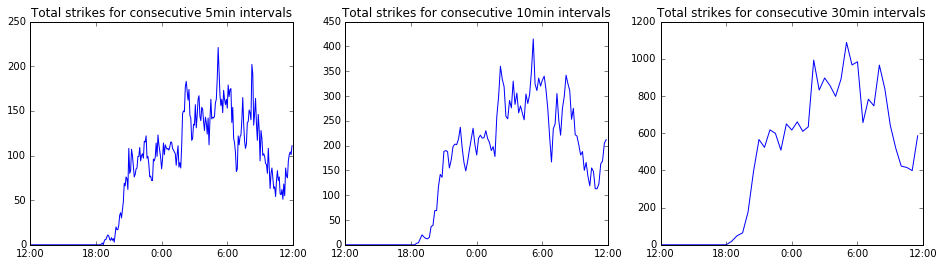

In [8]:
fig = plt.figure(figsize=(16,4))
n=1
for freq, per_hour in zip(['5min','10min','30min'], [12, 6, 2]):
    box, _ = c.get_grid_slices('2014-09-26', freq=freq)
    ax = plt.subplot(1, 3, n)
    ax.plot(np.sum(box, axis=(1,2)))
    ax.set_title('Total strikes for consecutive {freq} intervals'.format(freq=freq))
    ax.set_xlim(0, per_hour*24)
    ax.set_xticks([0, per_hour*6, per_hour*12, per_hour*18, per_hour*24])
    ax.set_xticklabels(['12:00', '18:00', '0:00', '6:00', '12:00'])
    n+=1
plt.show()


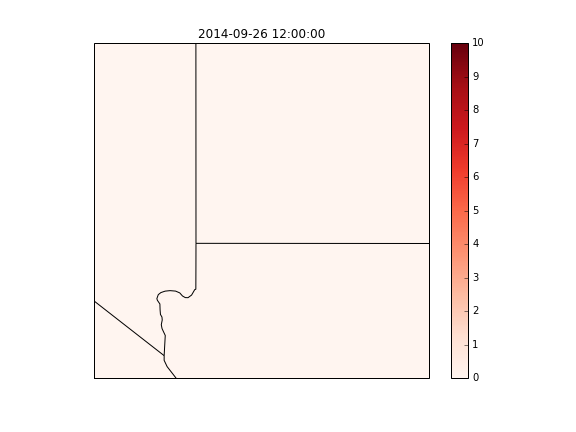
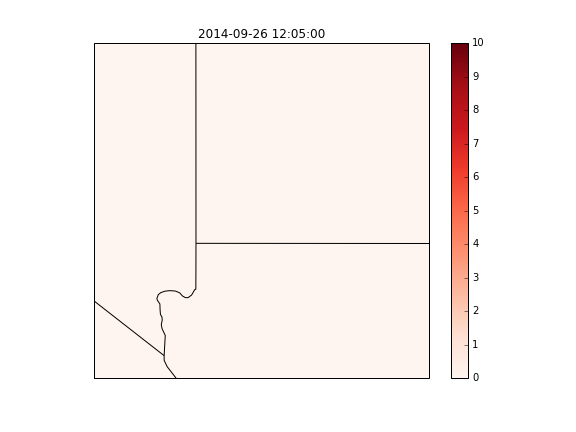
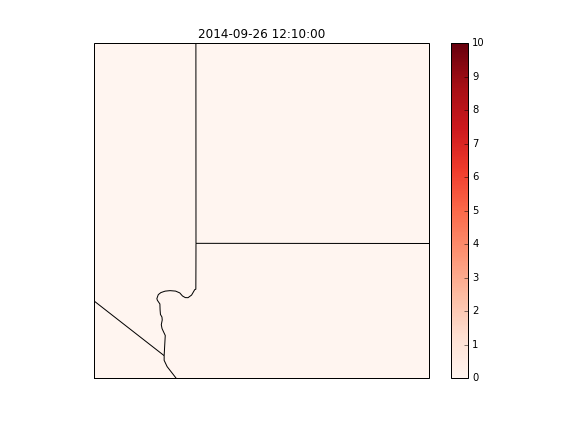
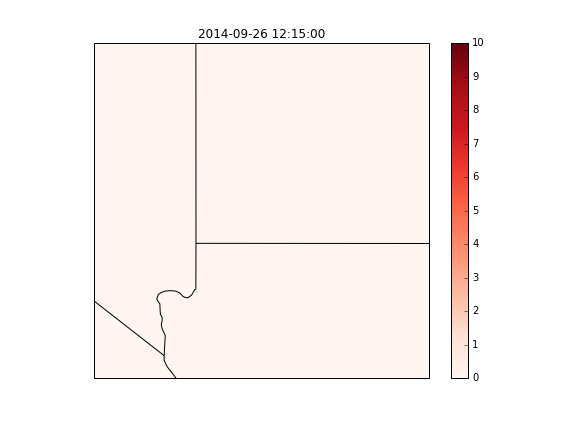
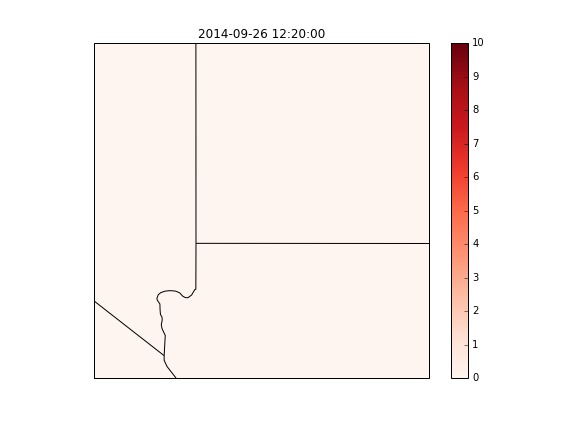
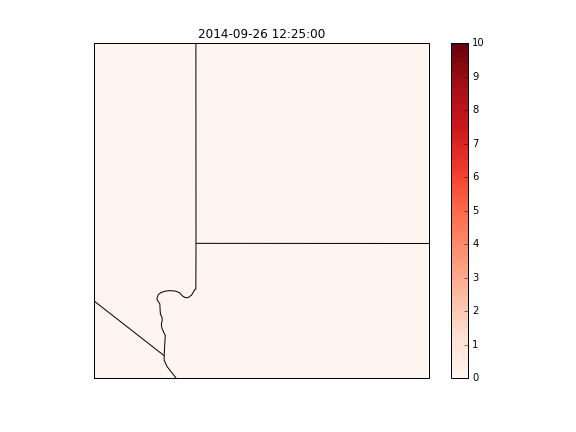
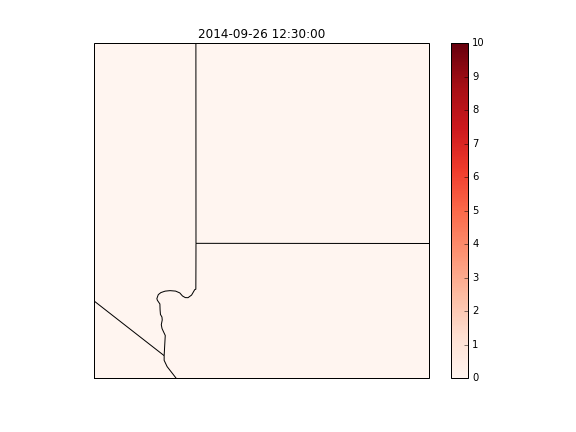
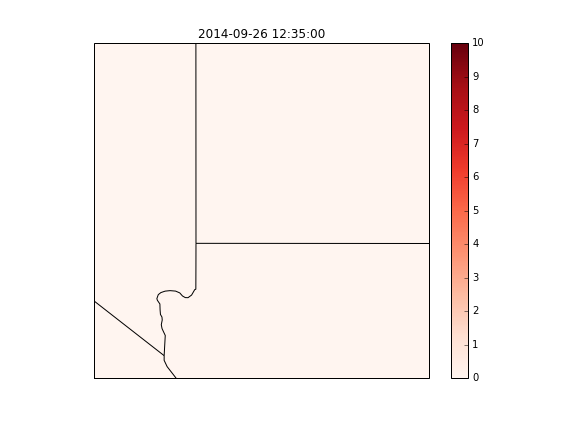
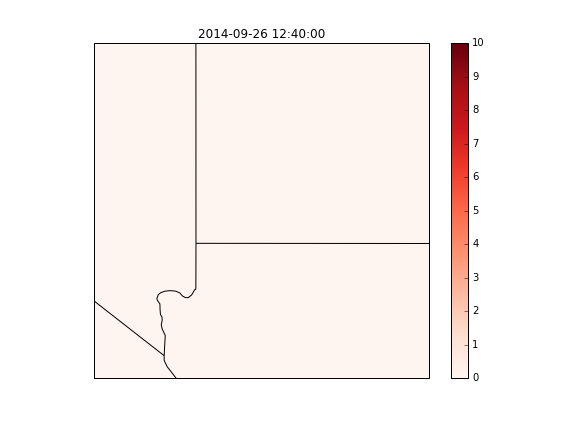
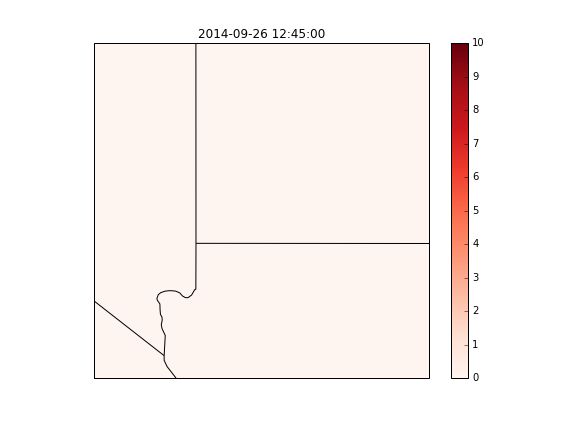
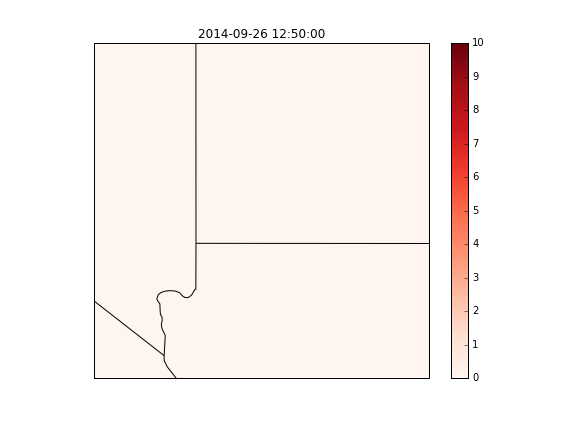
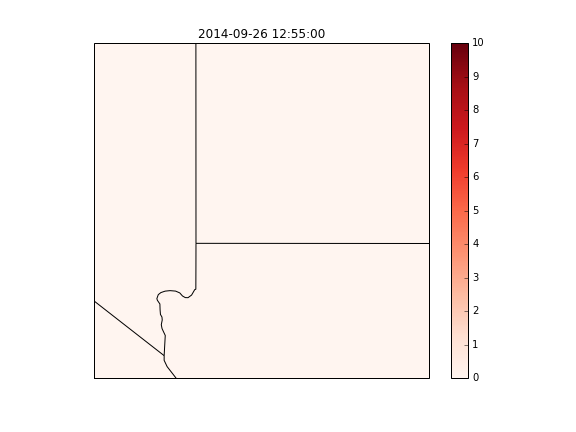
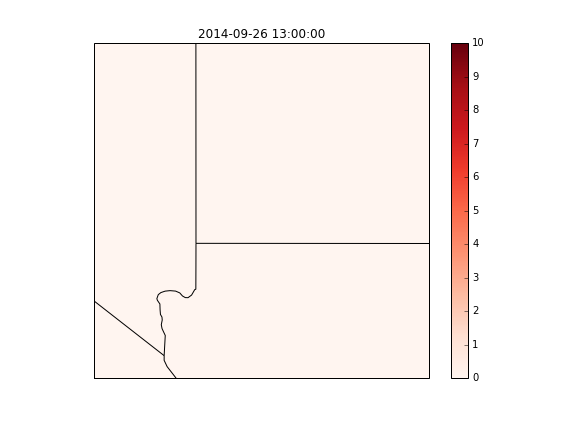
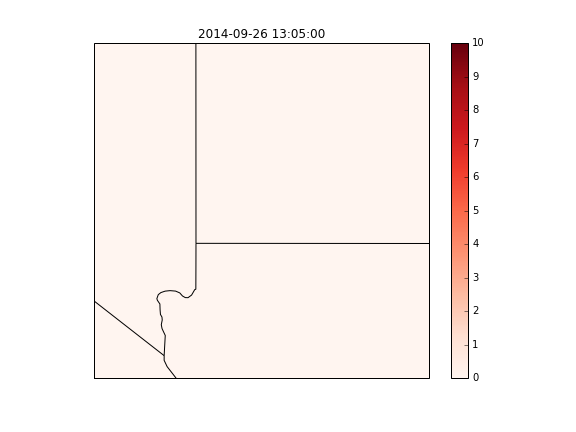
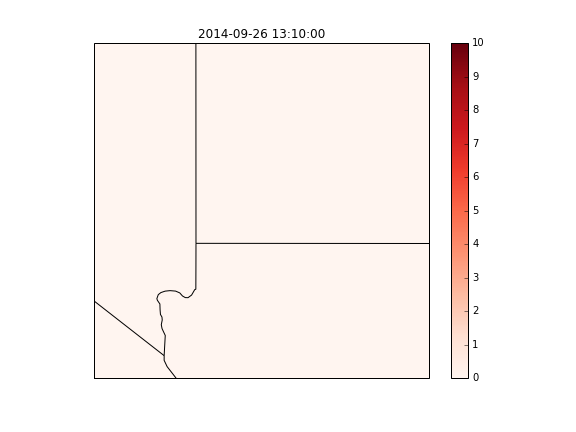
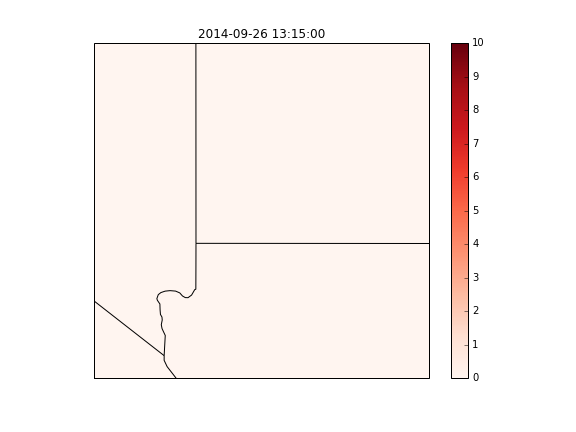
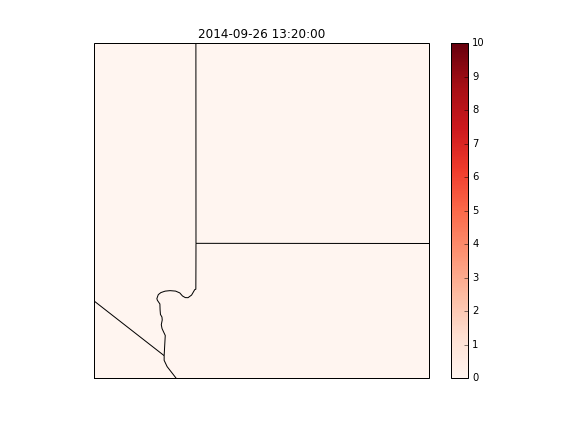
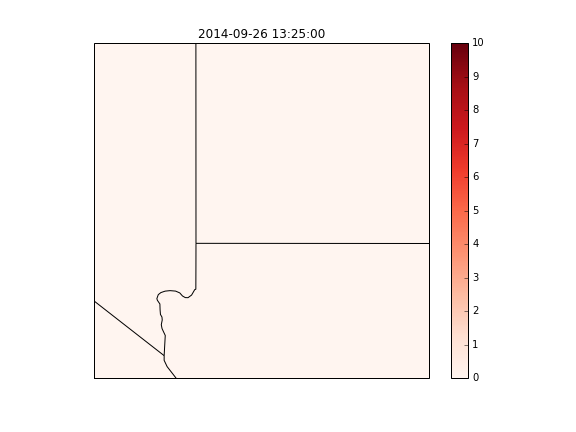
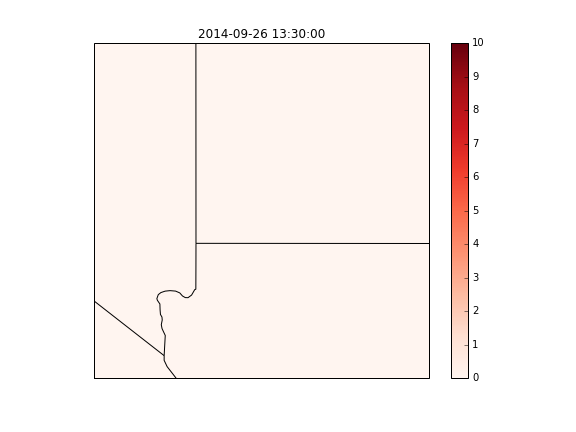
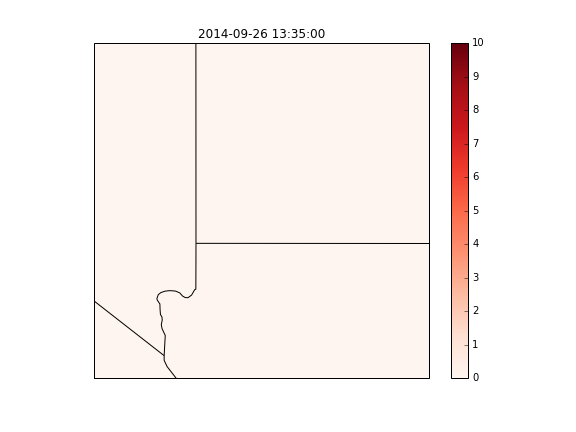
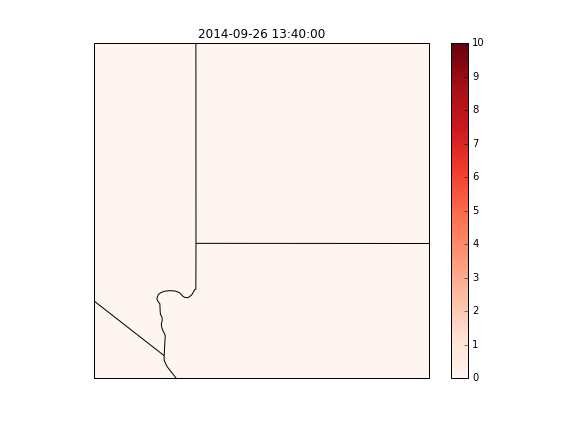
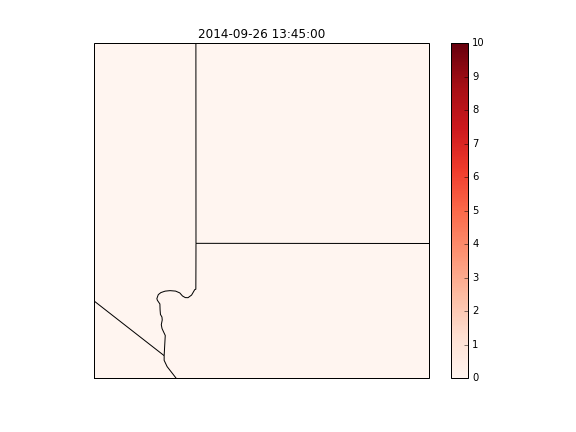
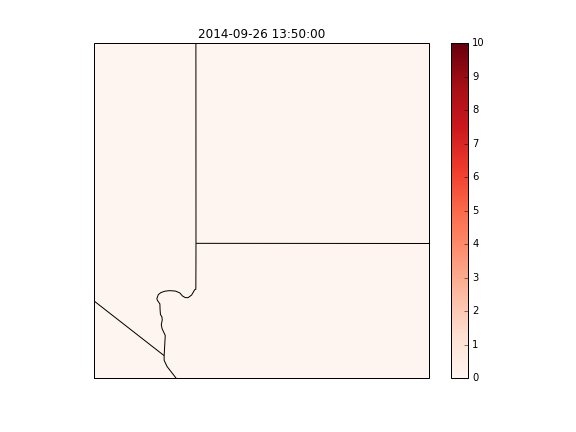
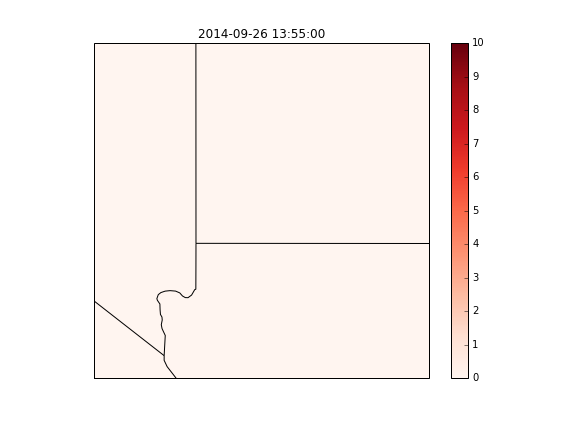
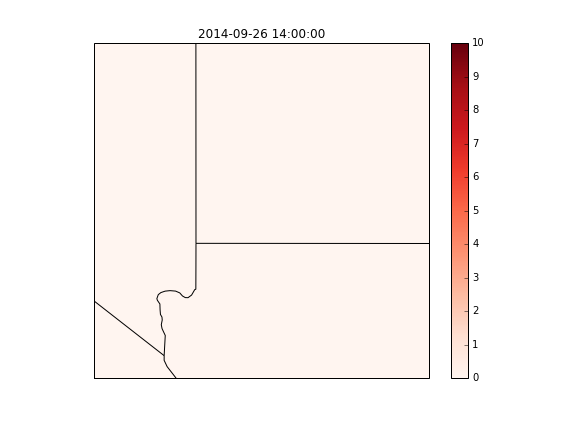
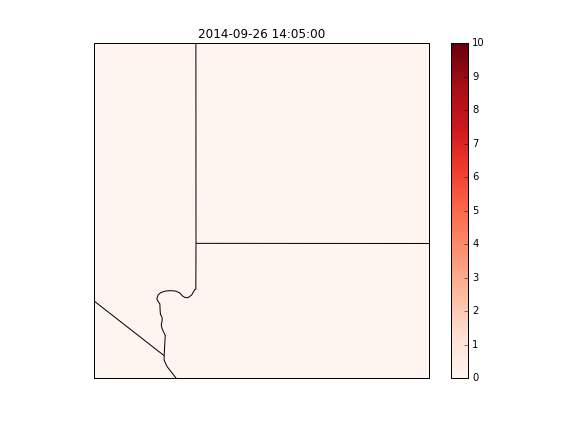
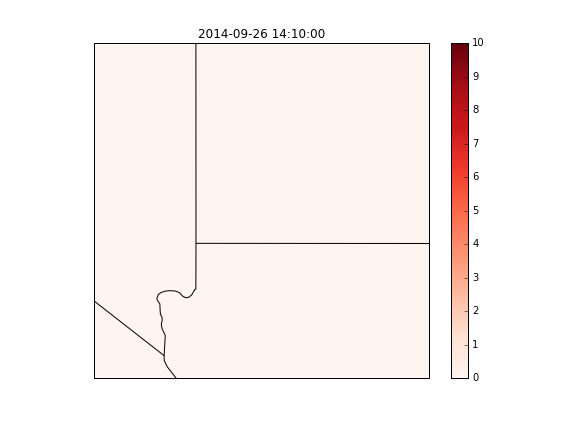
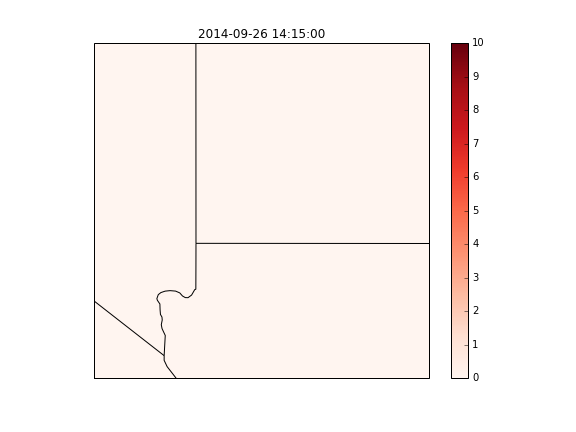
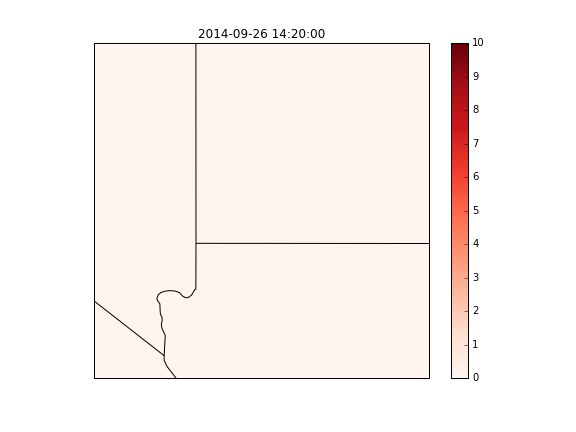
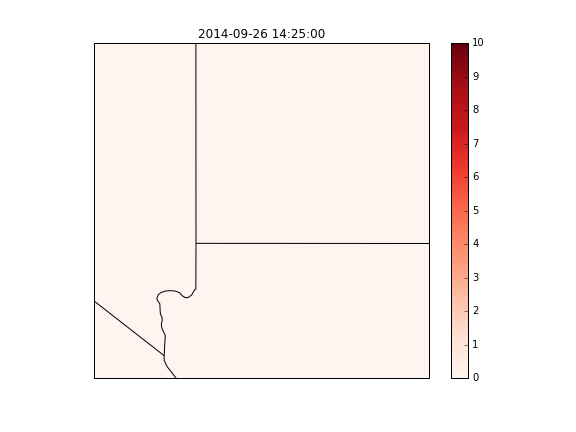
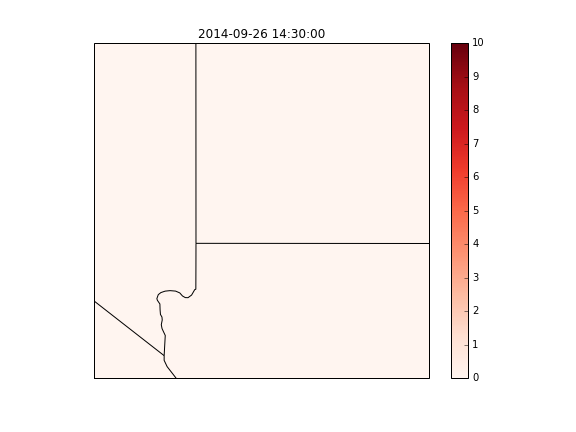
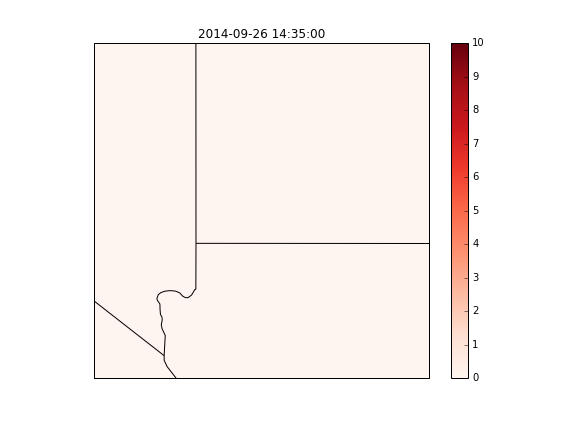
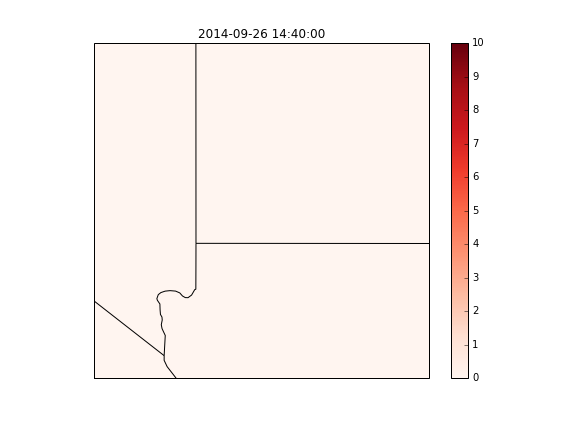
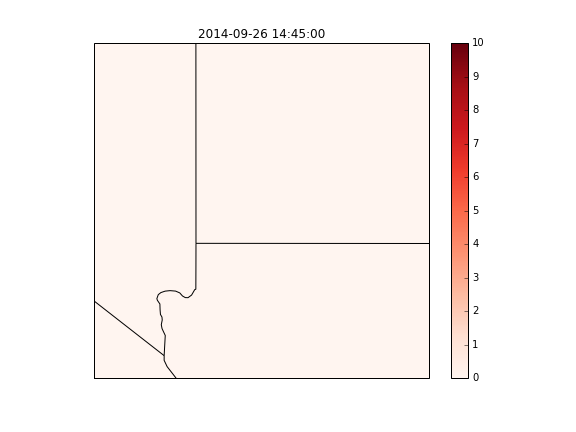
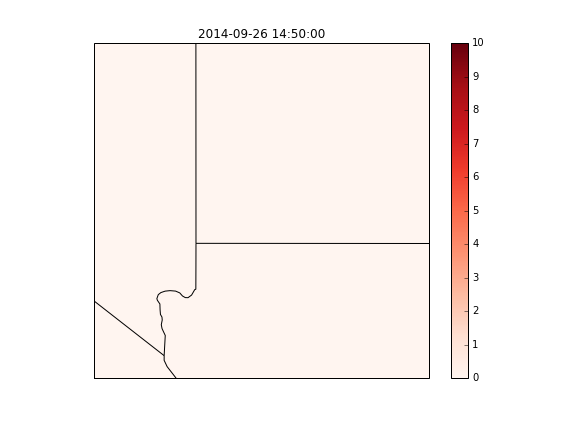
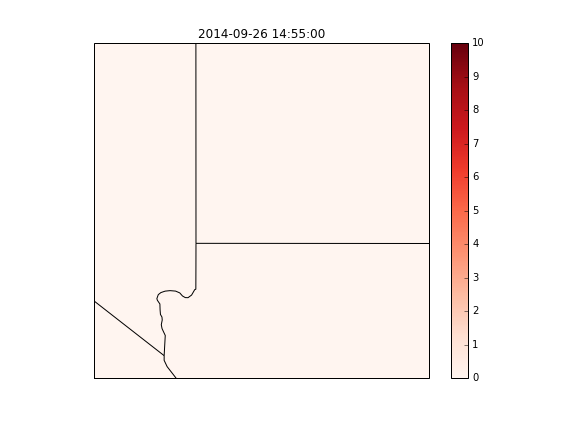
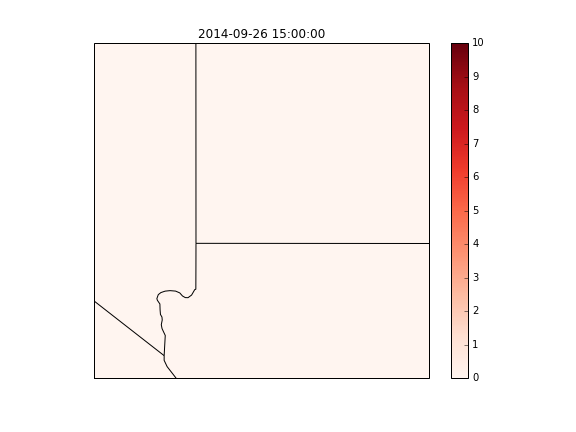
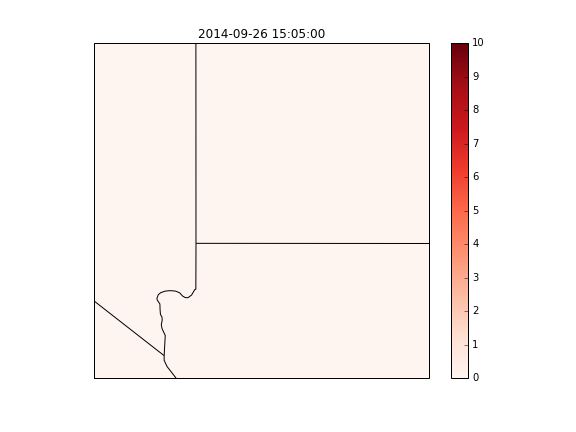
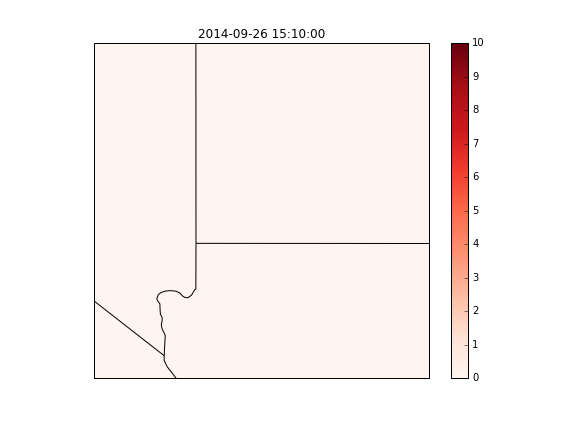
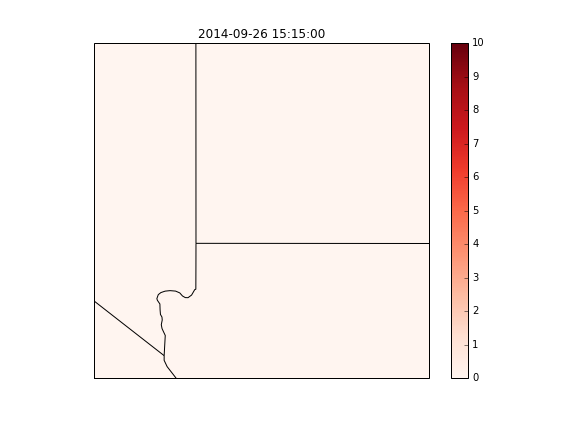
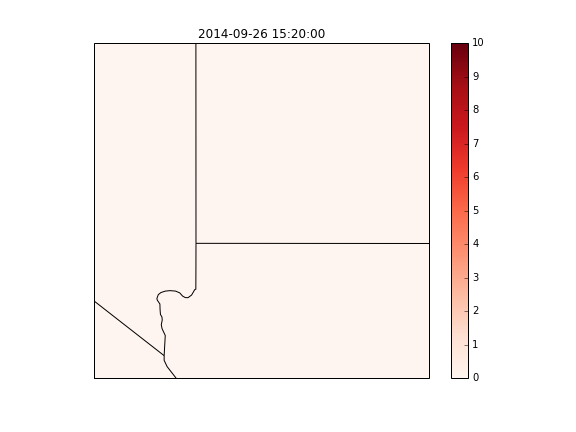
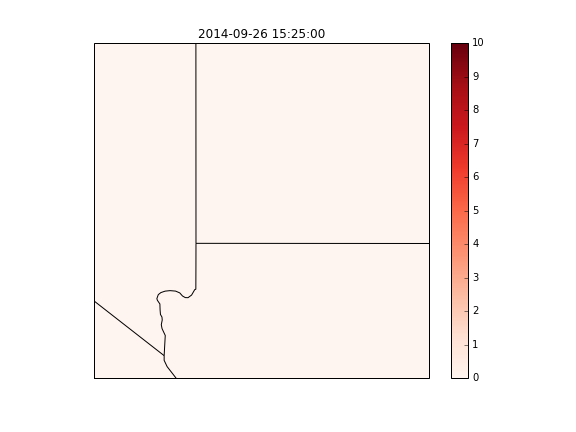
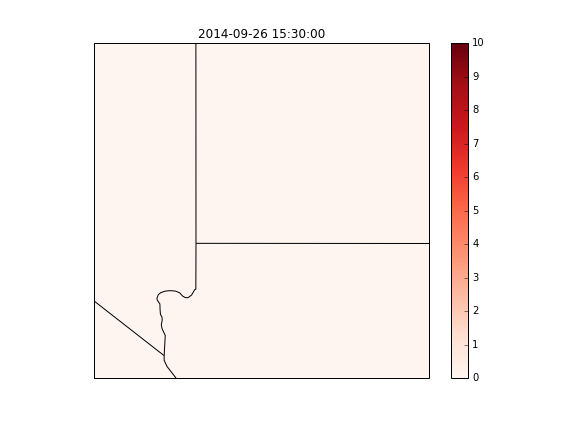
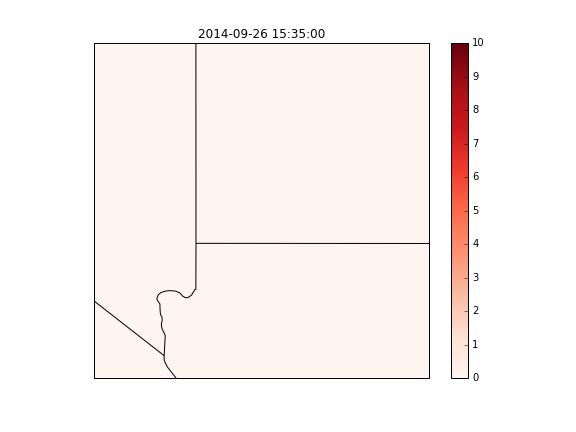
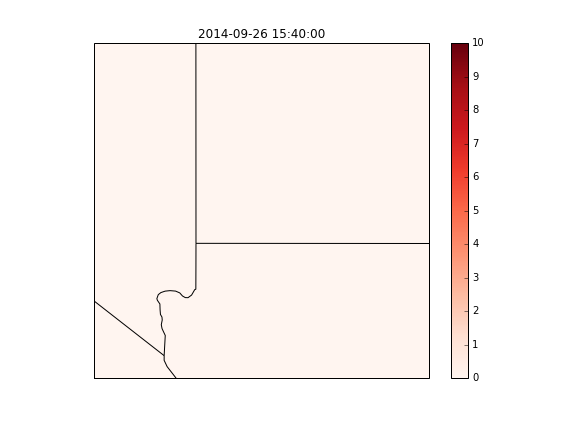
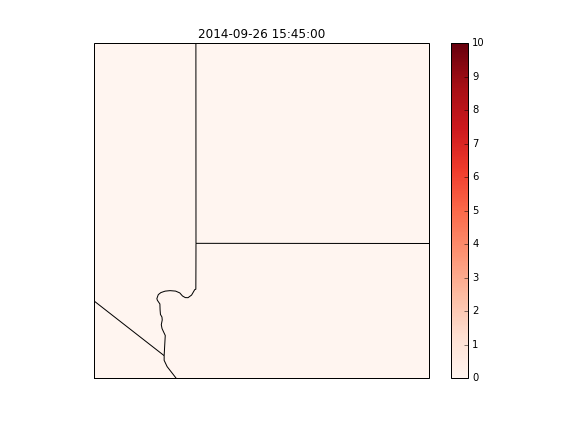
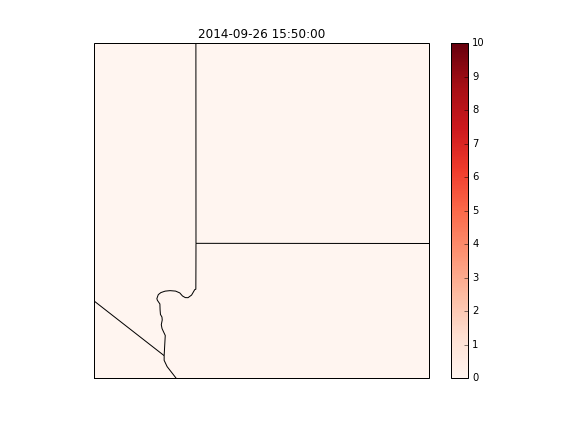
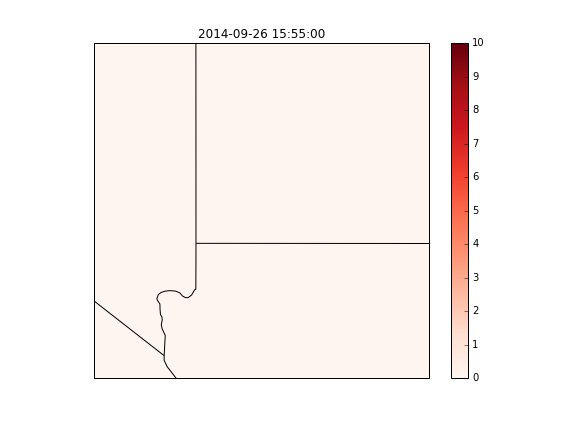
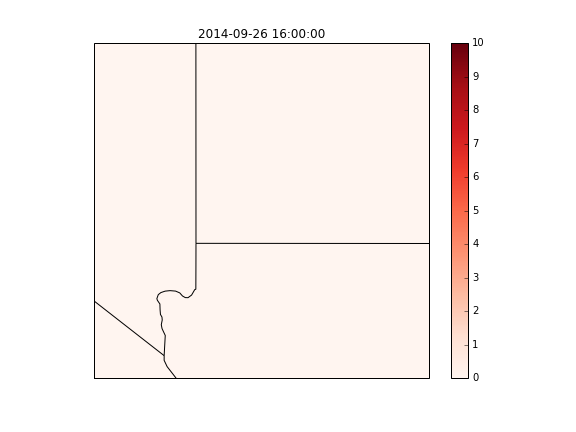
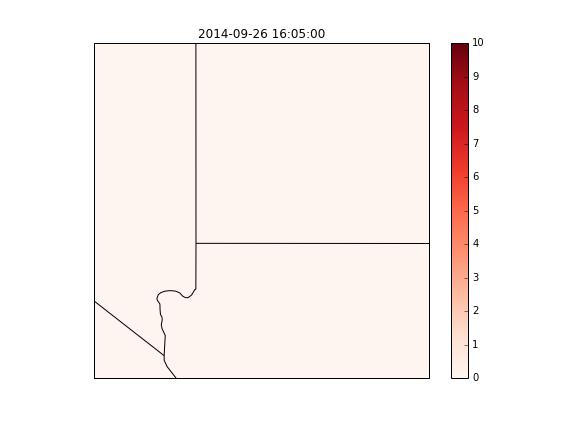
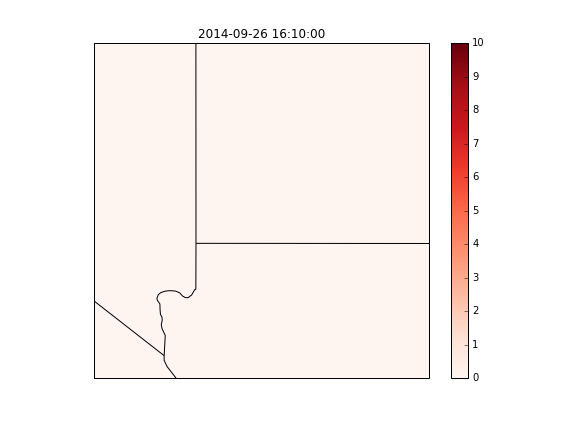
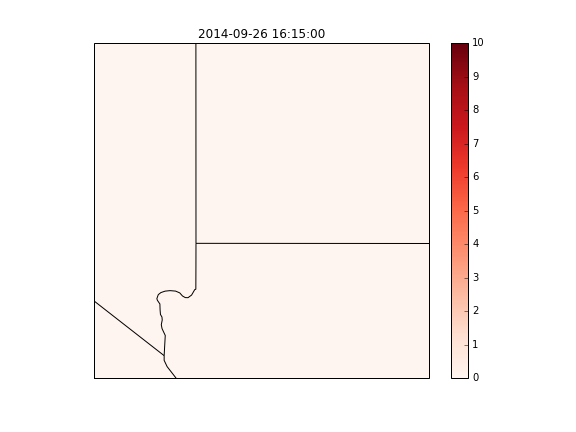
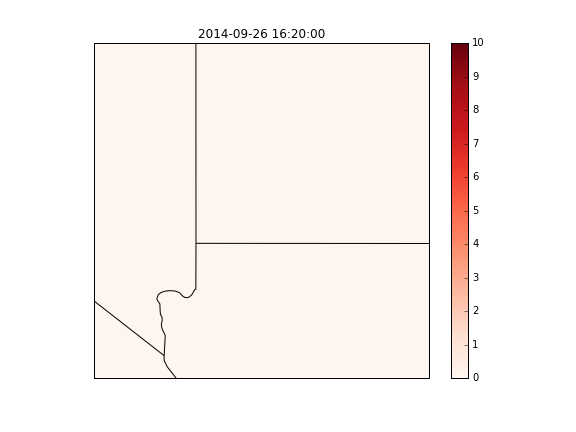
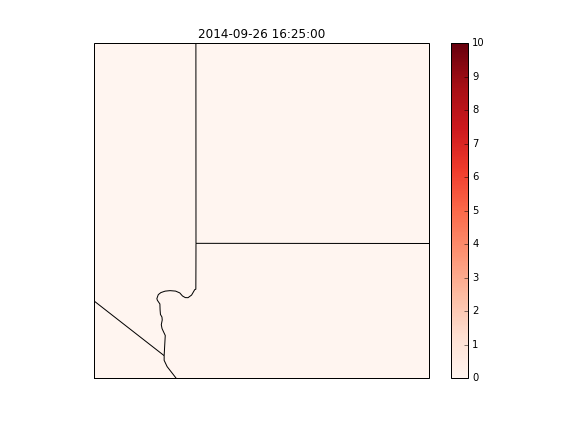
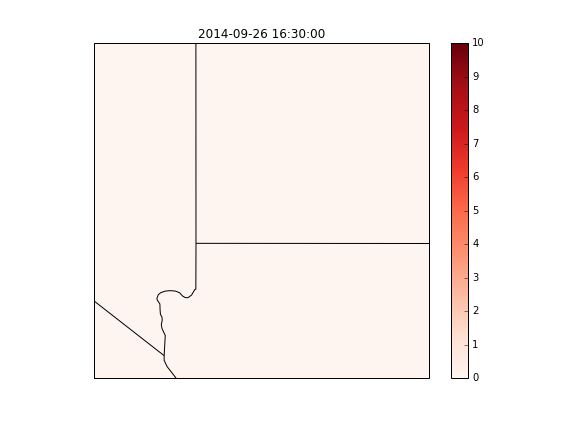
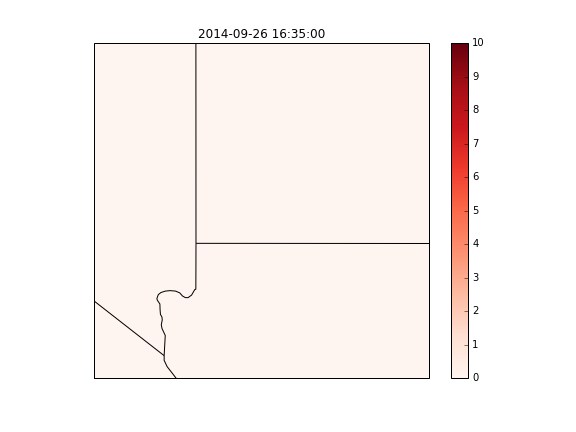
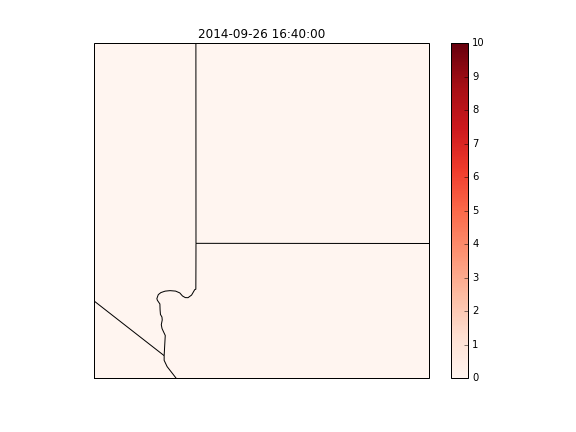
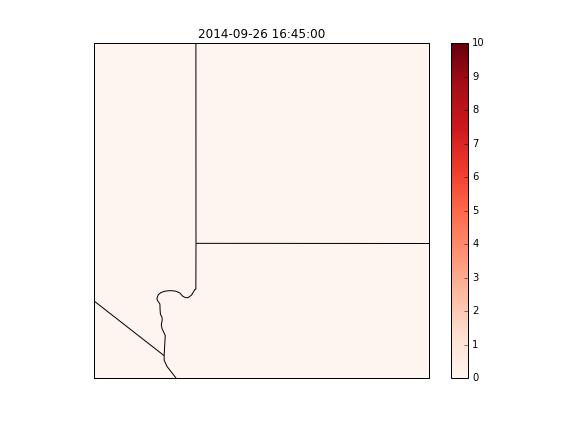
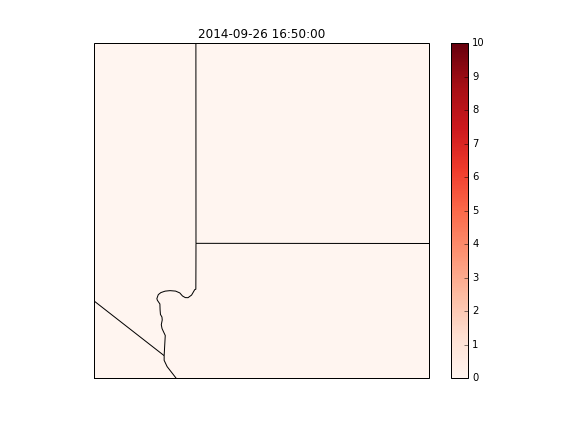
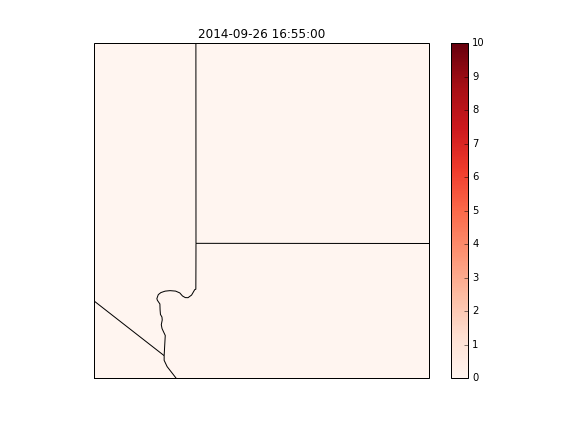
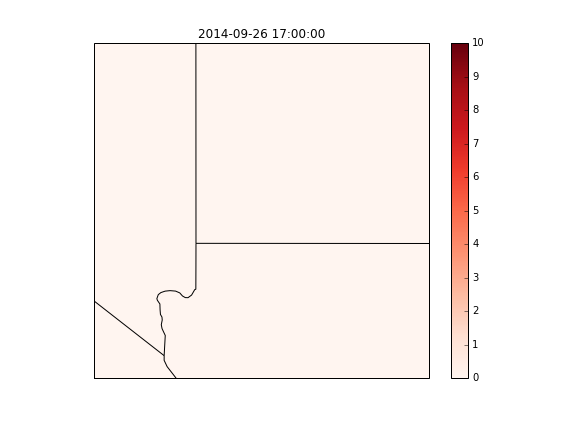
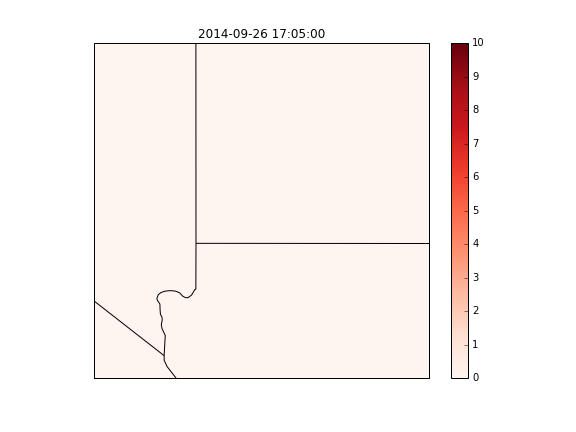
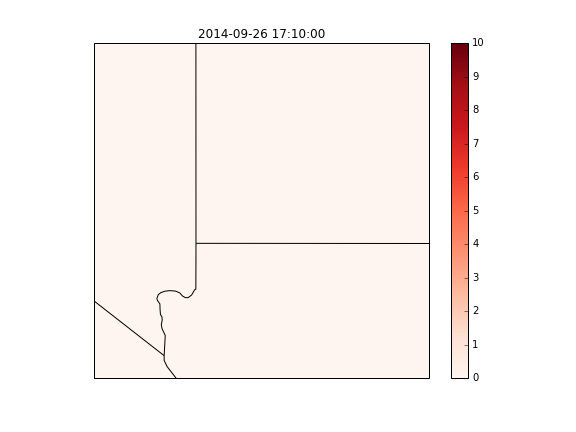
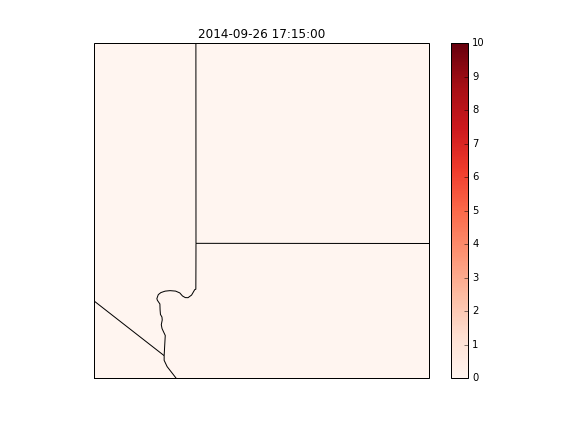
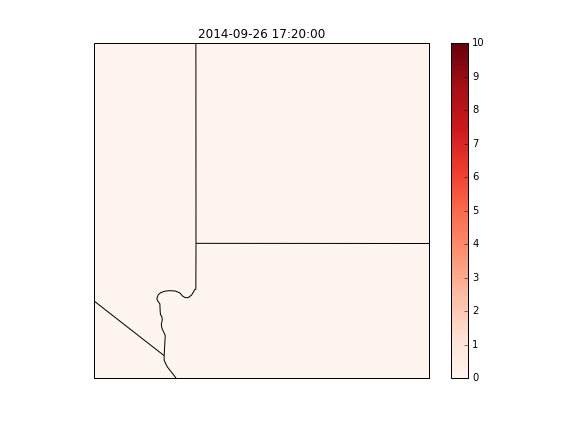
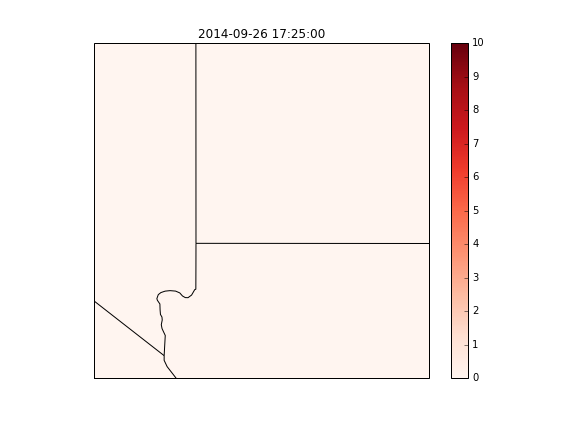
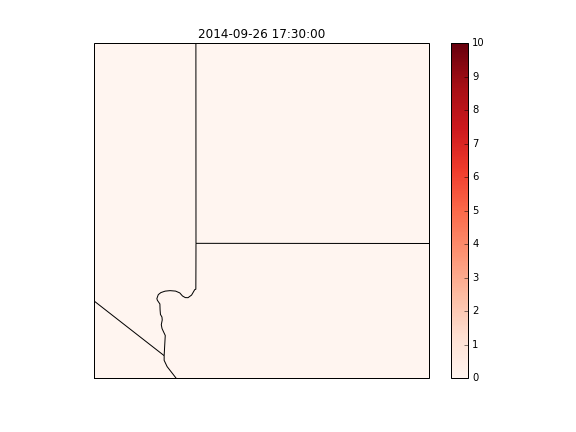
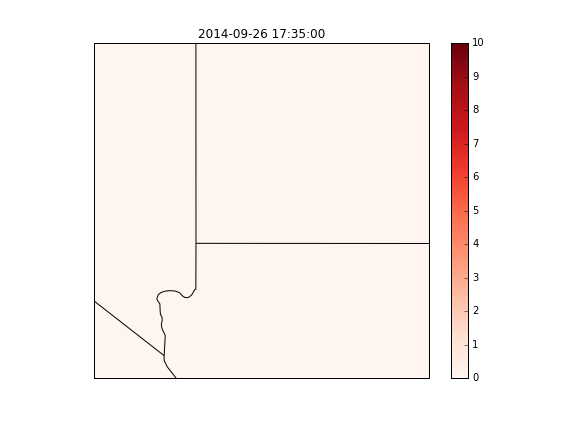
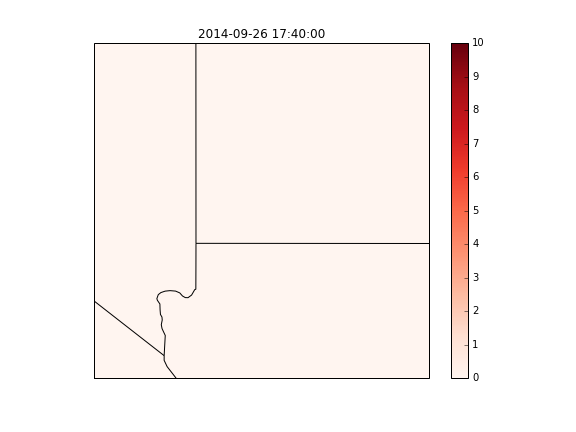
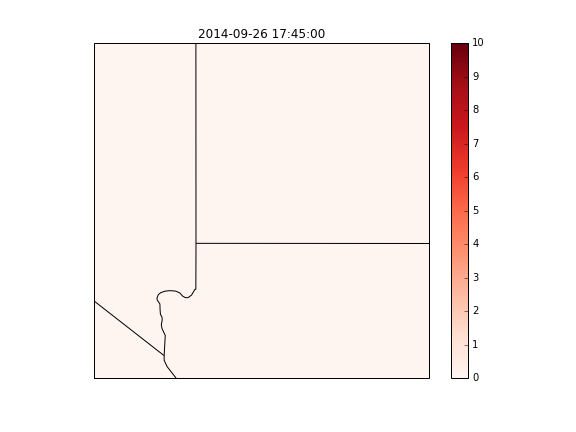
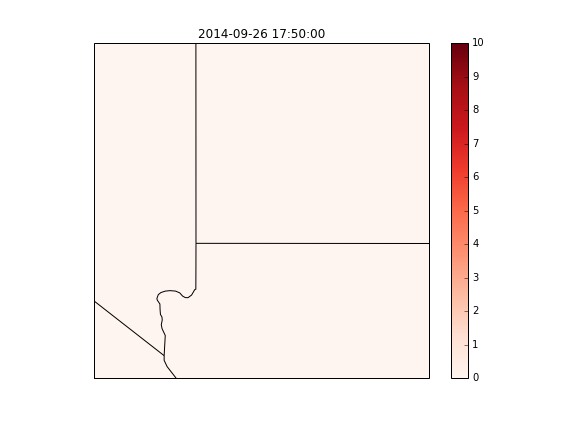
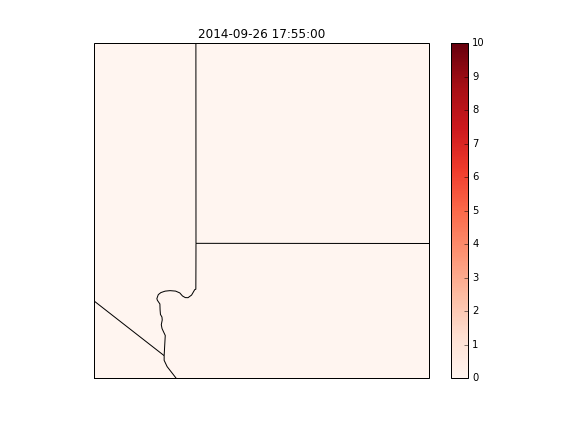
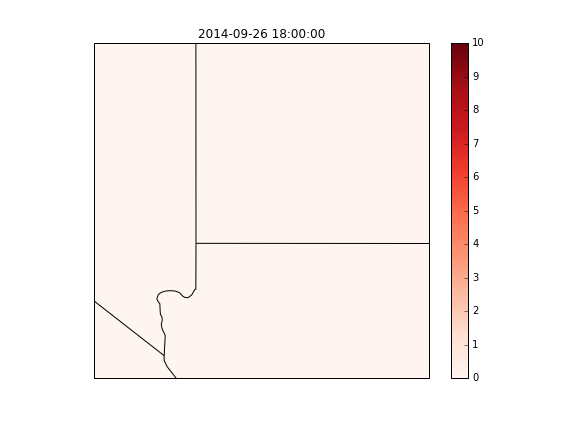
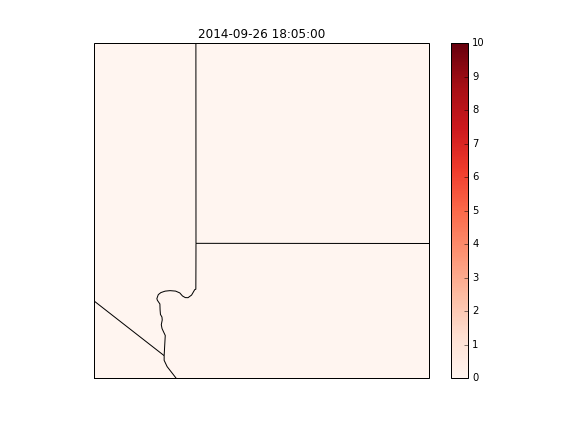
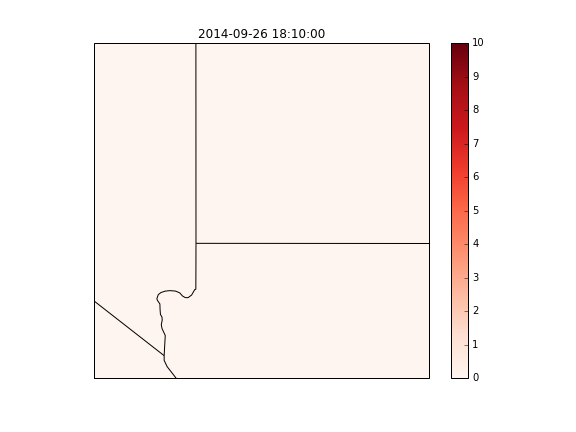
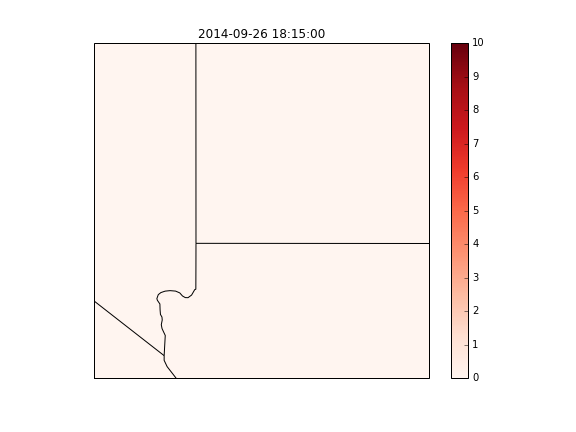
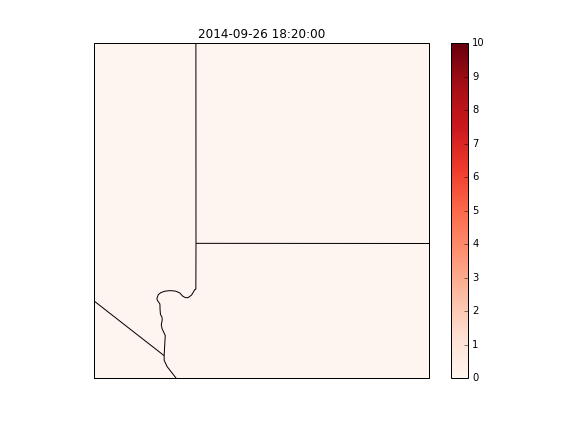
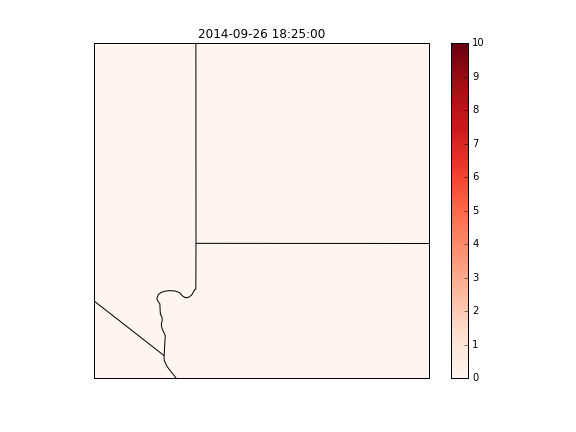
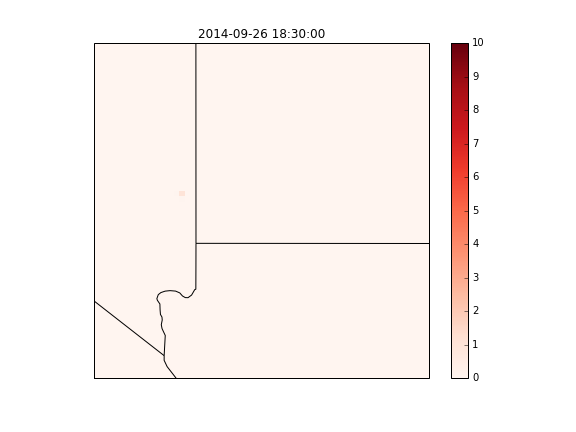
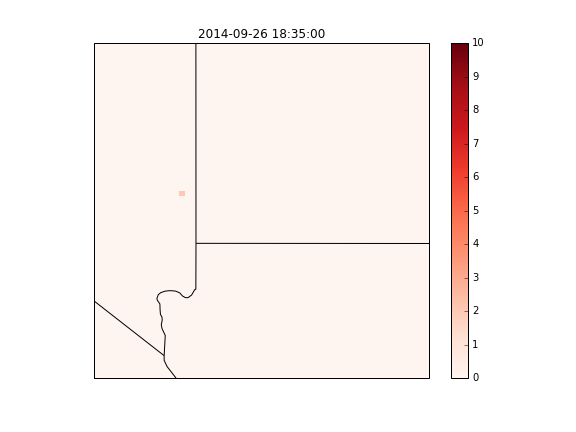
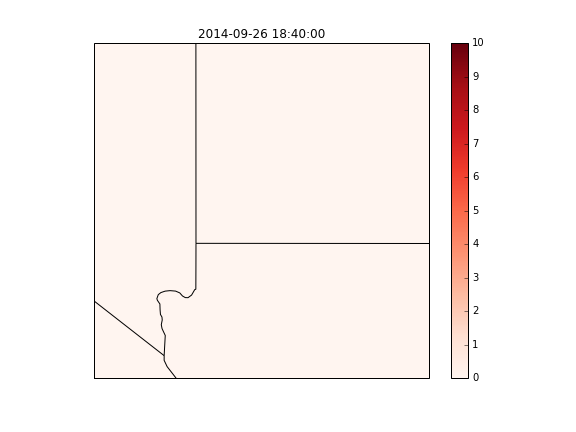
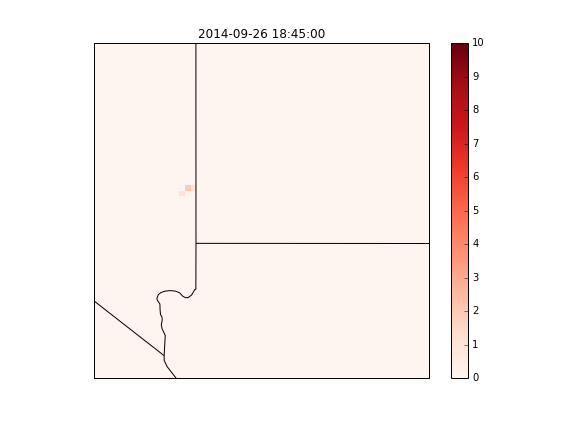
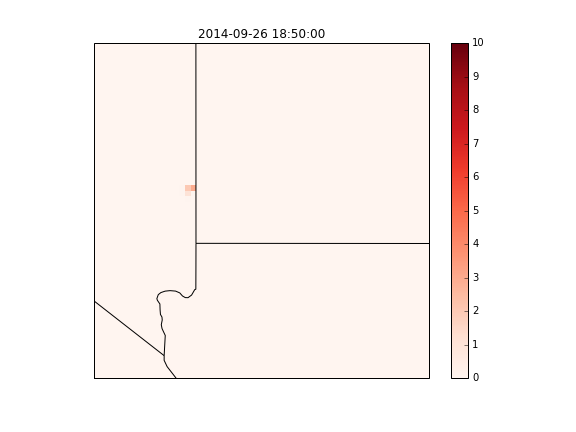
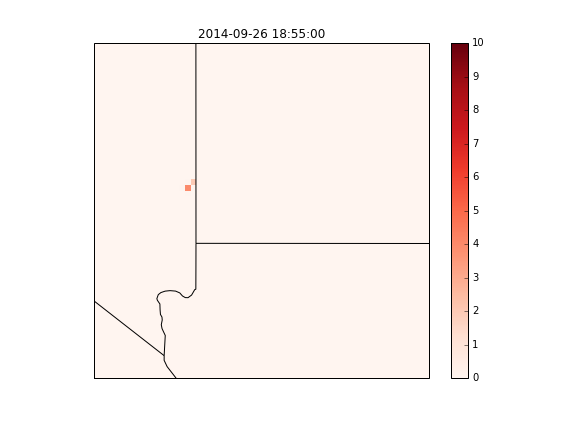
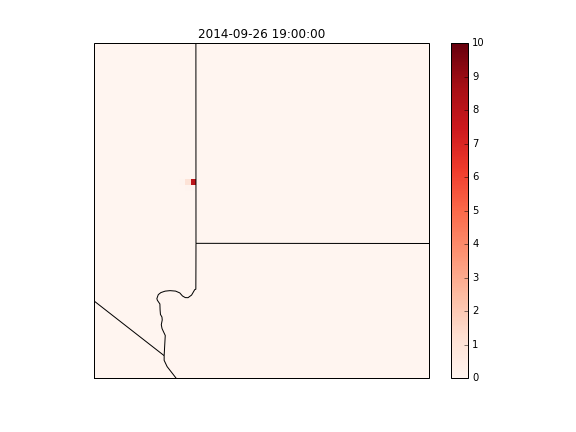
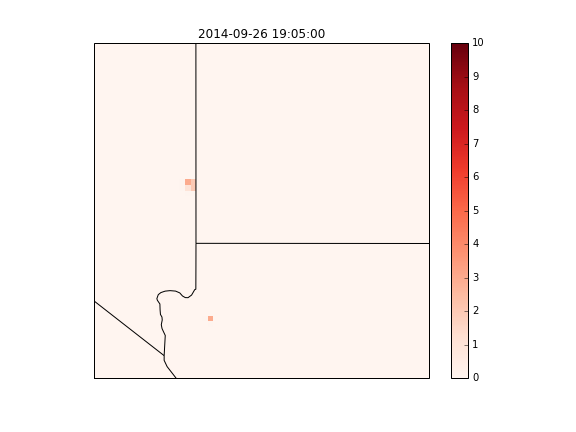
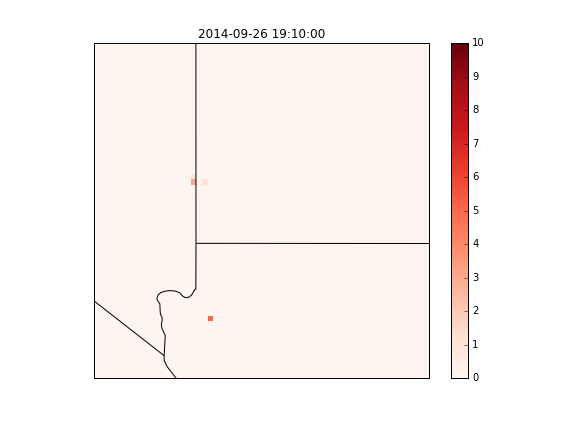
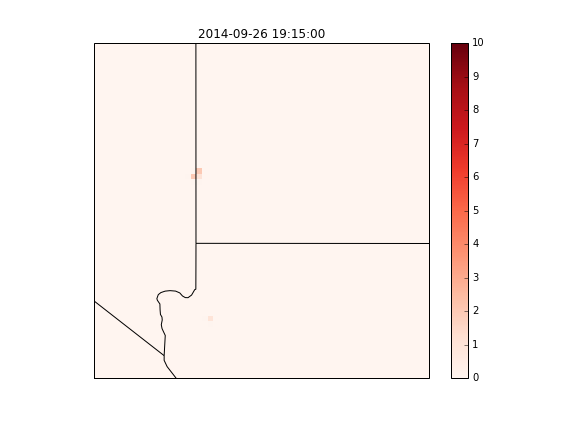
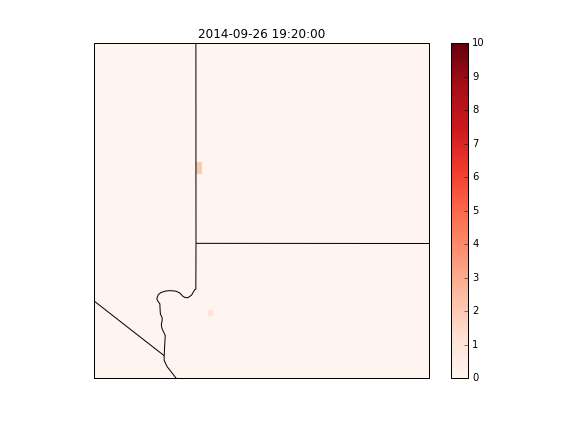
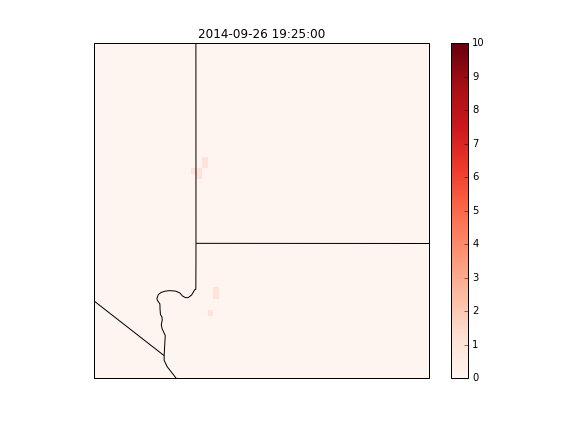
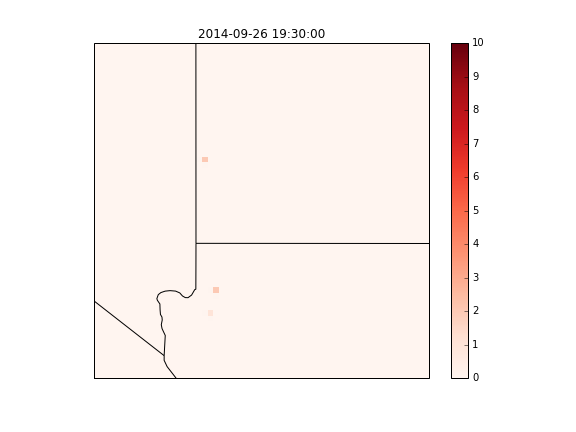
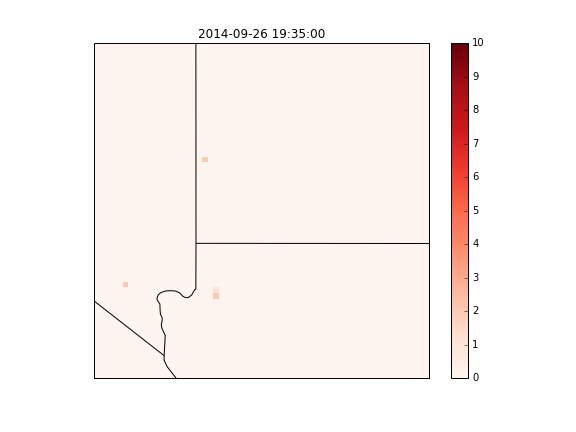
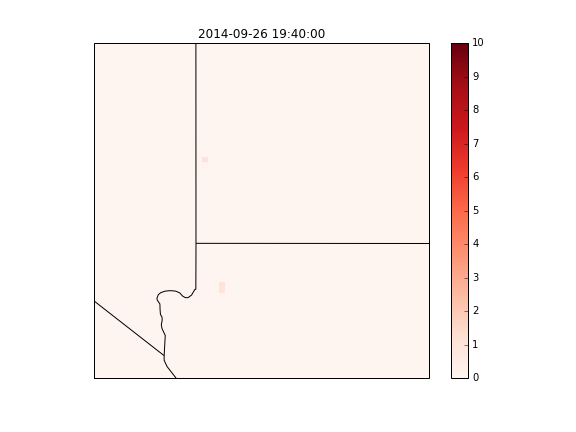
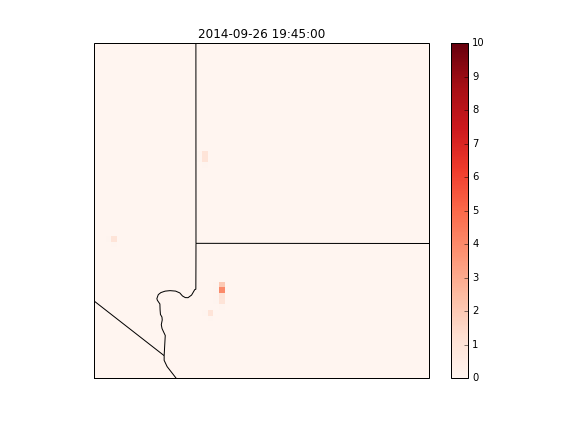
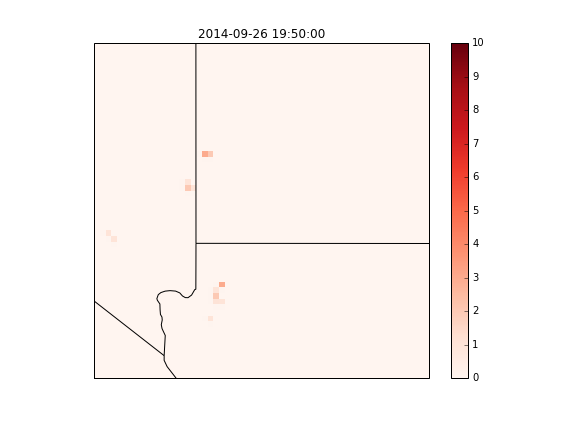
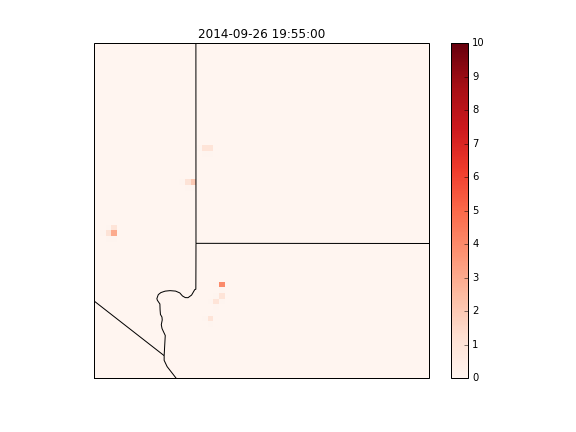
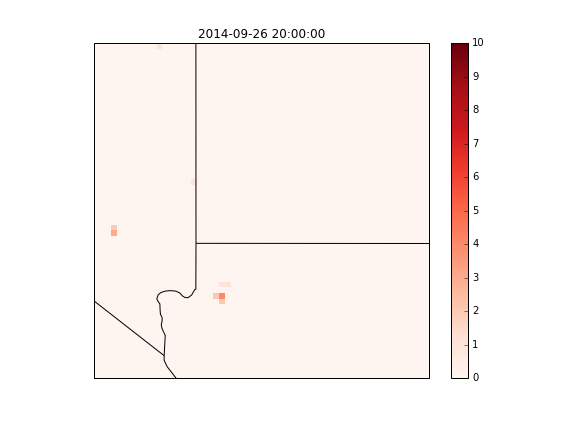
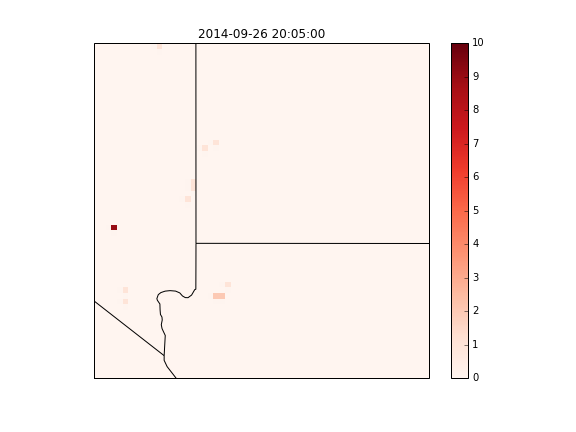
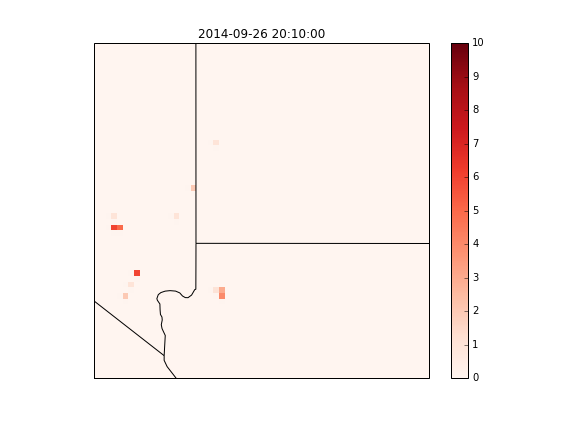
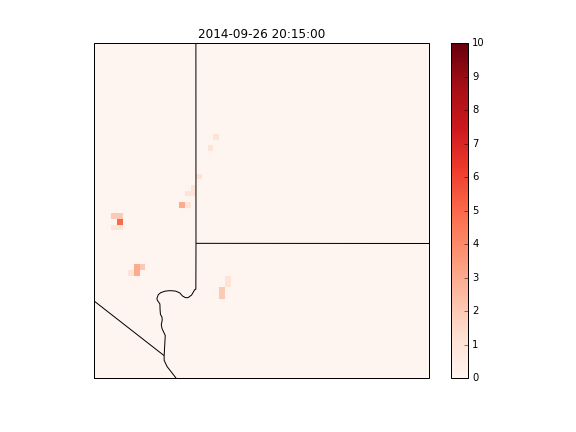
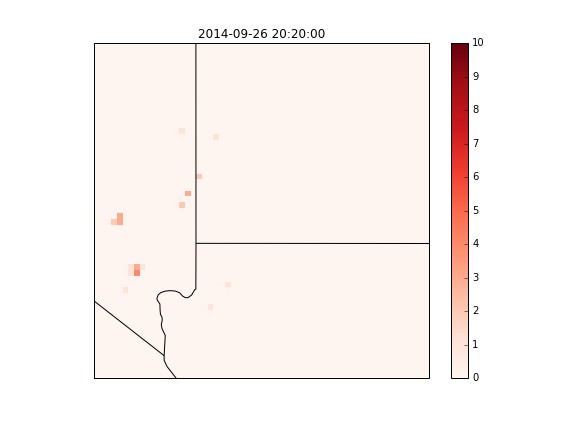
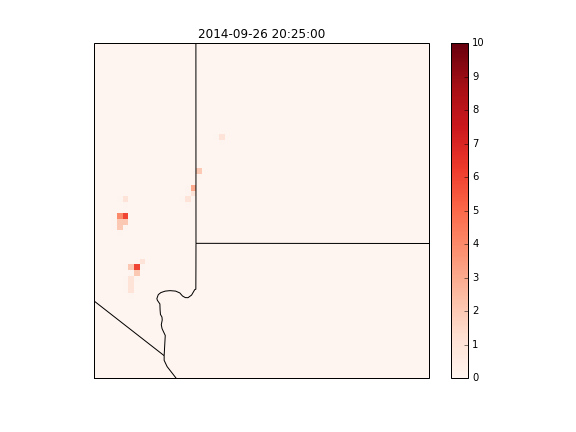
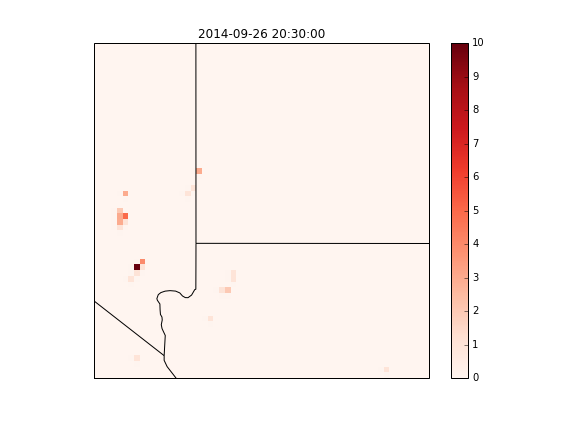
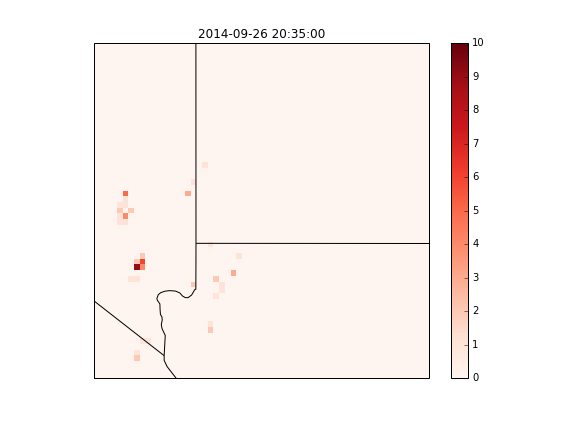
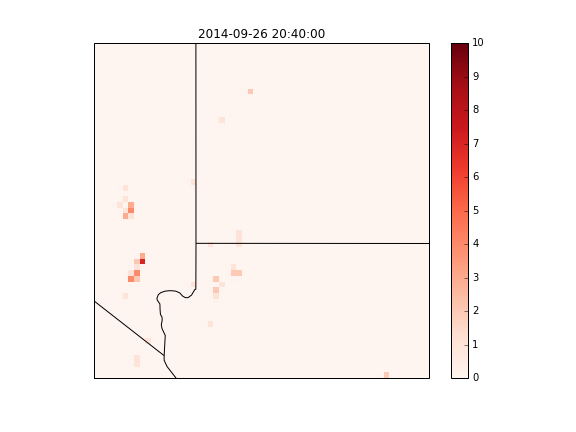
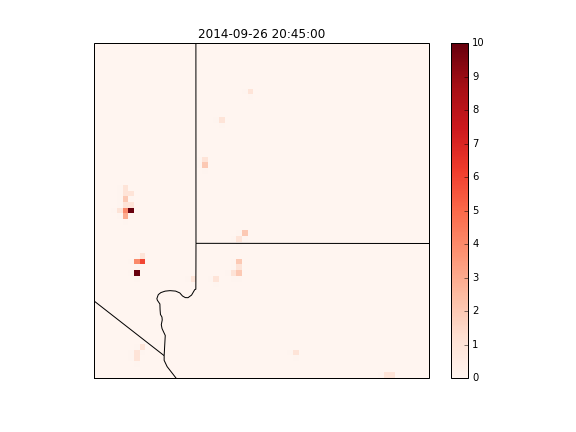
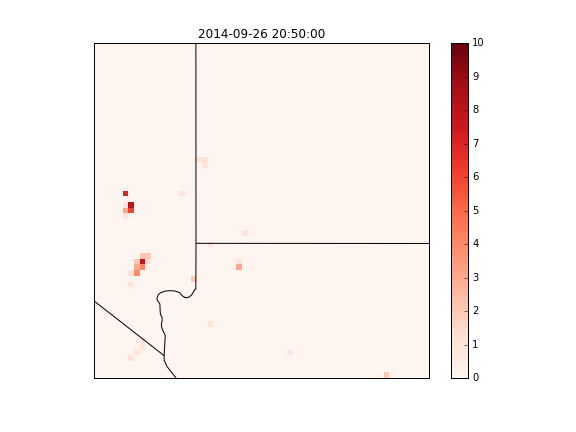
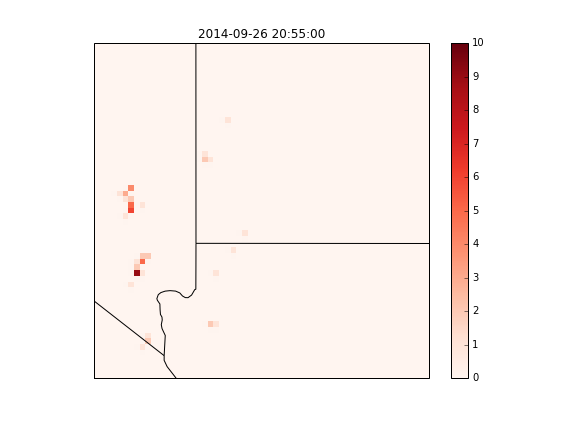
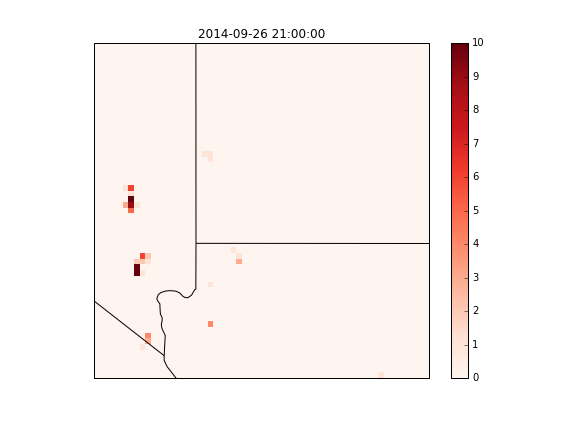
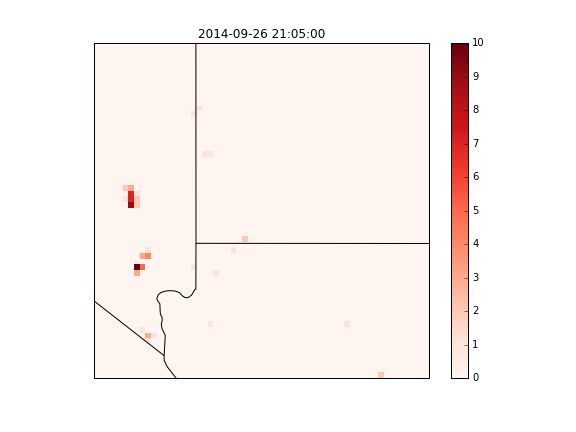
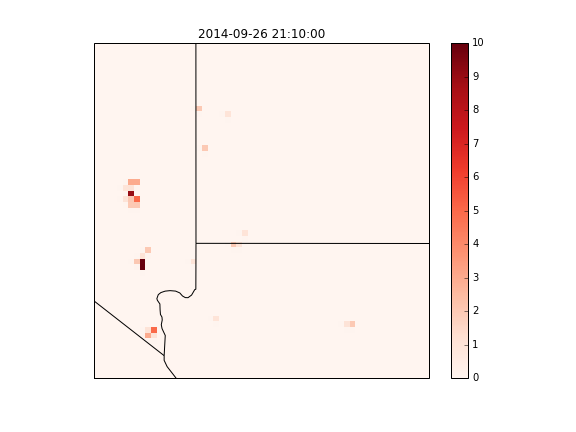
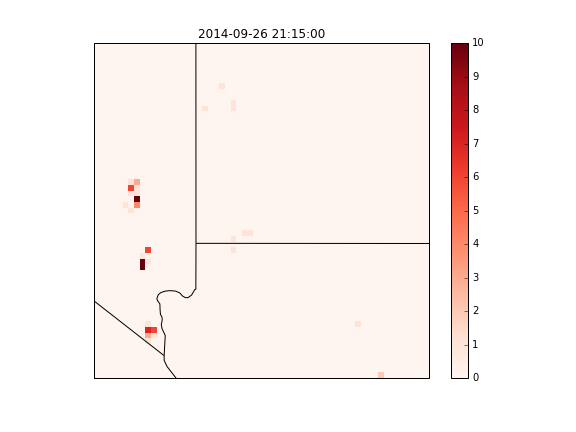
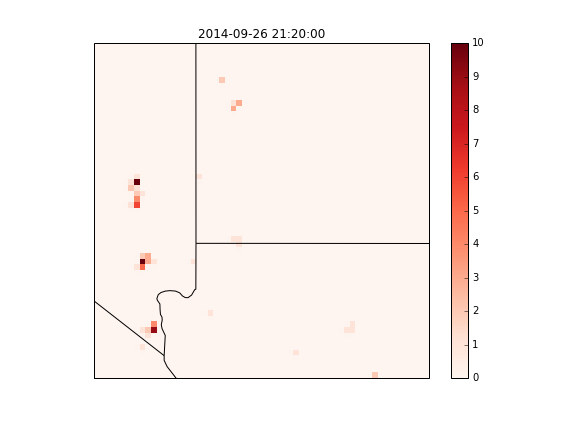
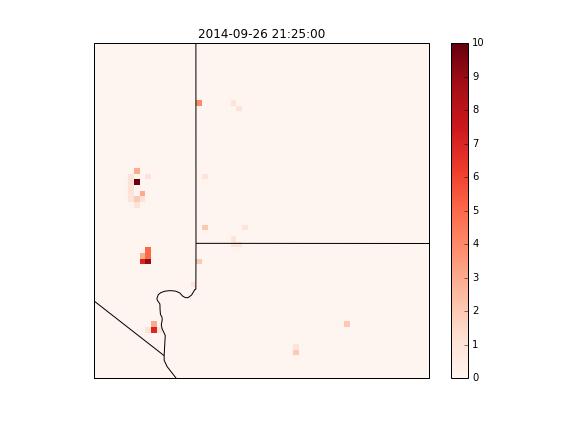
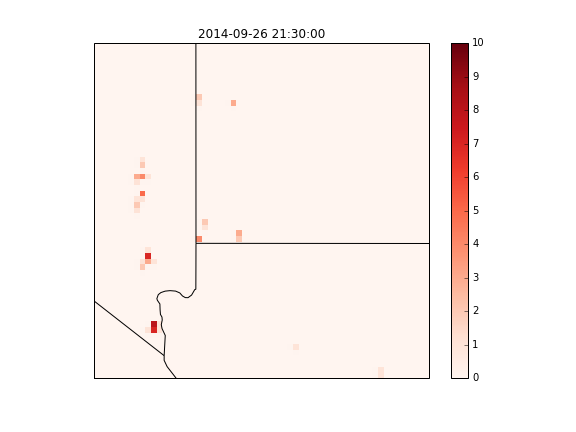
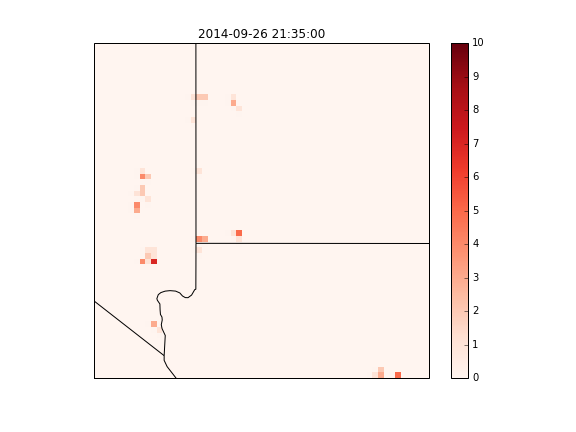
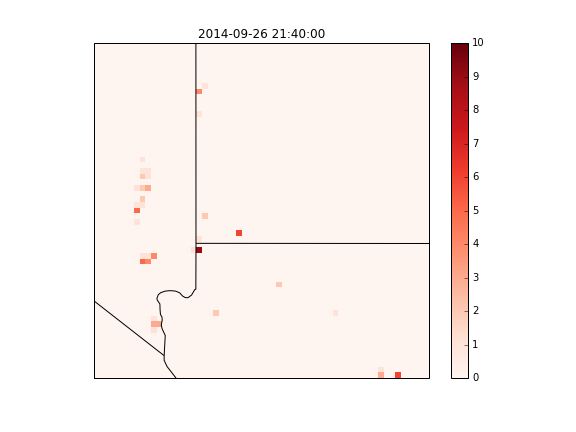
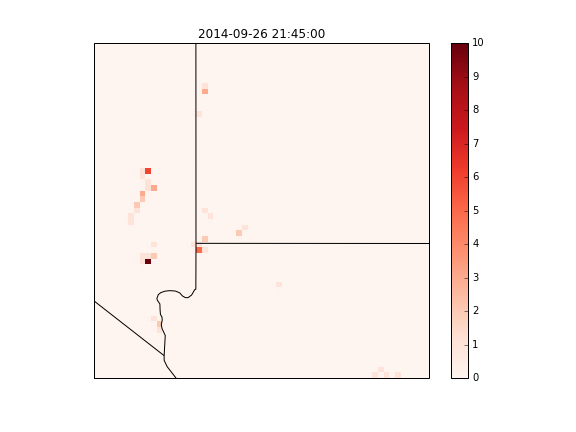
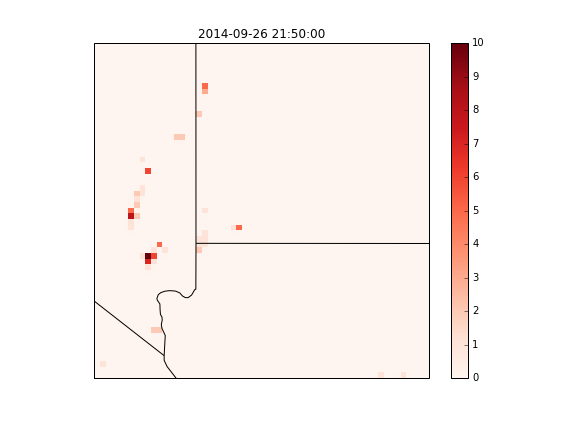
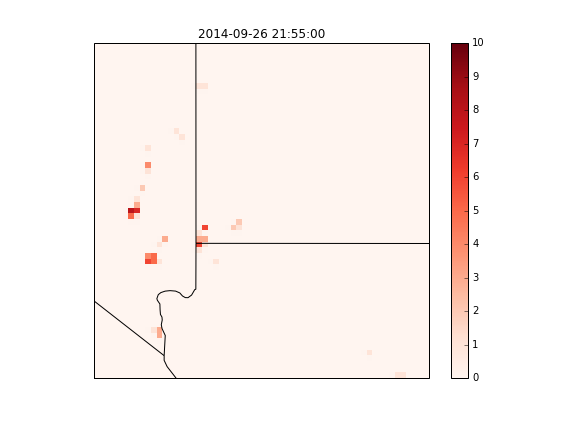
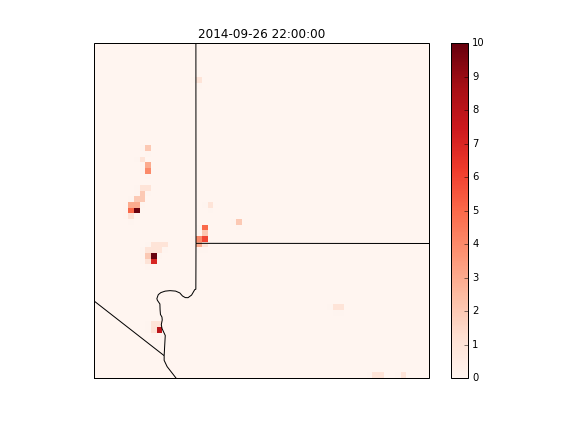
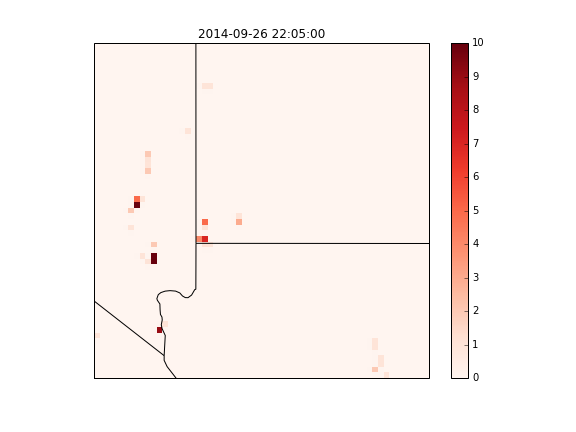
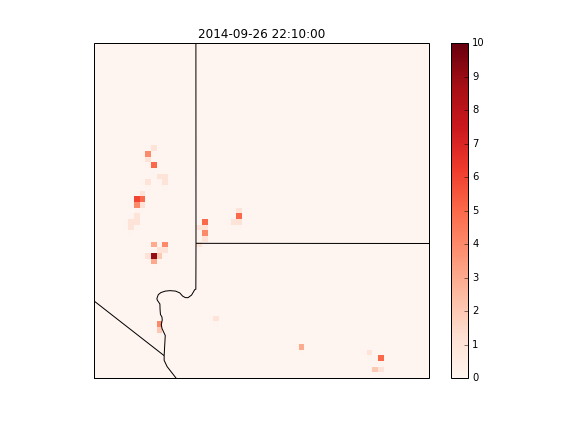
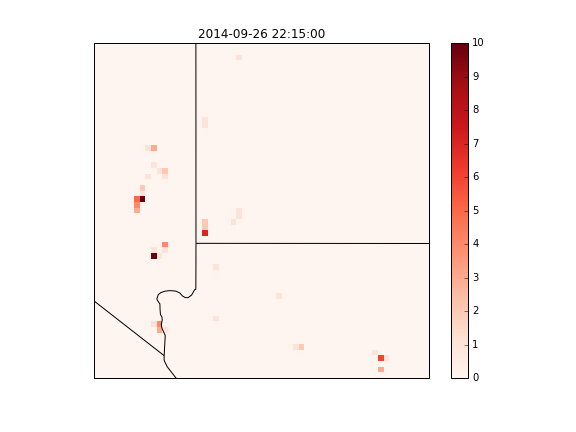
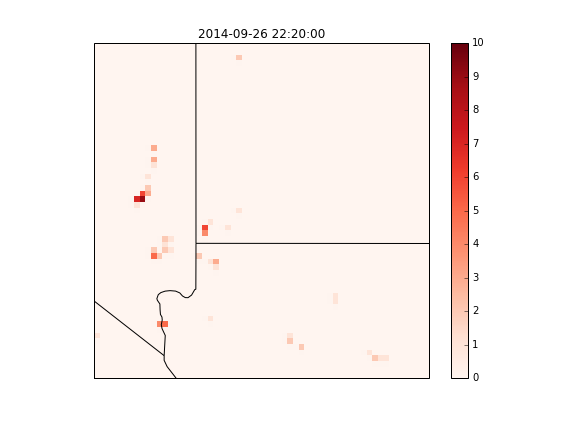
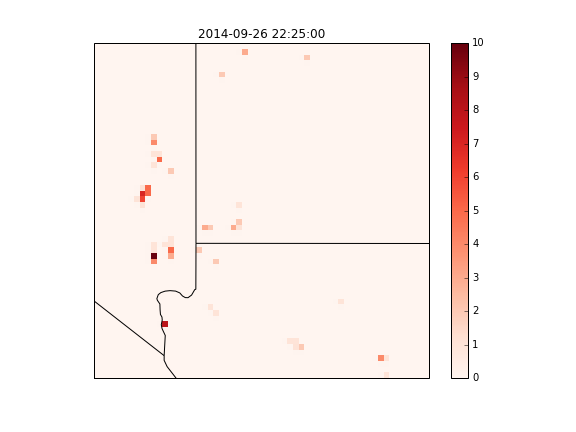
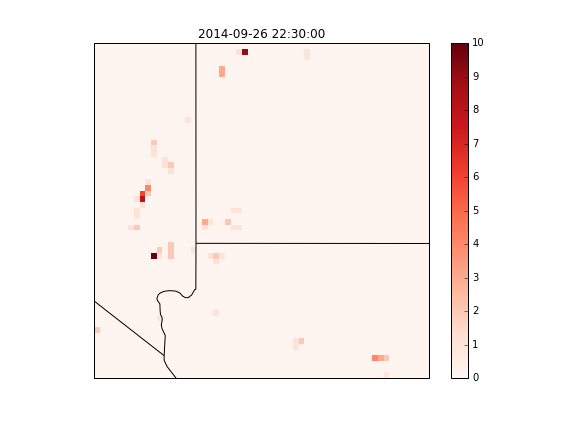
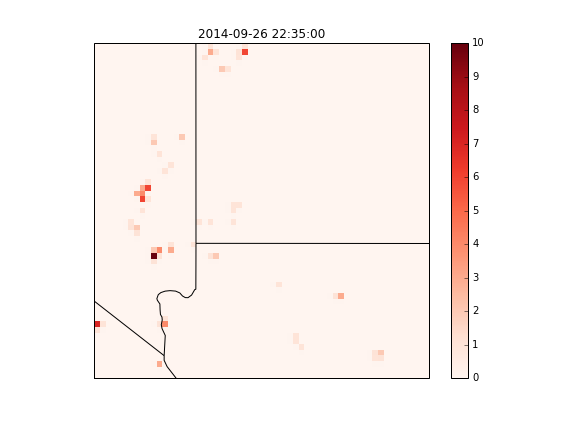
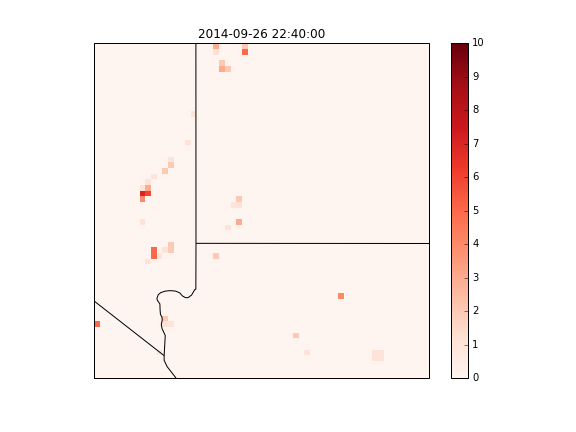
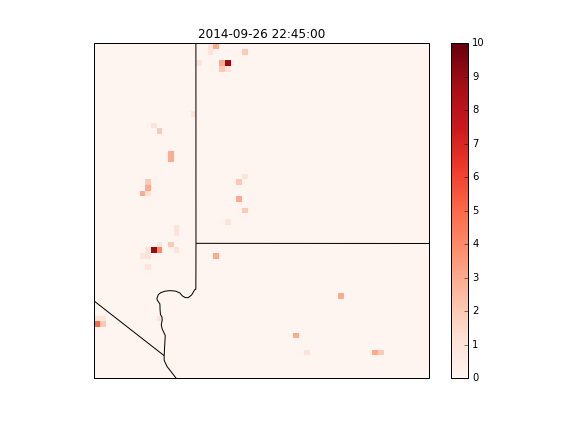
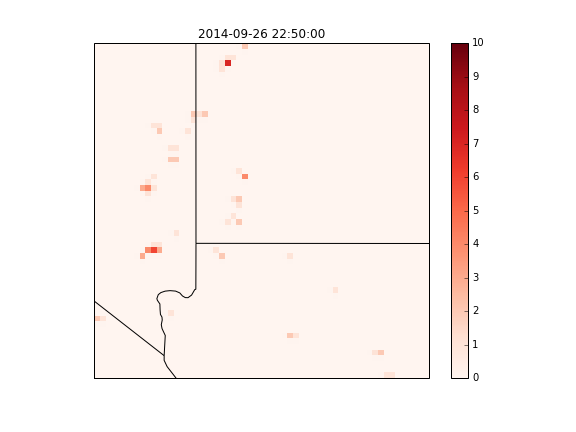
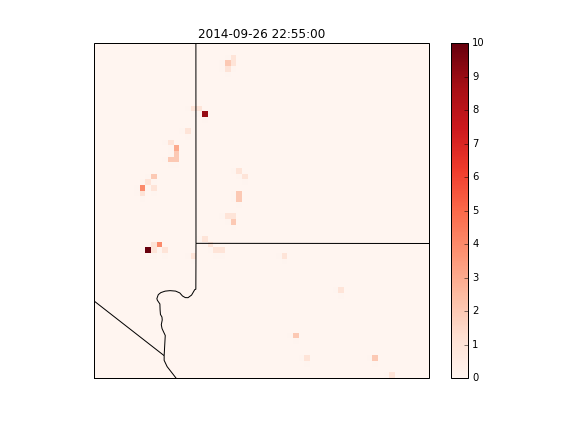
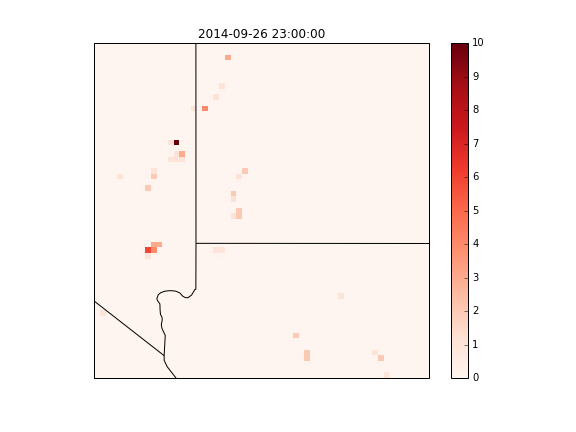
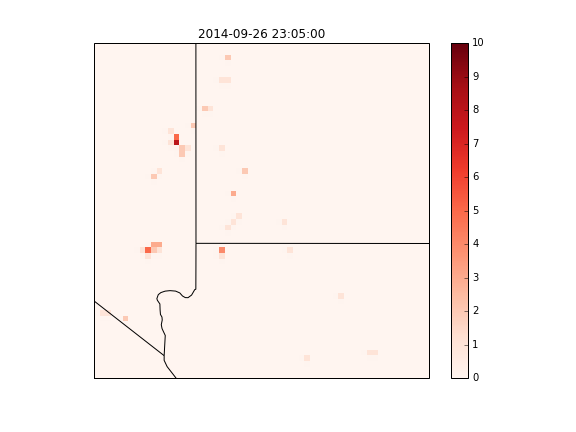
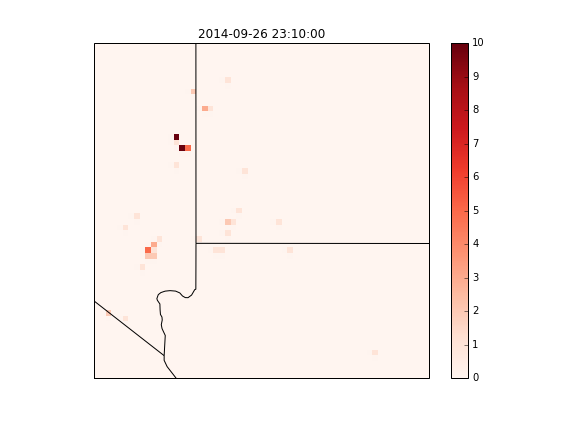
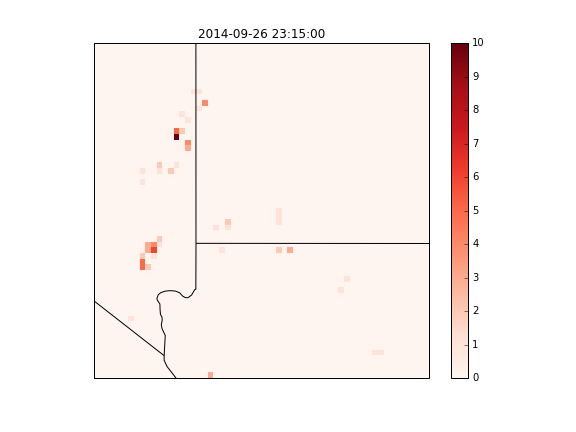
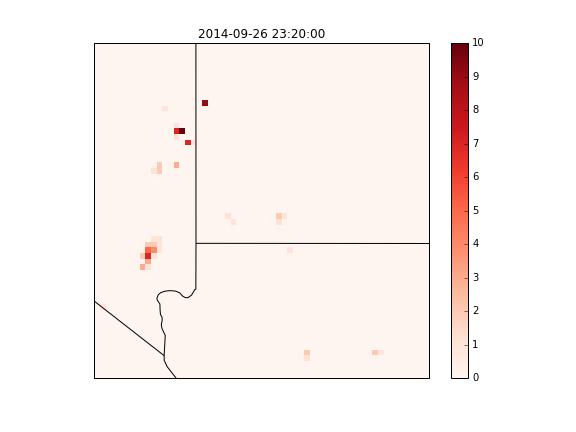
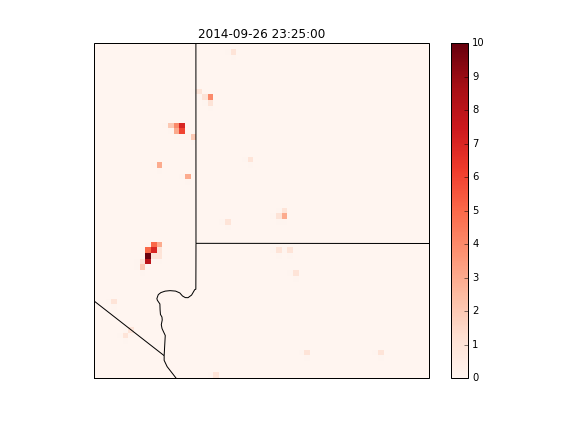
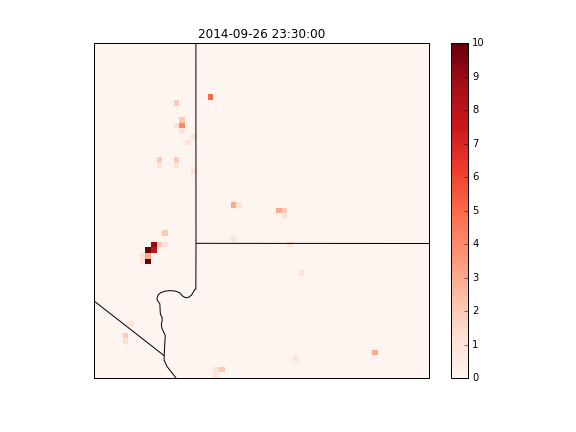
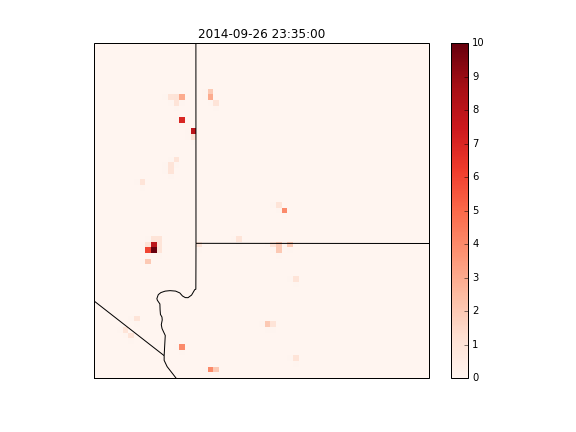
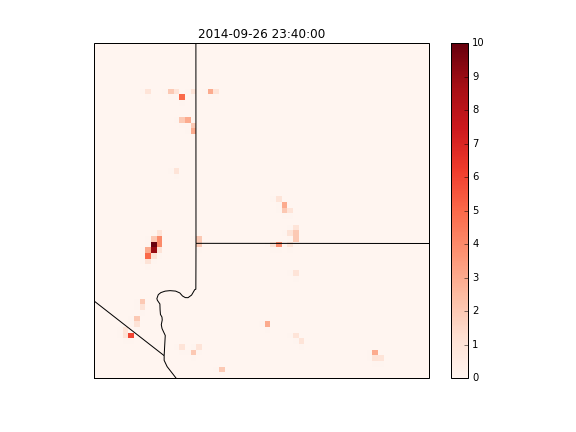
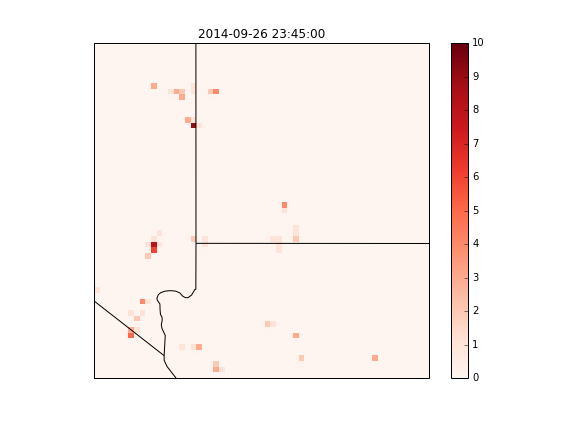
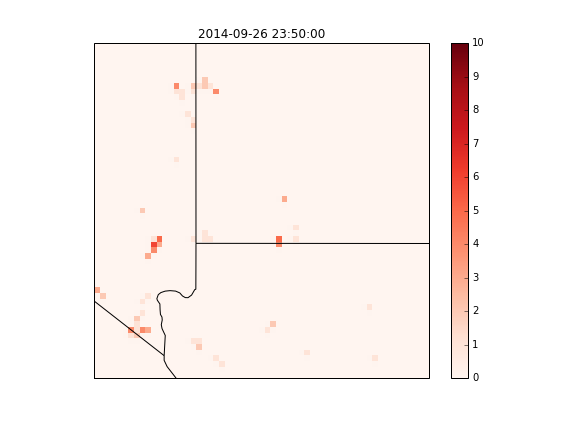
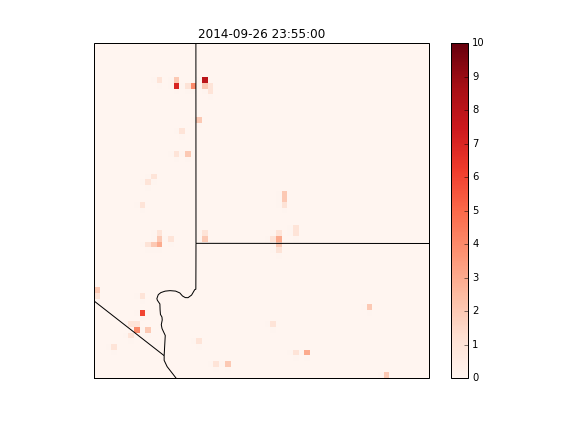
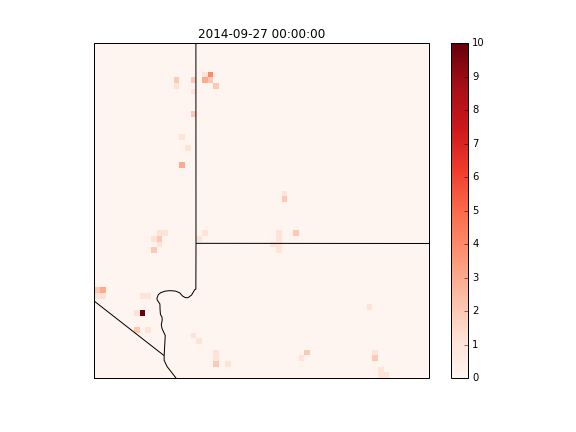
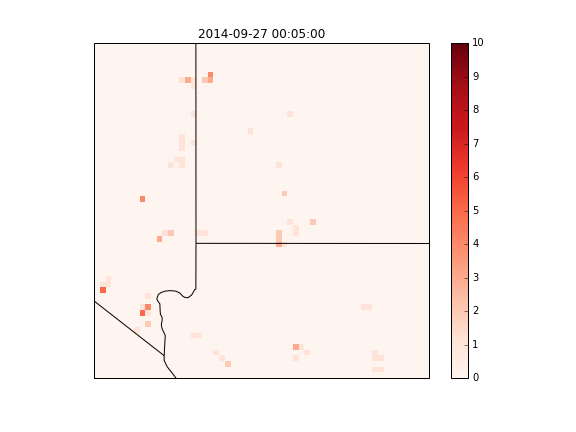
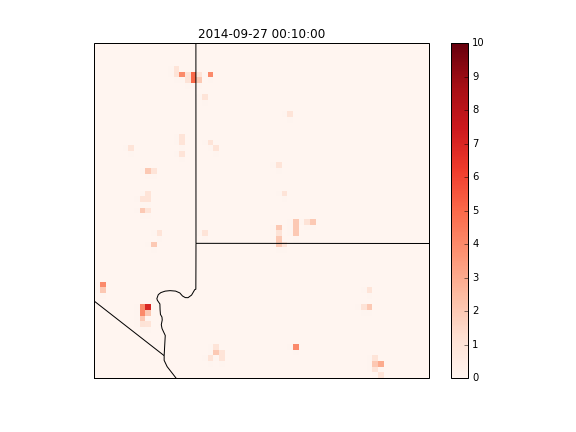
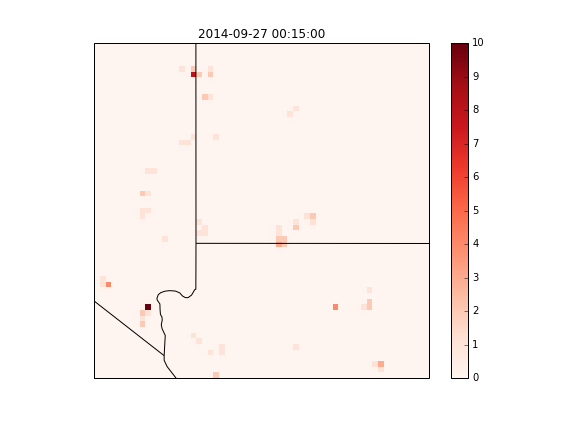
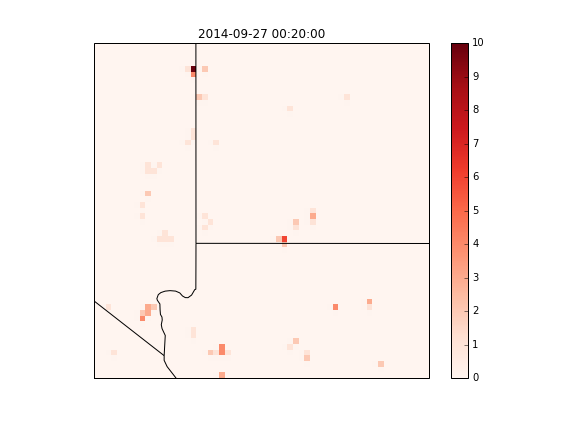
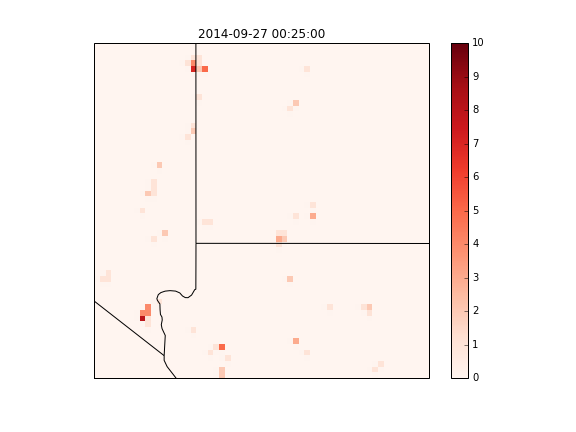
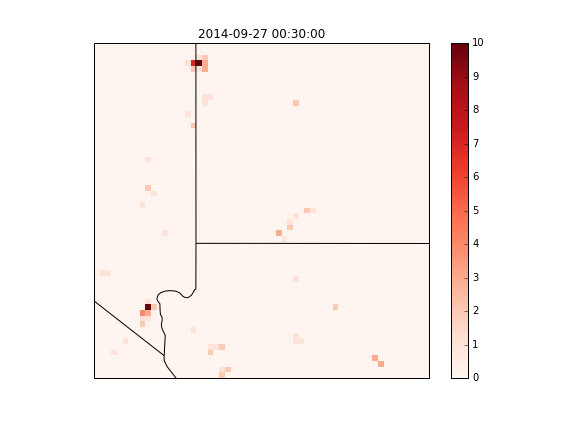
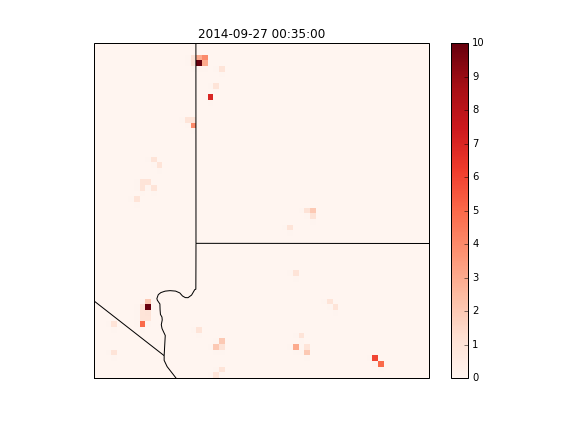
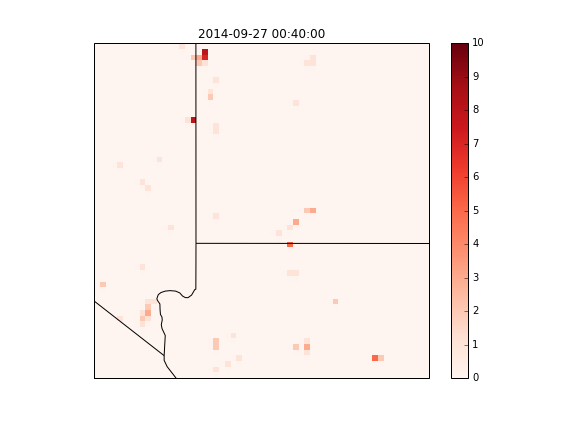
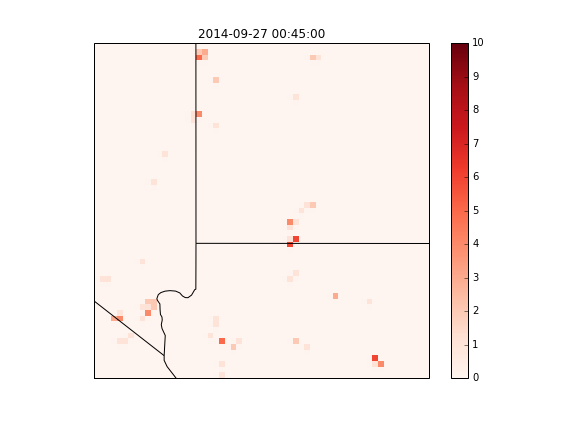
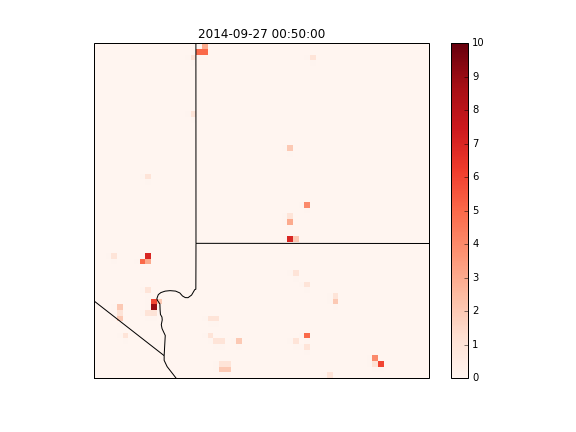
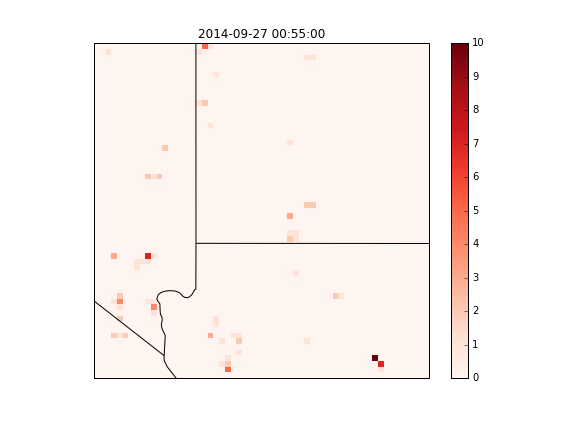
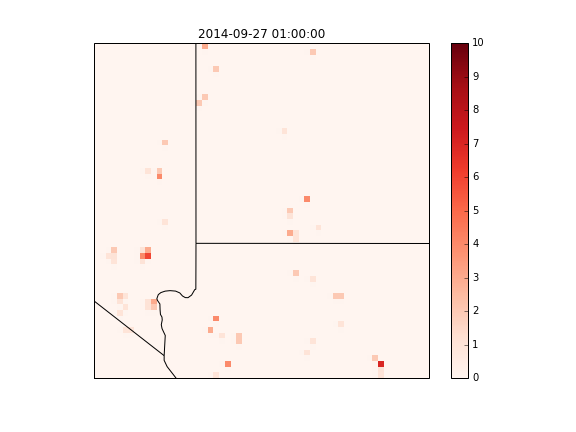
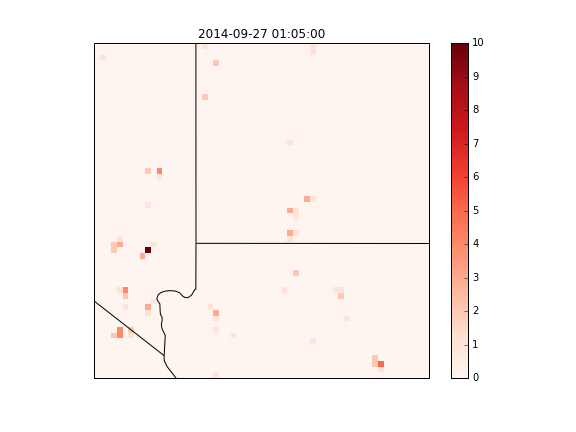
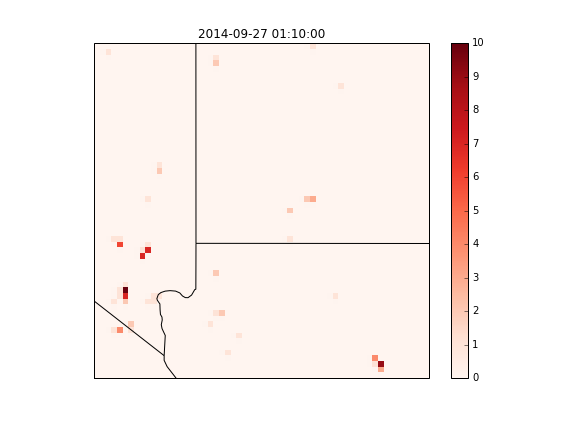
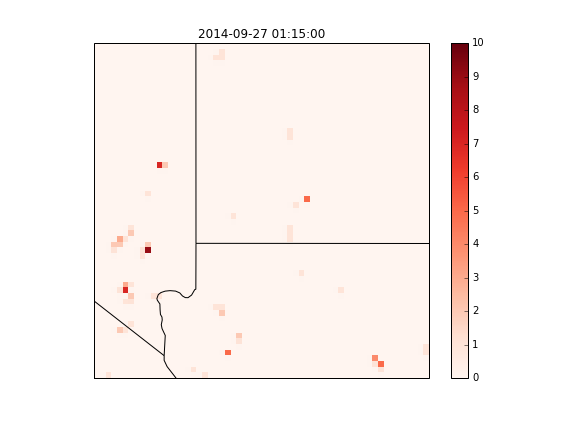
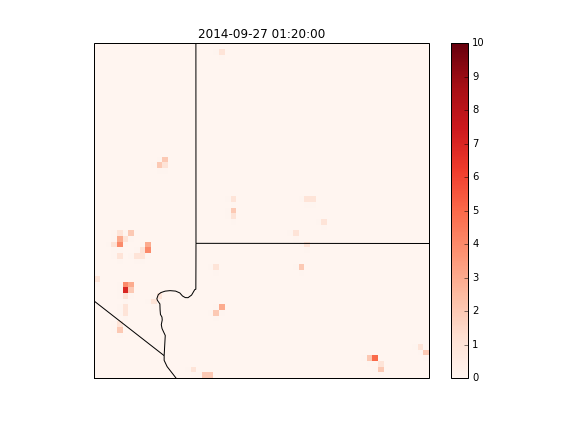
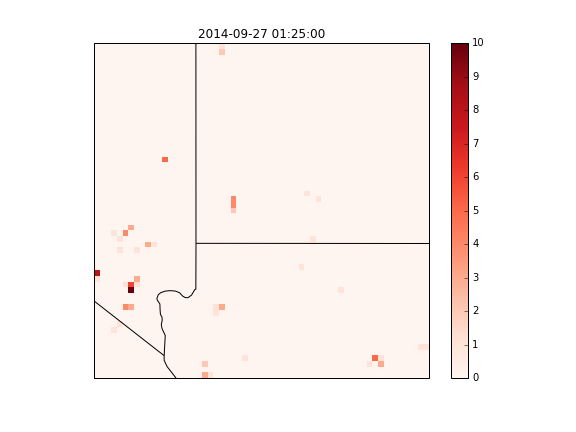
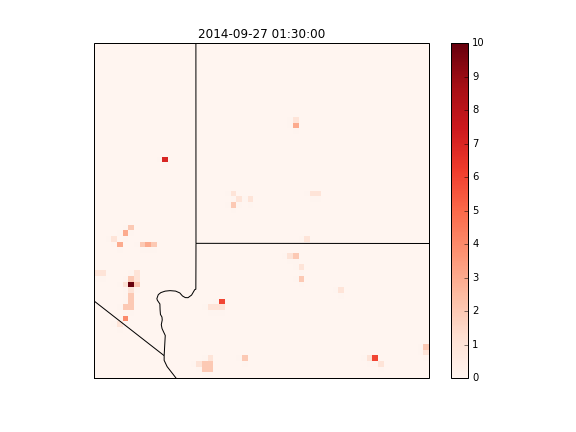
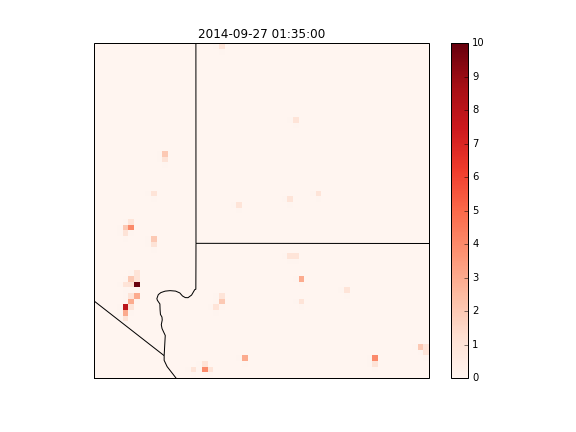
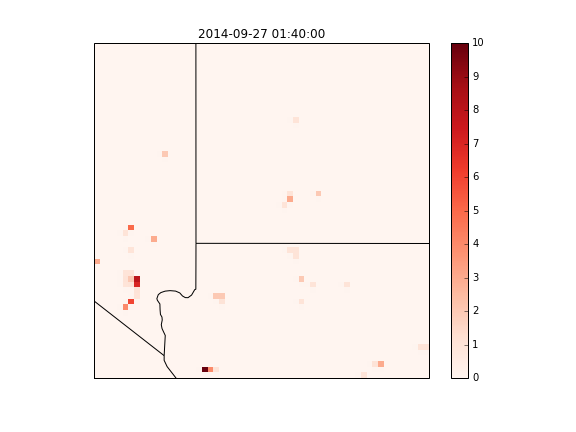
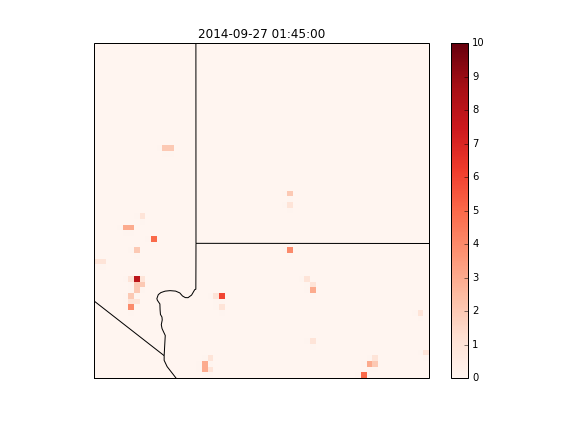
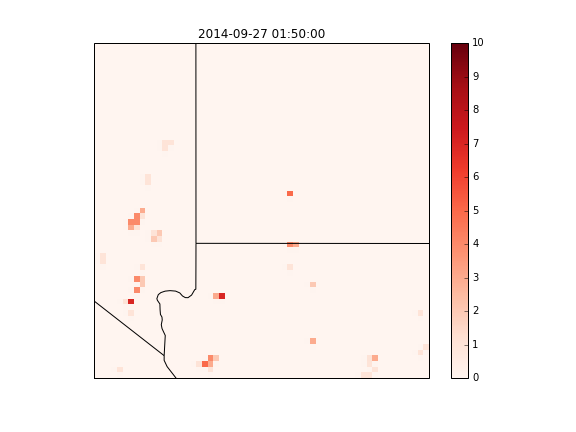
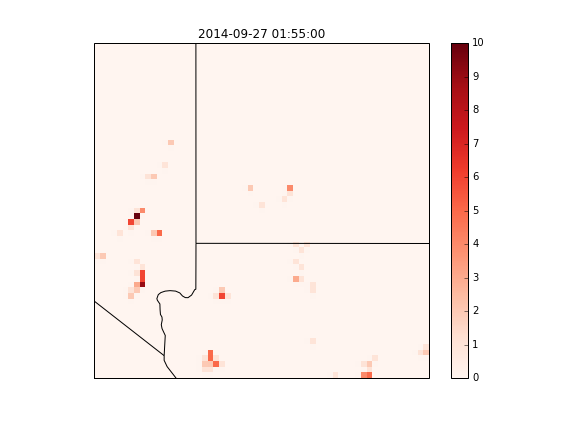
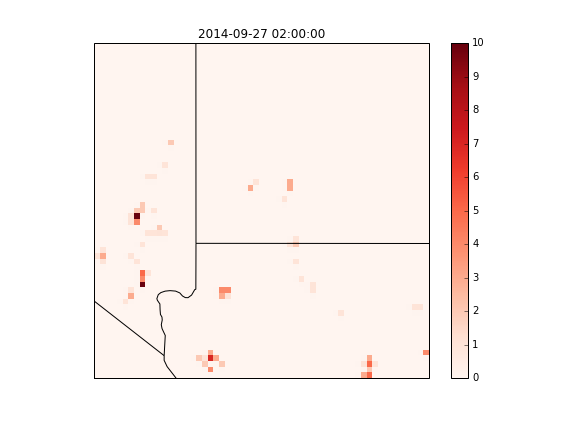
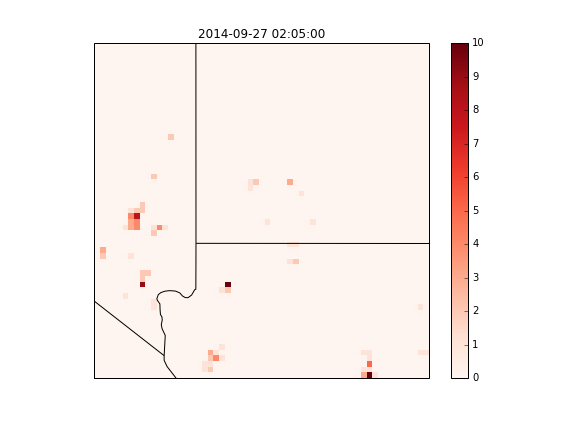
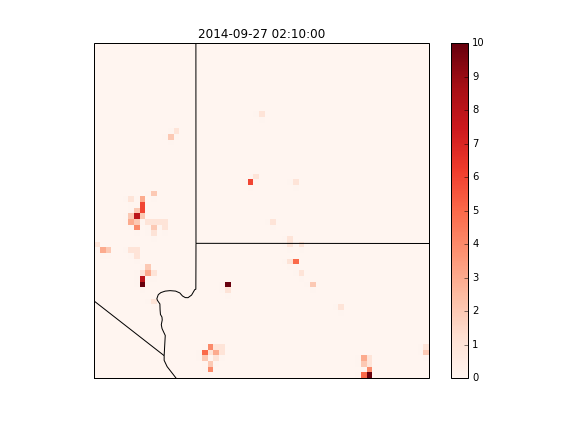
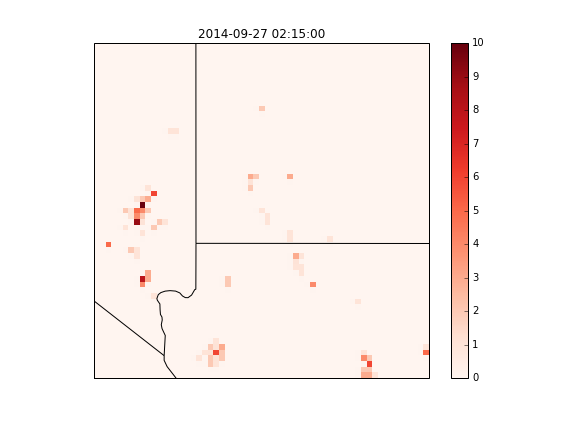
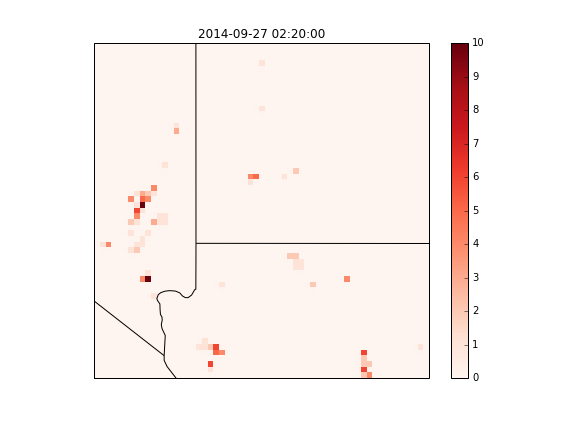
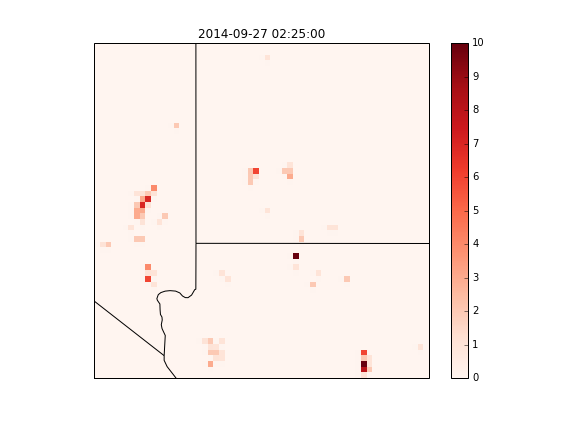
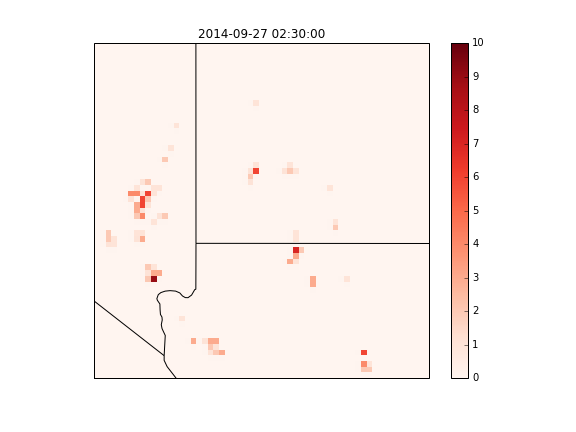
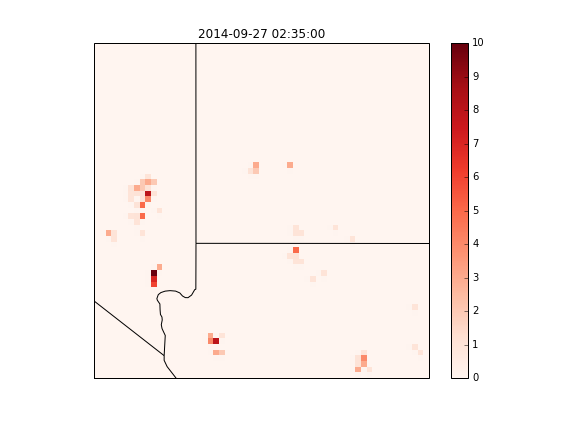
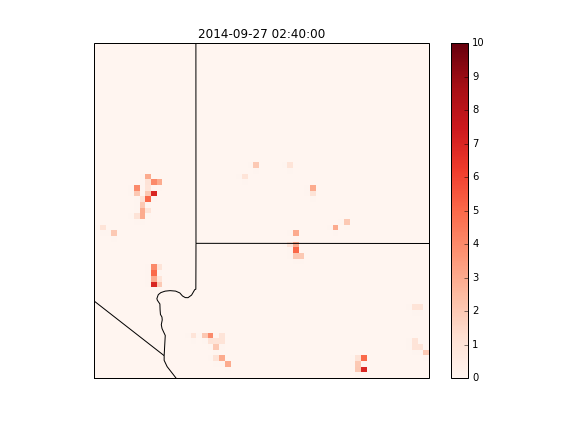
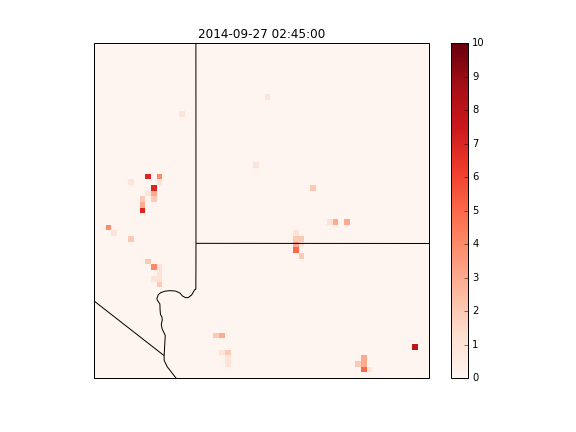
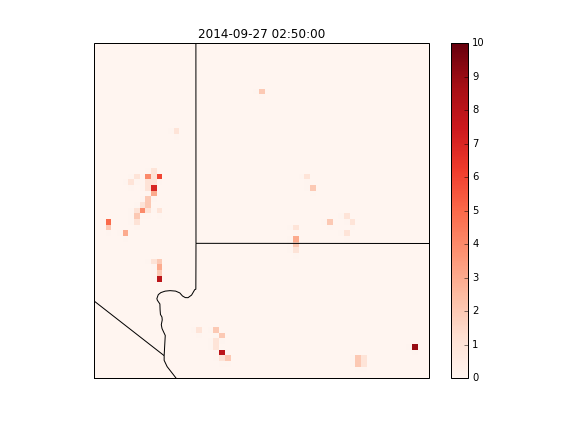
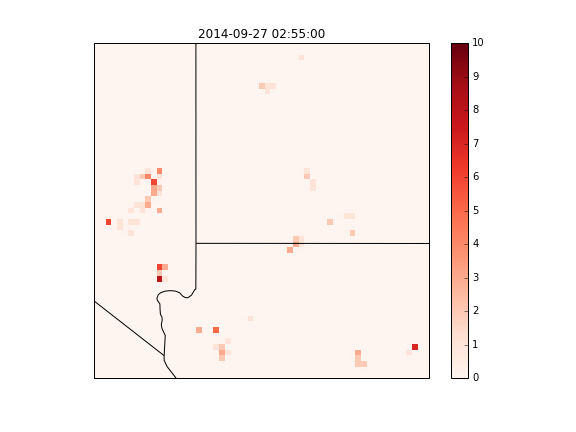
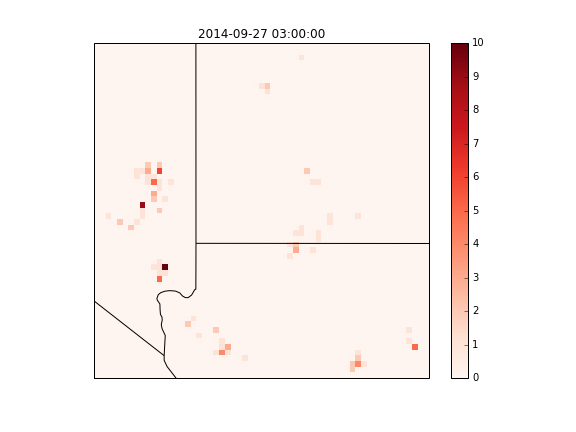
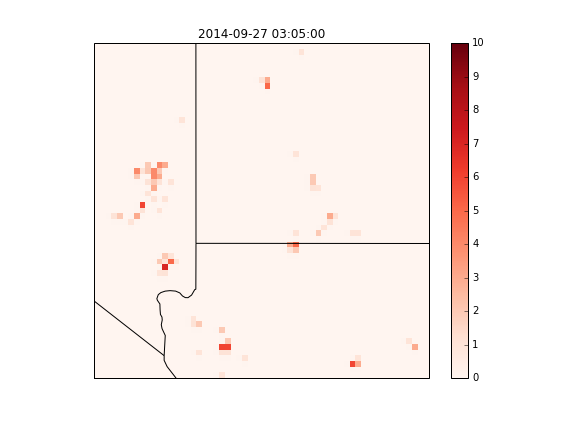
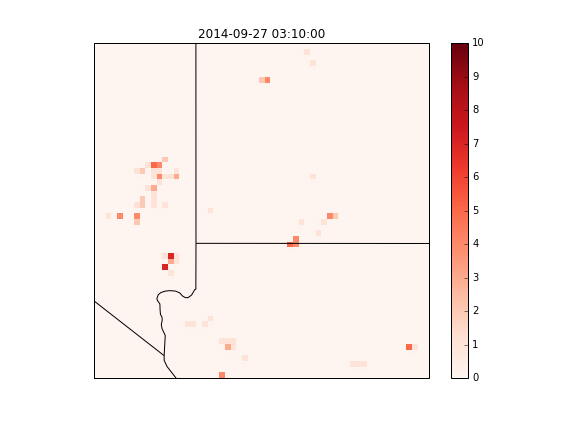
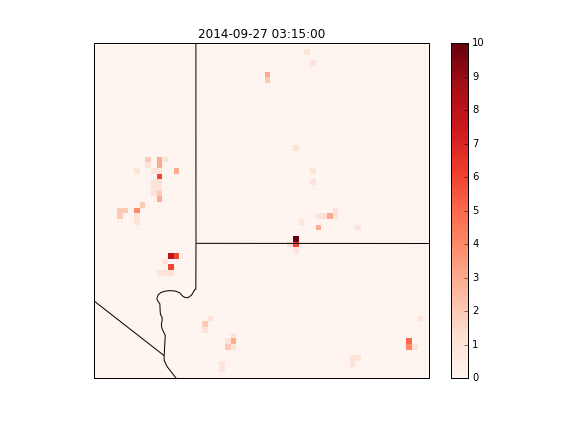
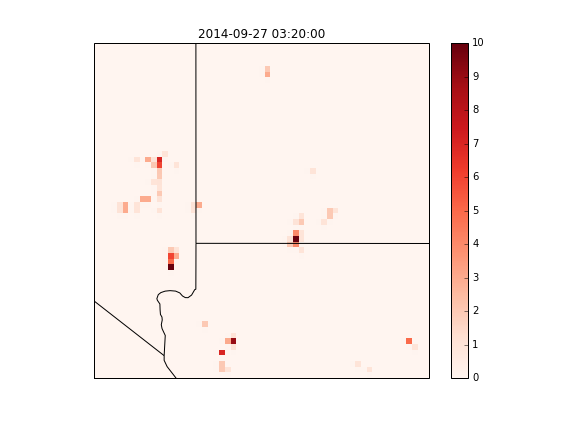
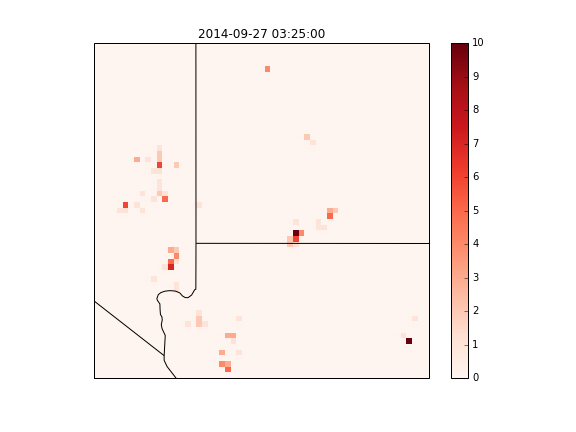
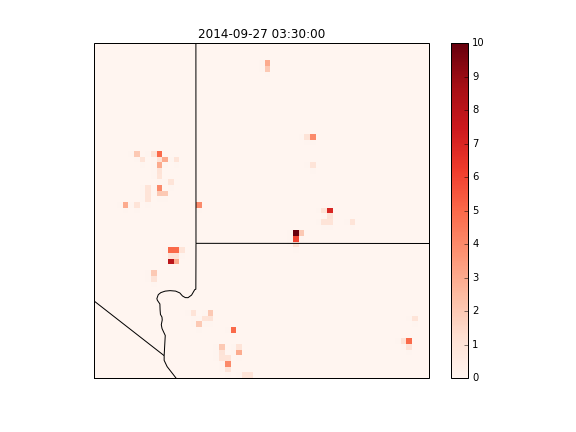
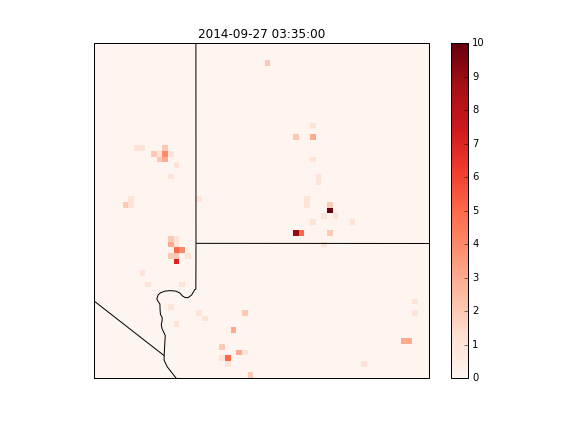
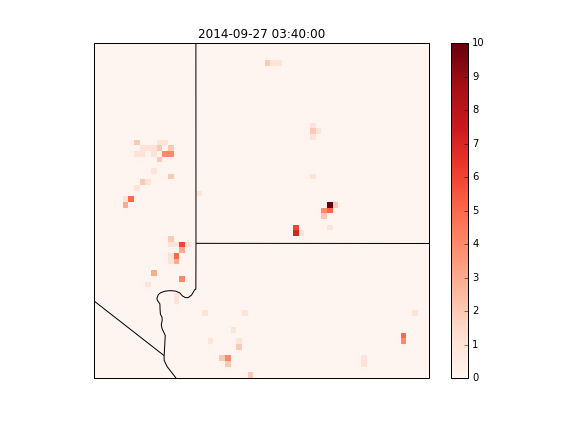
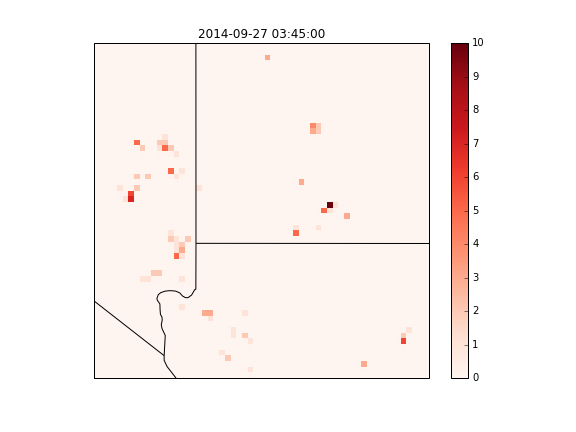
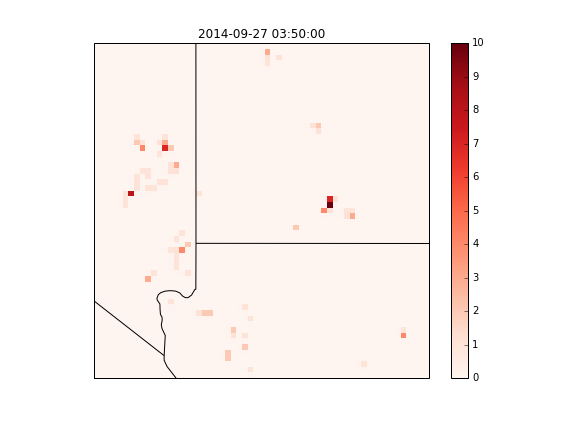
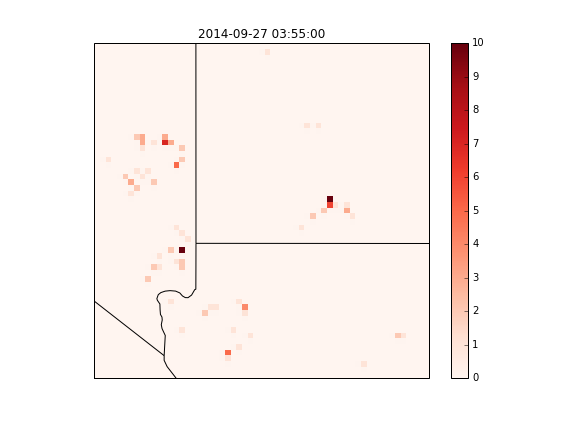
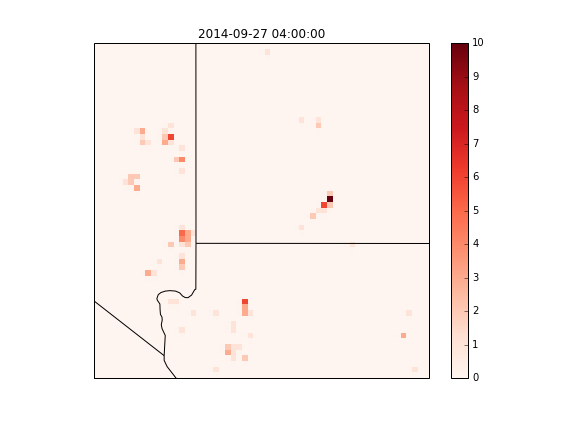
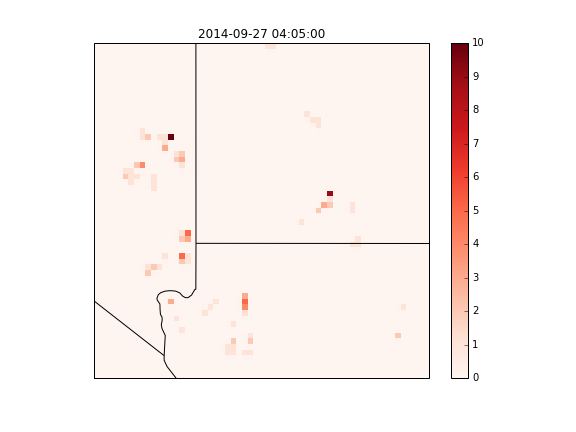
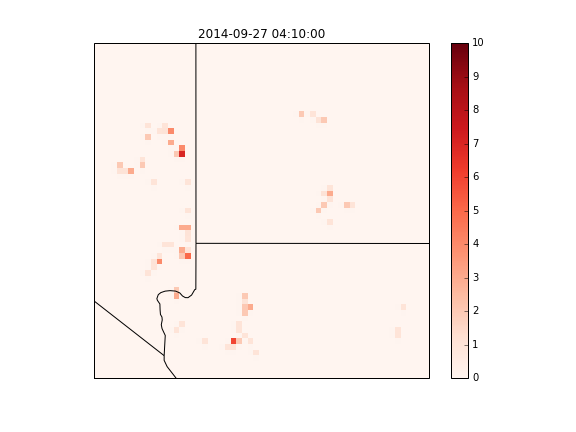
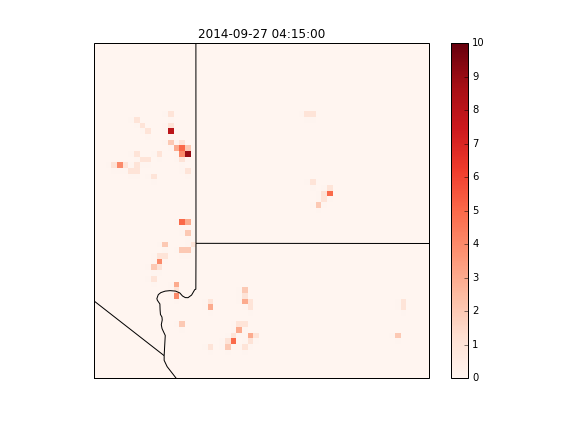
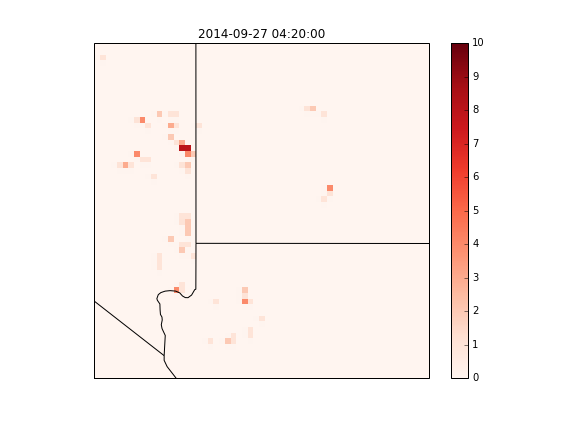
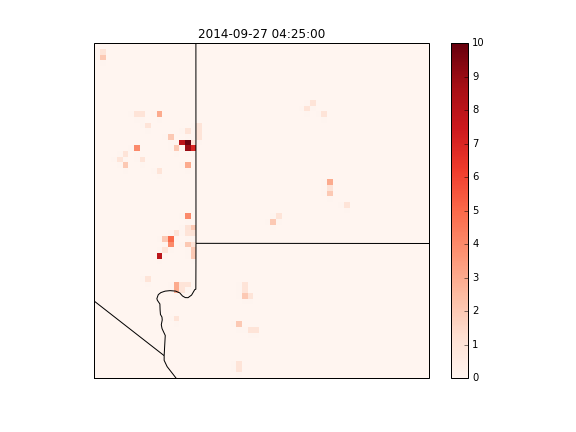
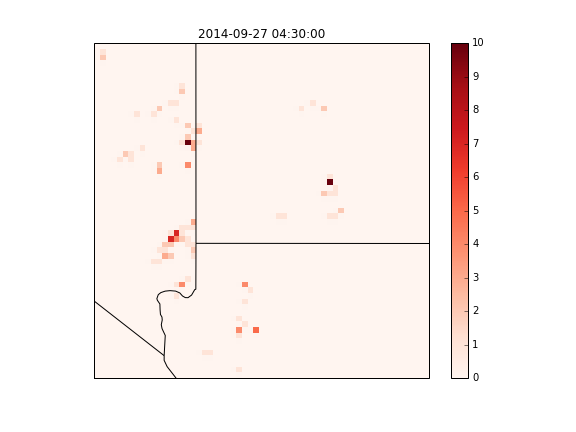
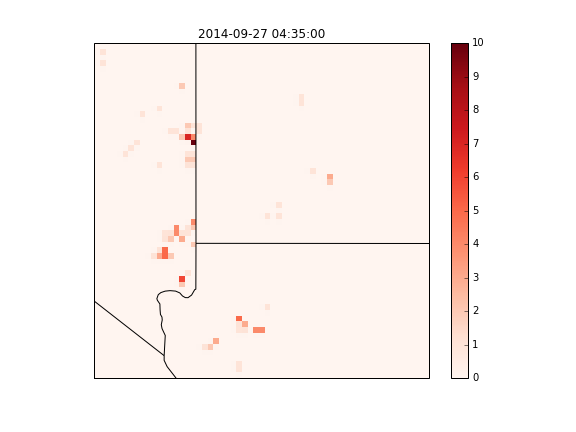
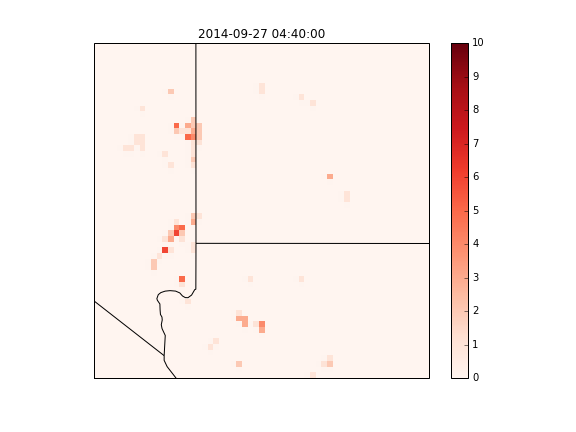
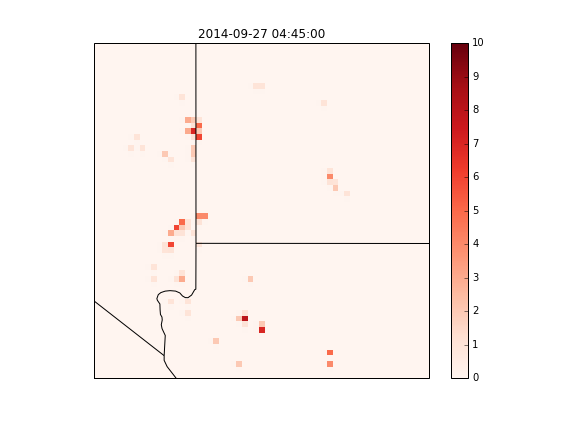
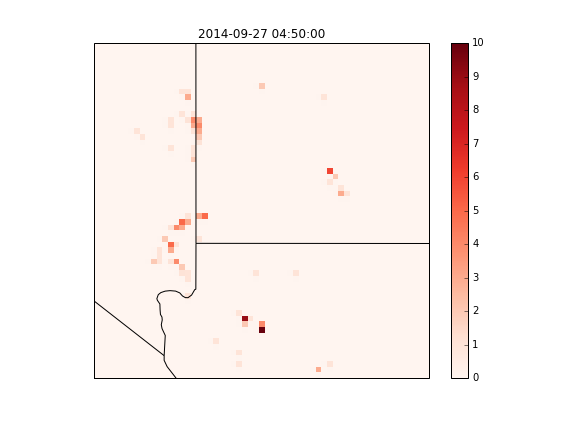
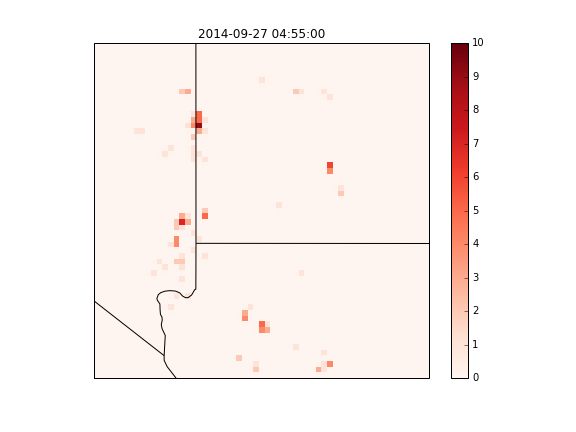
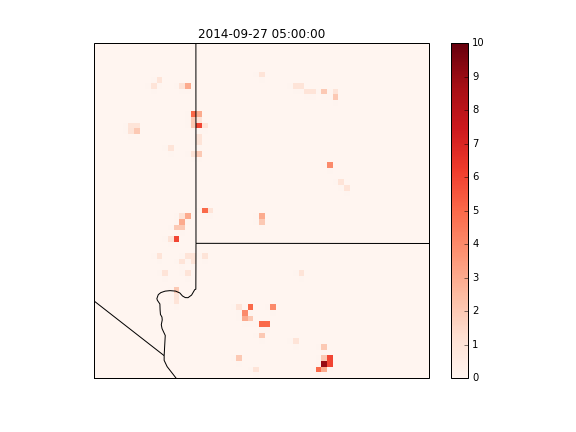
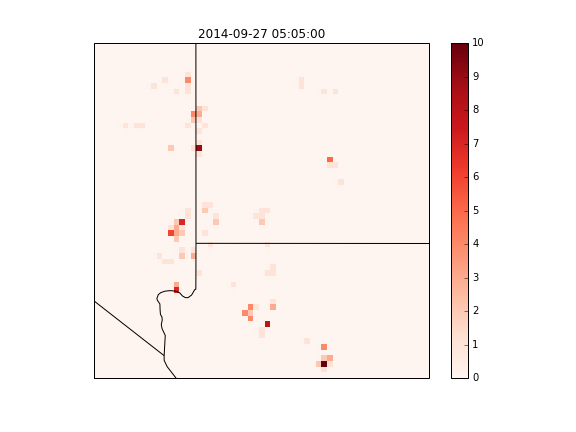
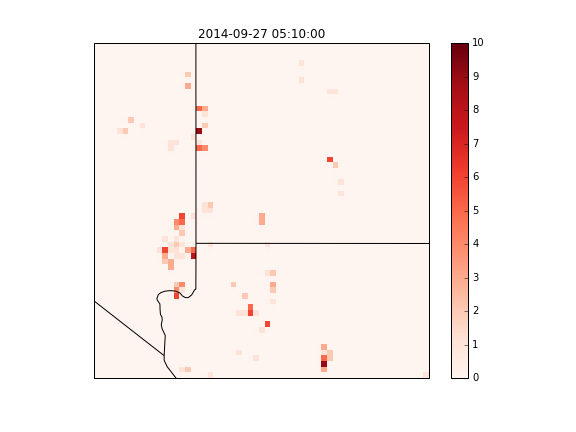
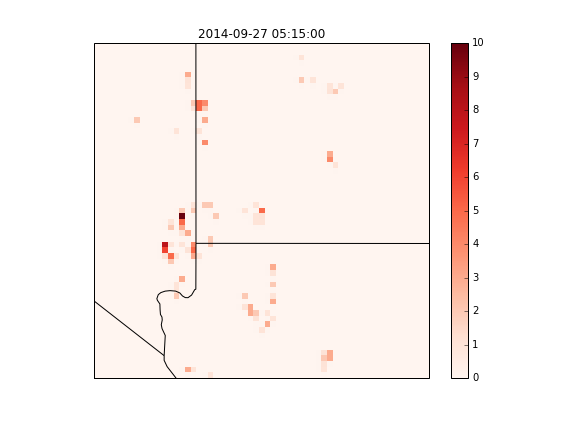
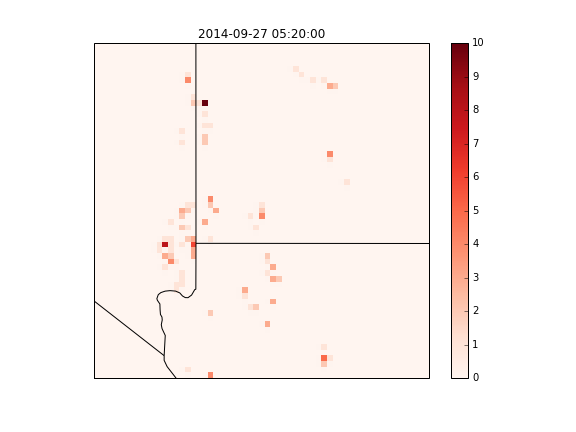
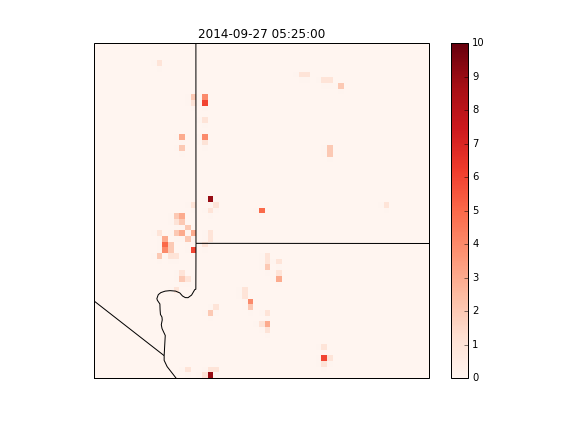
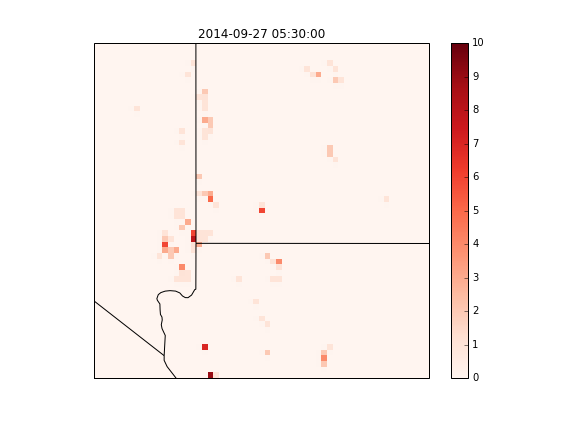
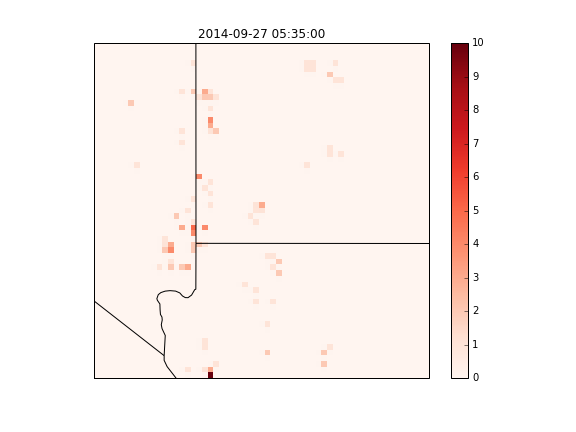
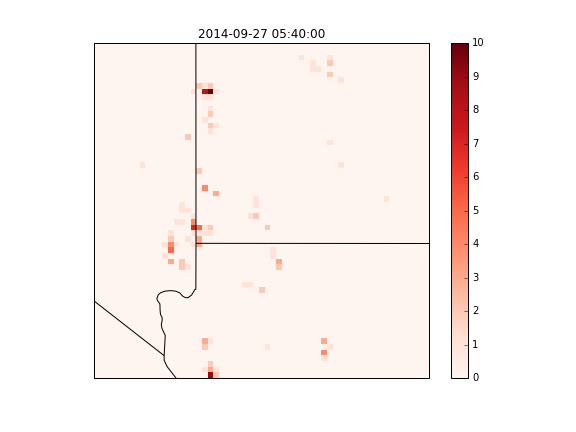
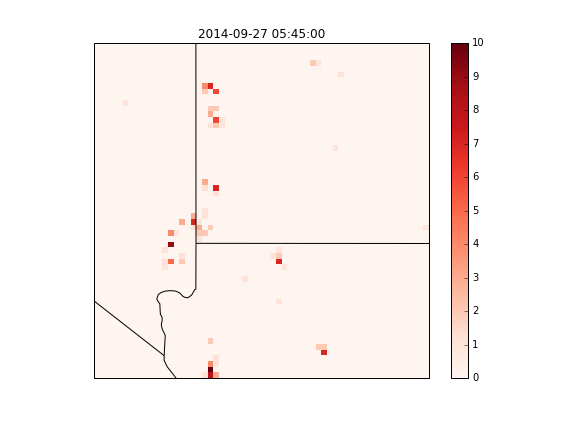
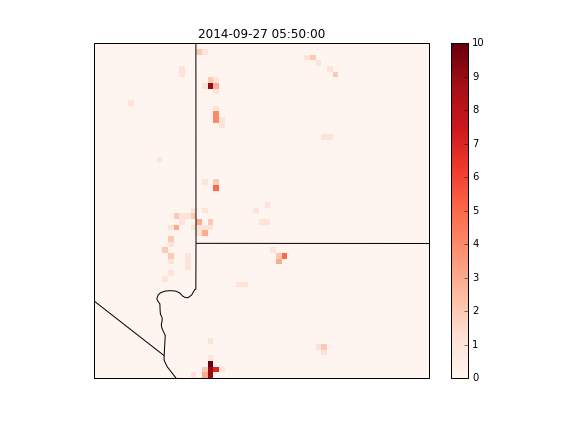
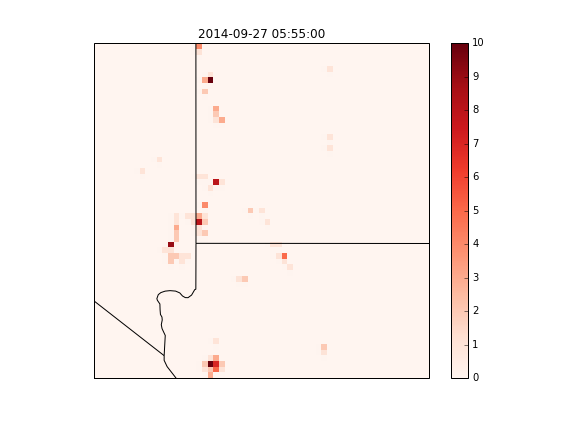
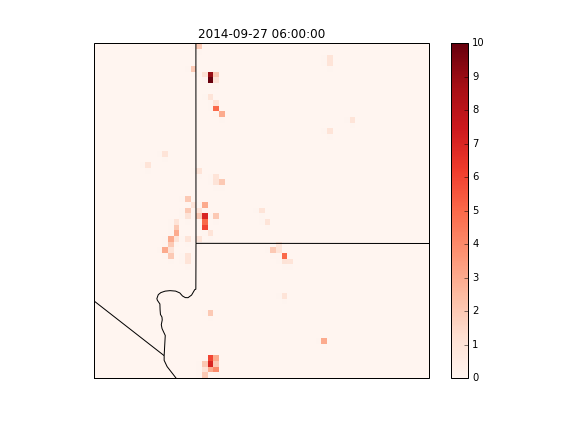
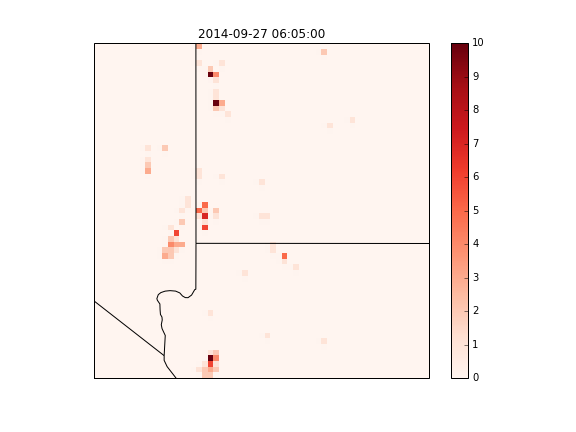
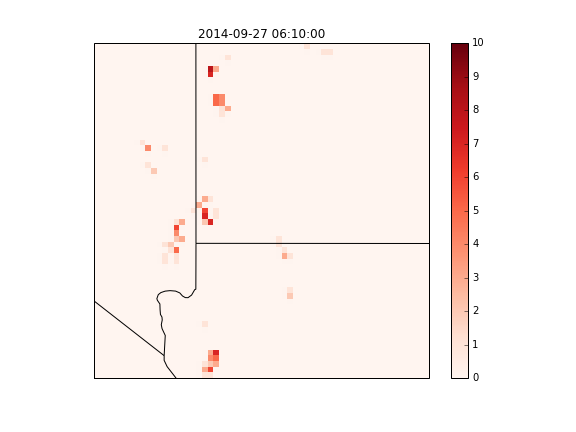
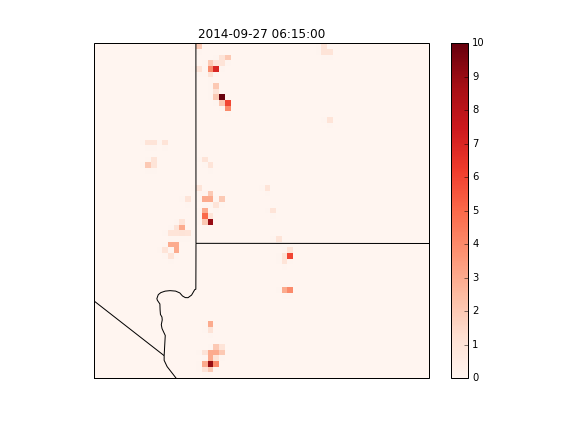
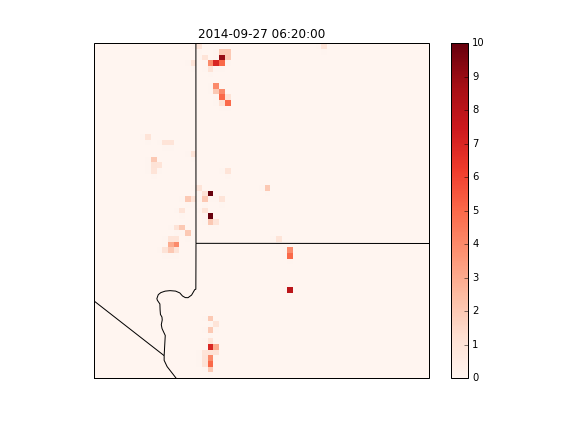
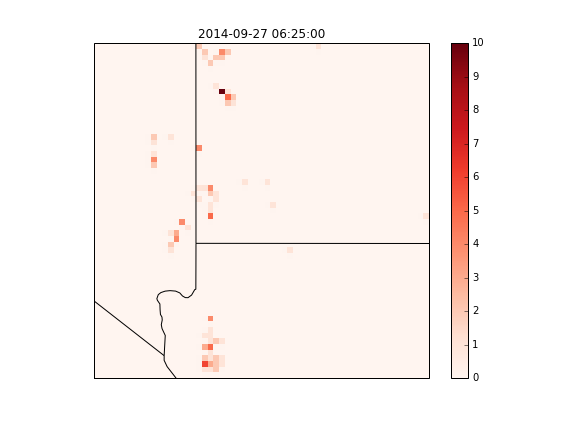
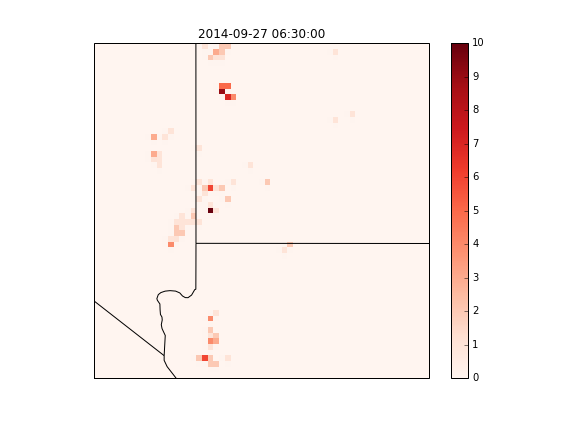
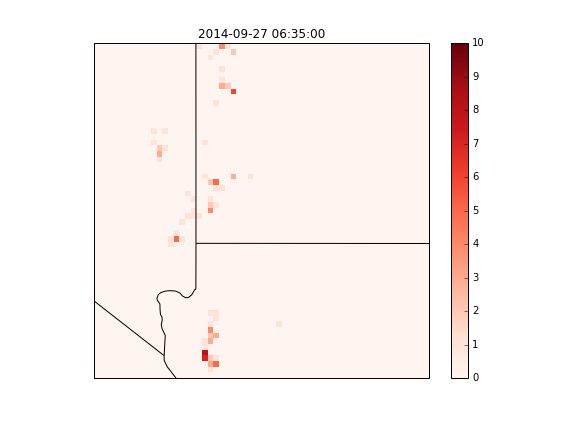
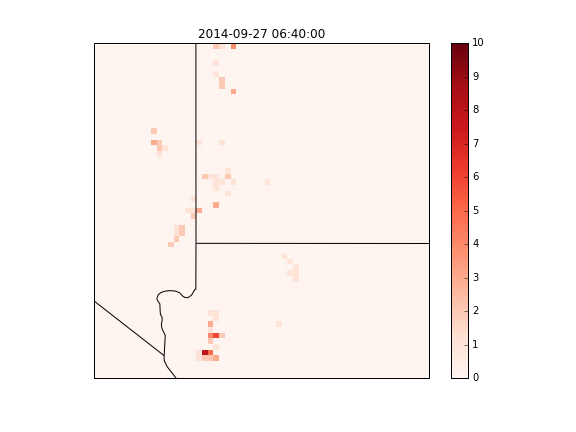
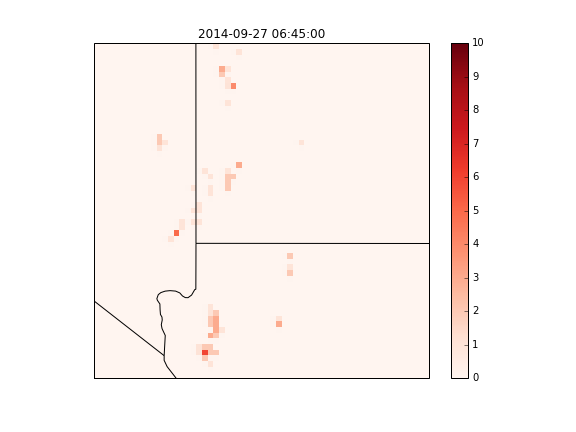
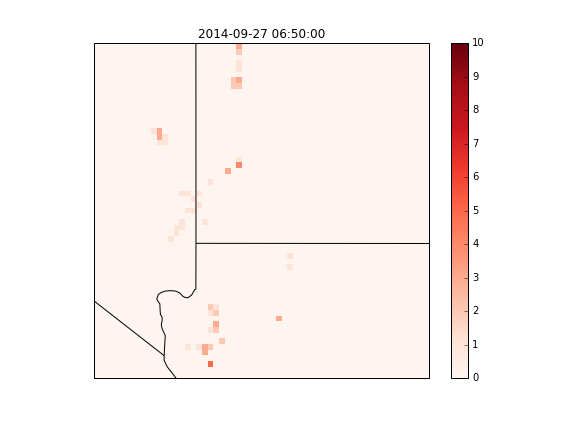
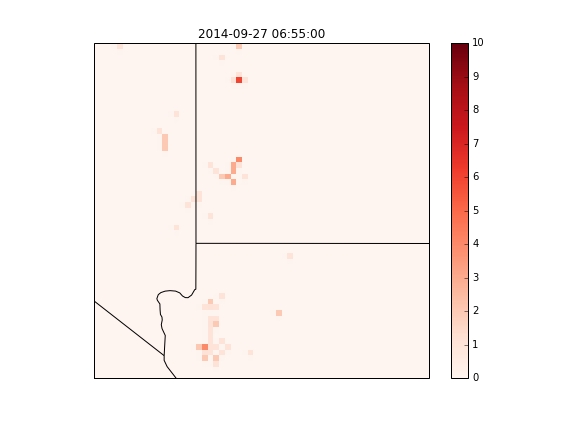
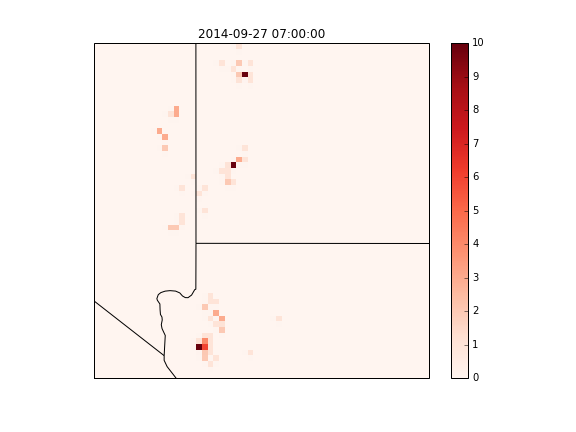
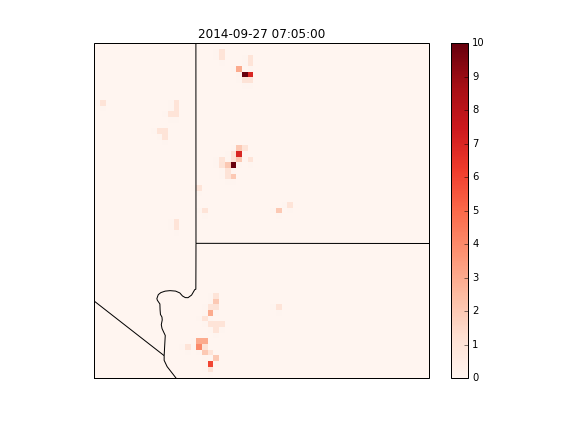
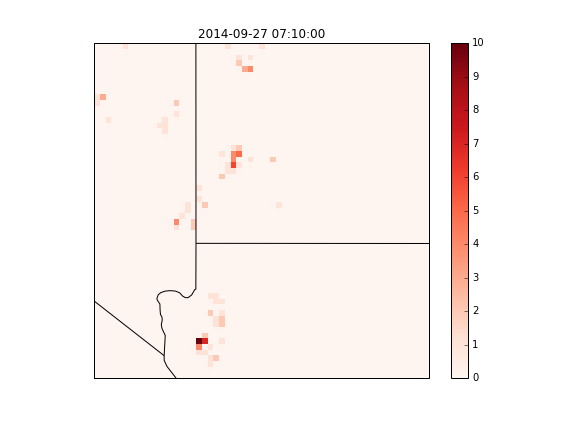
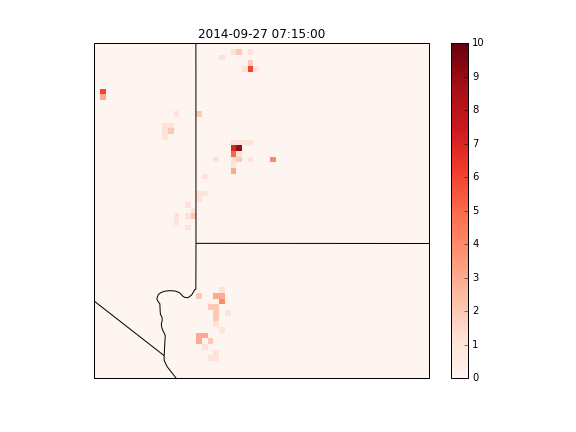
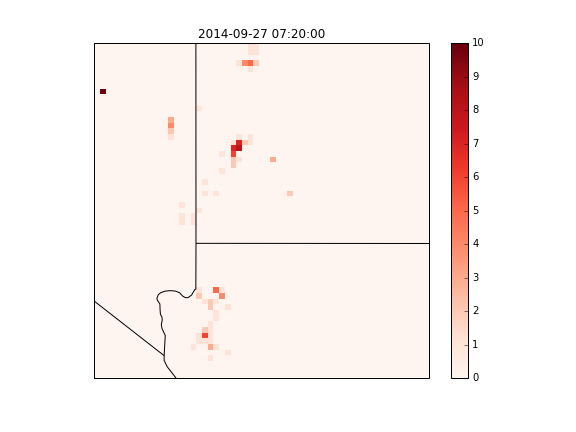
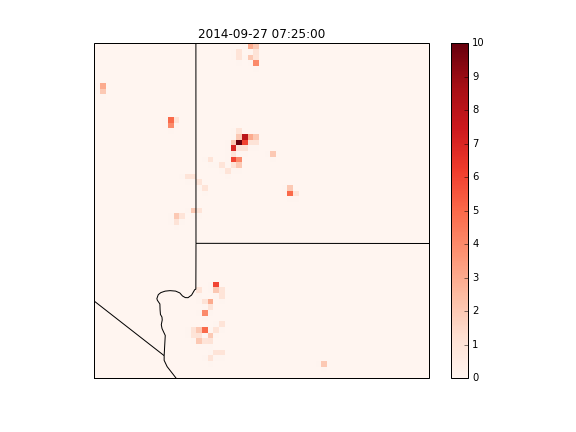
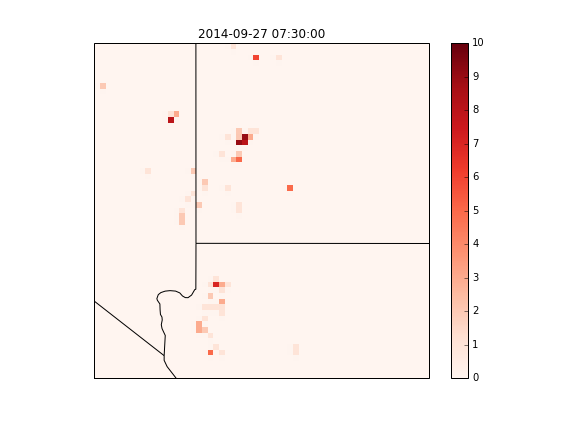
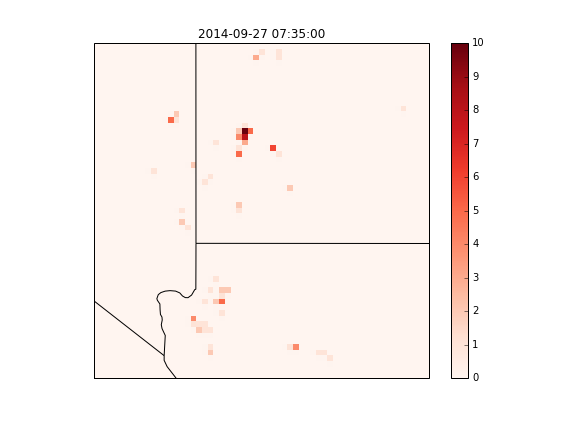
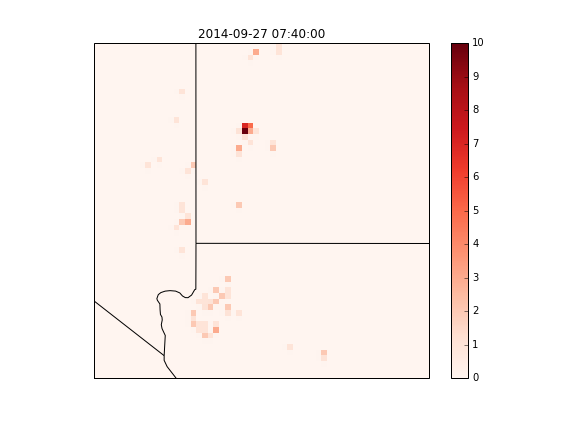
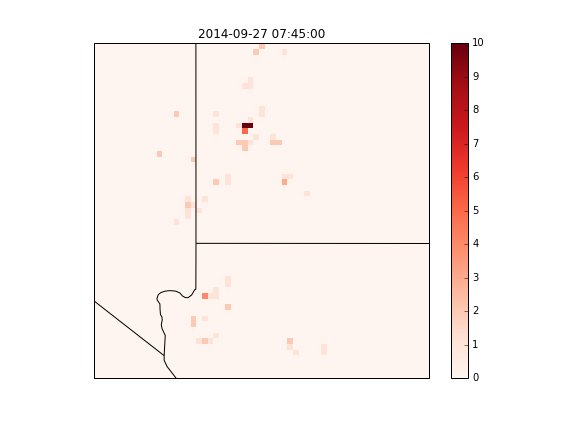
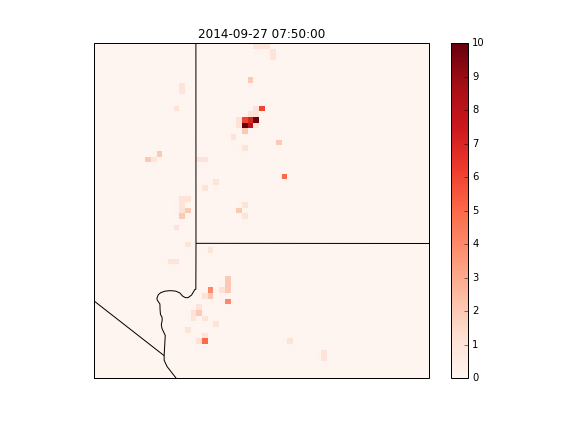
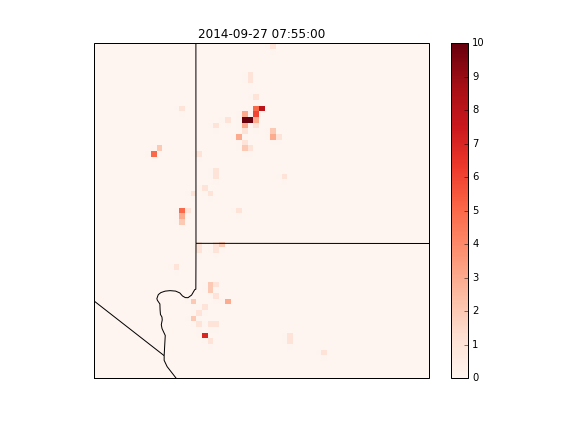
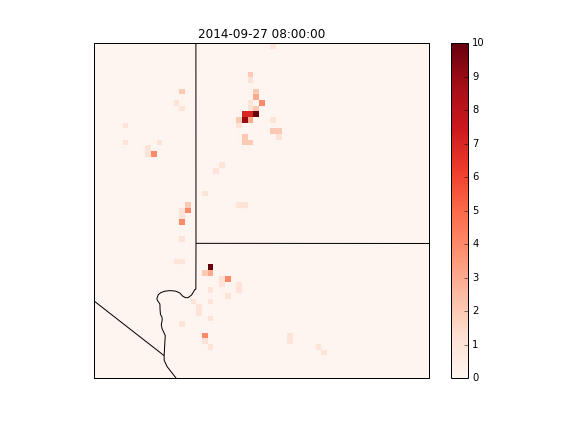
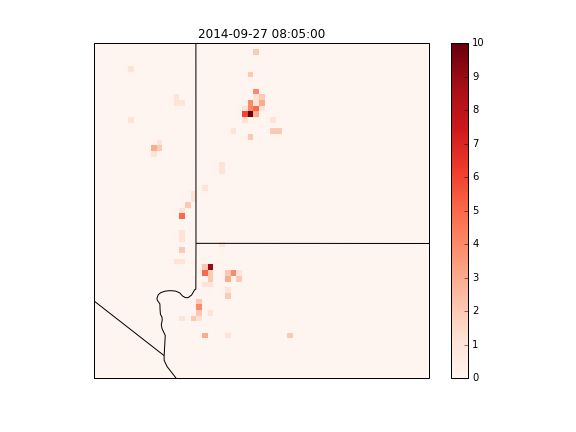
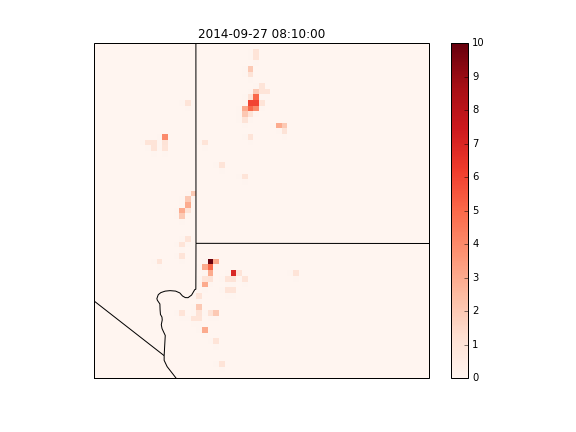
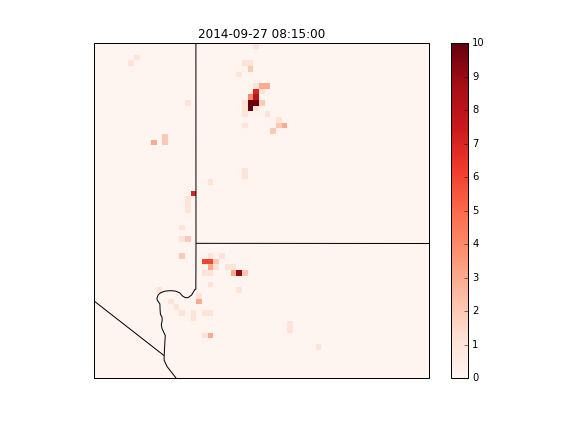
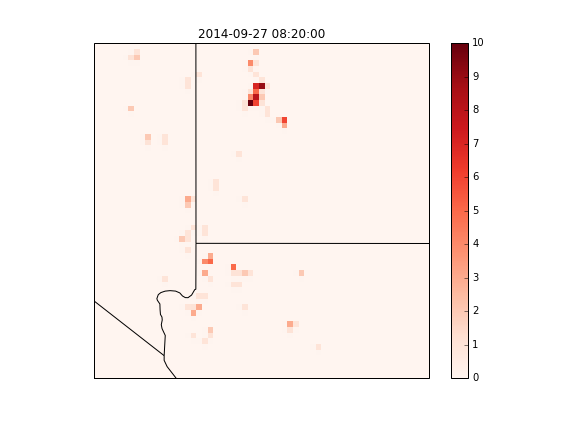
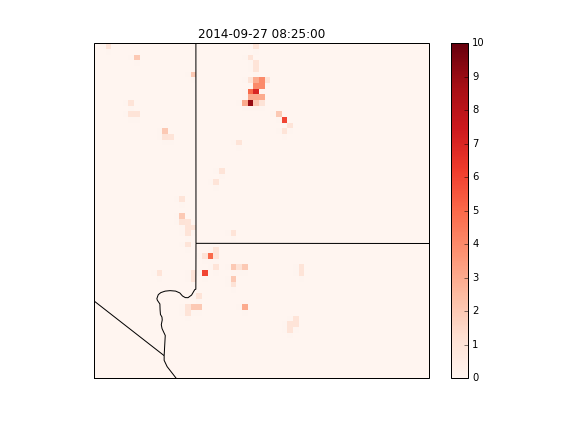
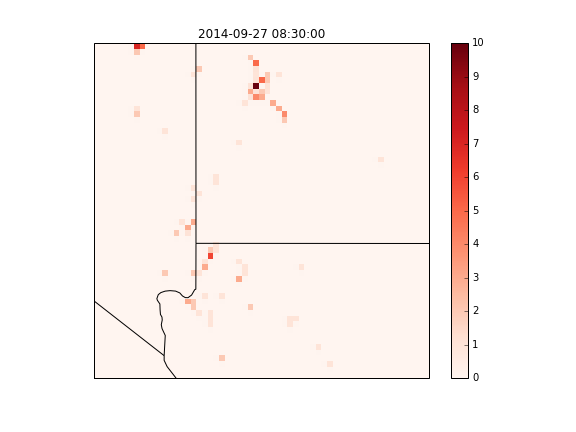
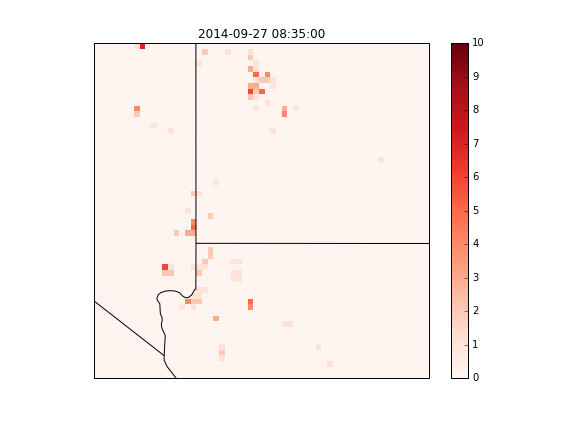
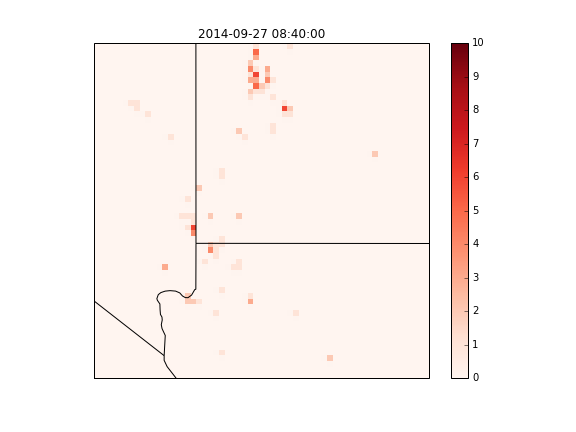
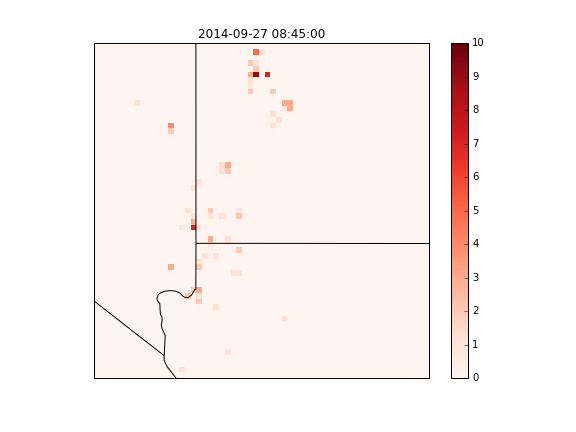
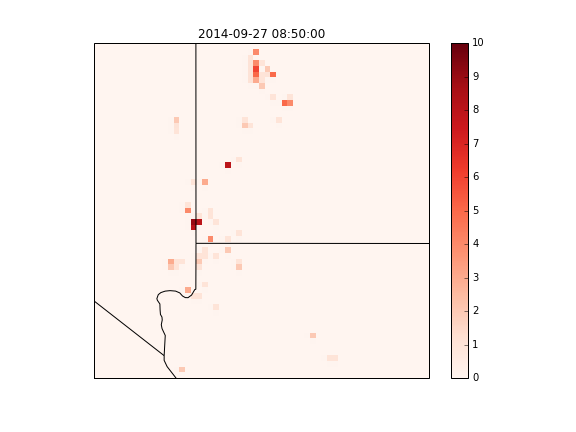
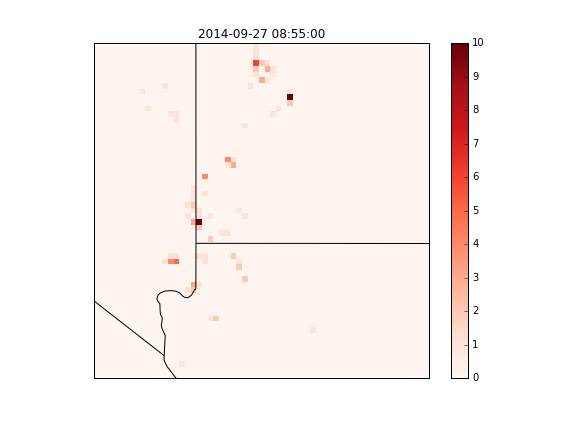
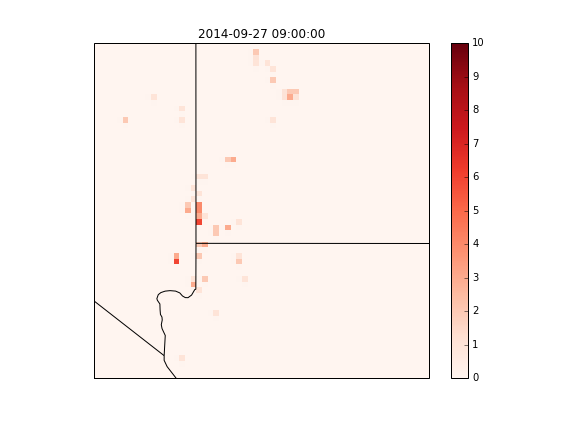
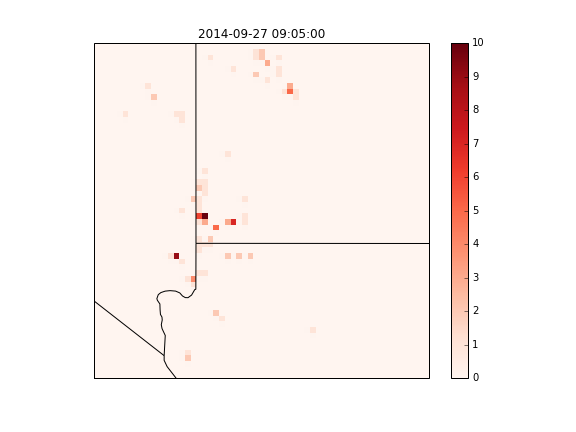
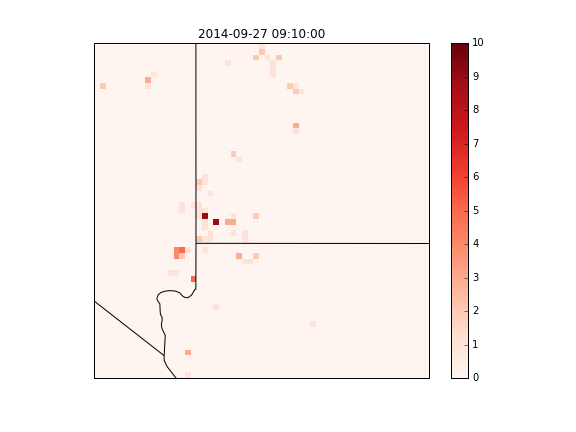
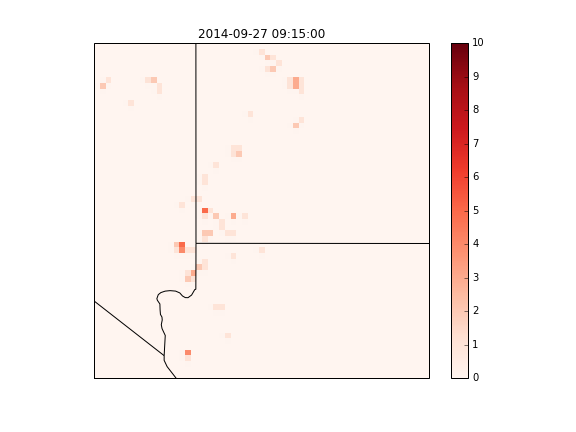
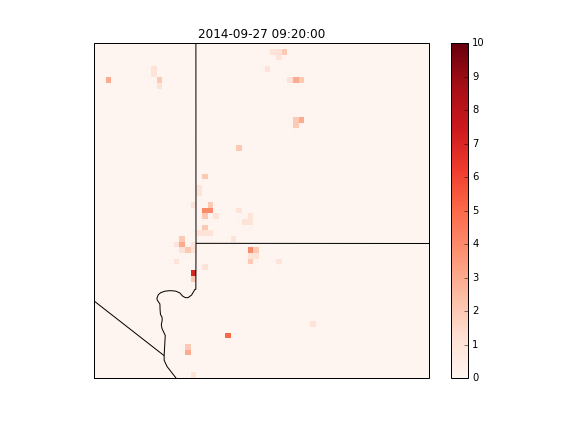
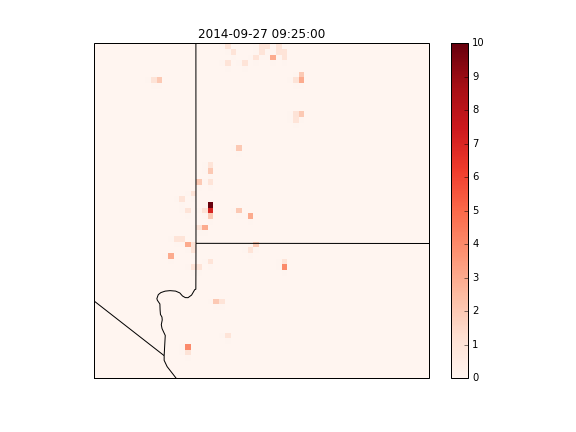
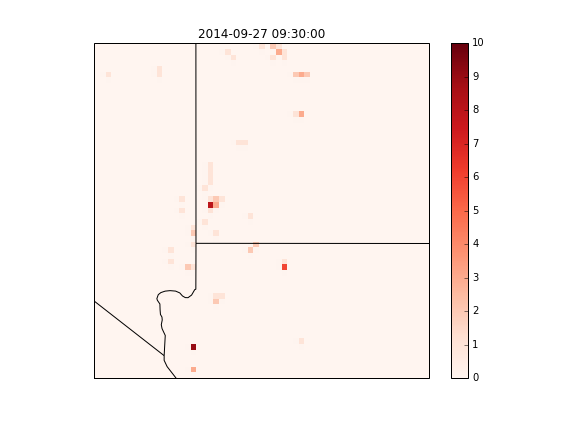
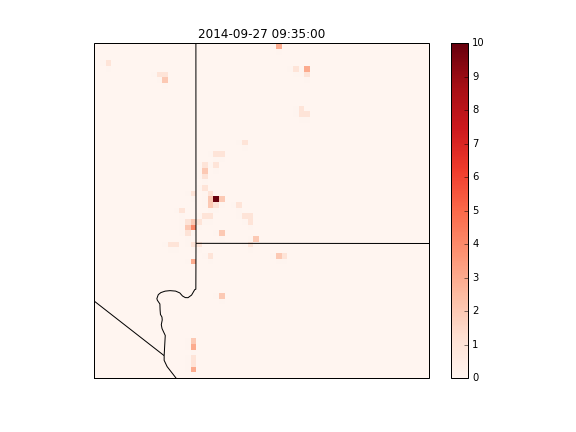
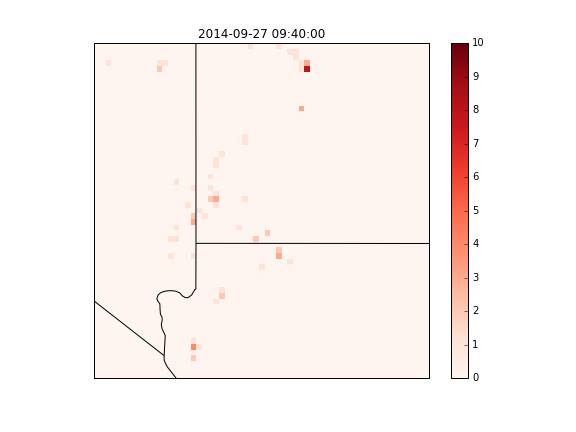
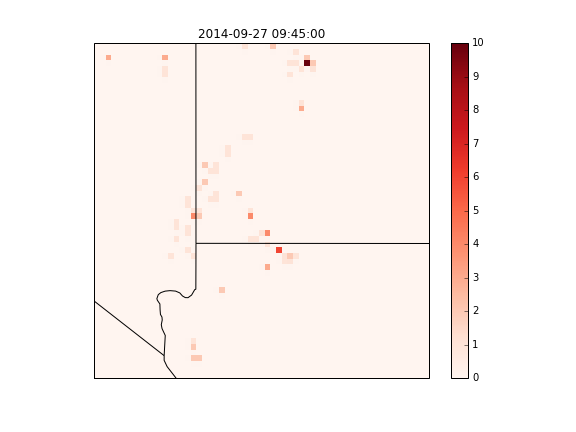
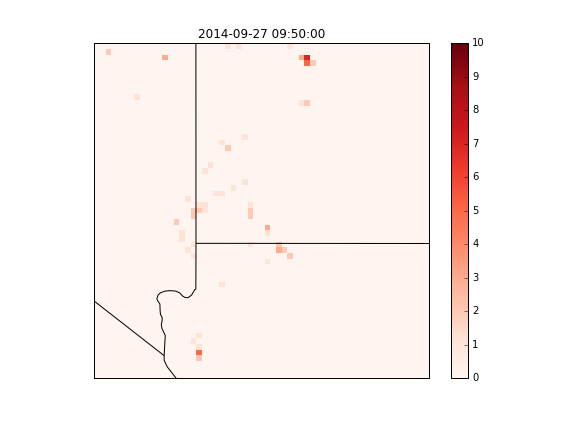
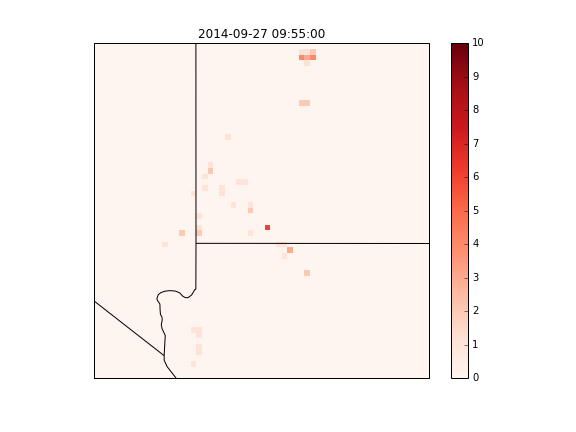
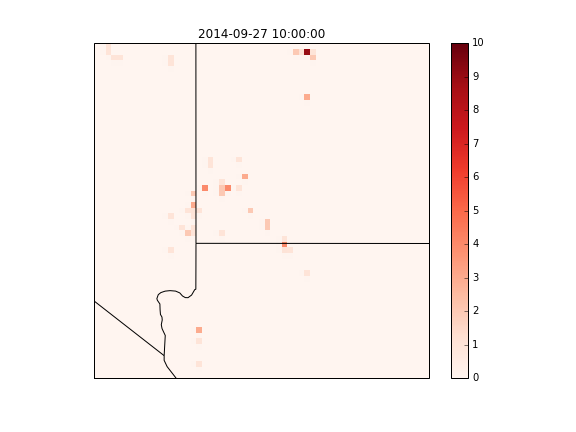
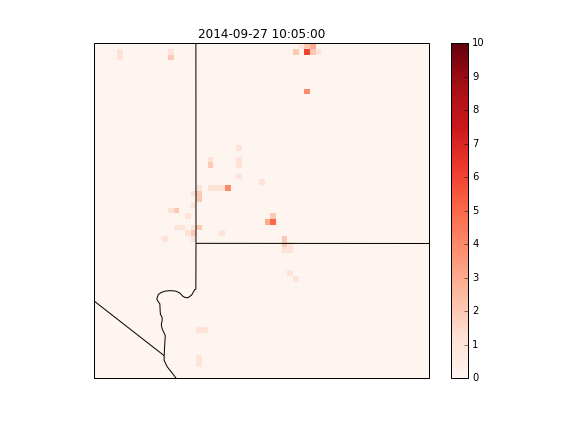
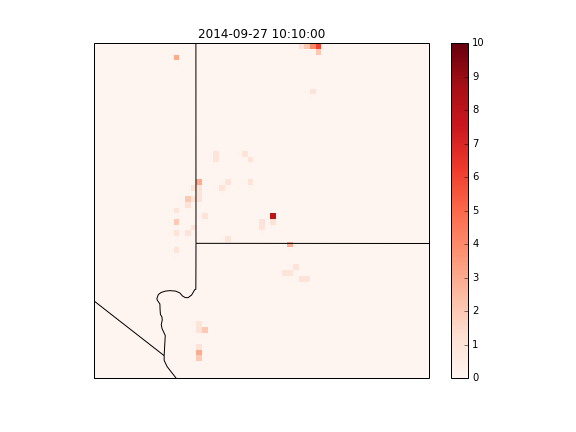
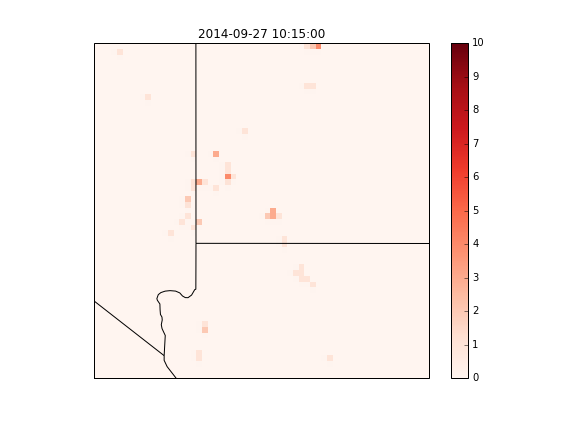
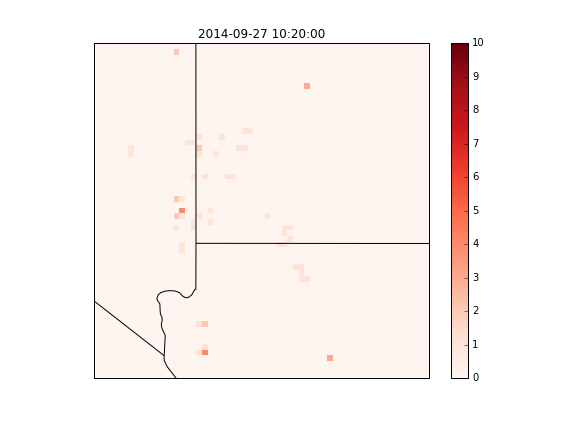
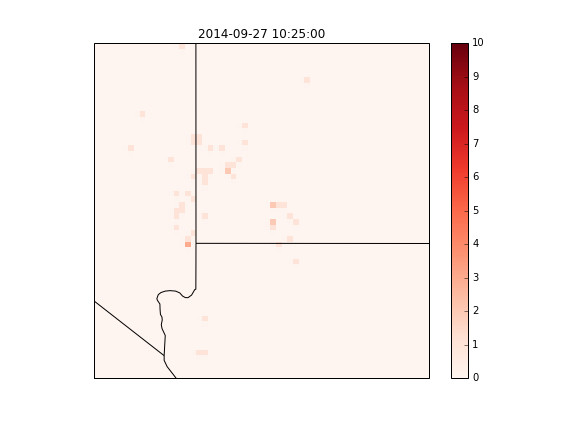
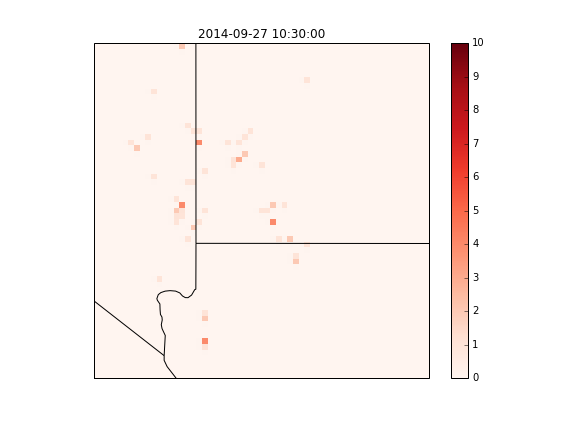
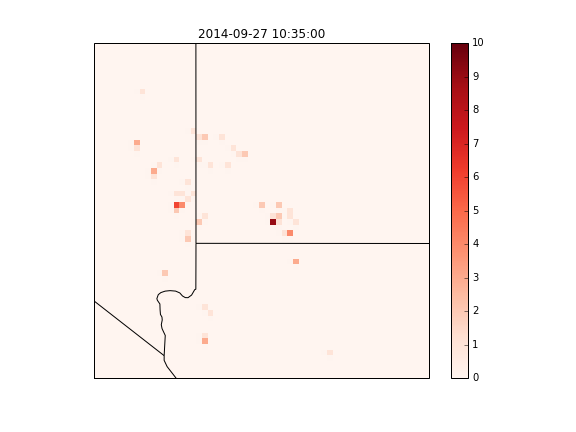
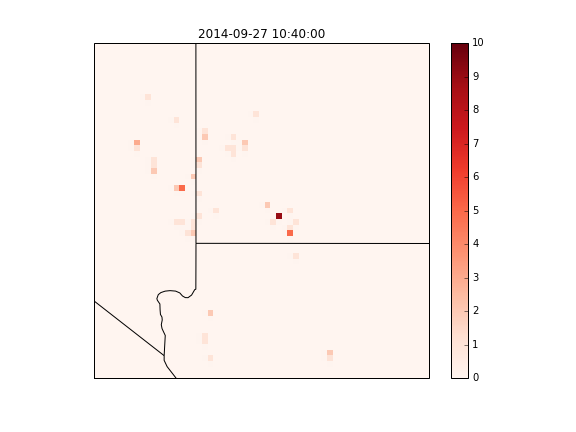
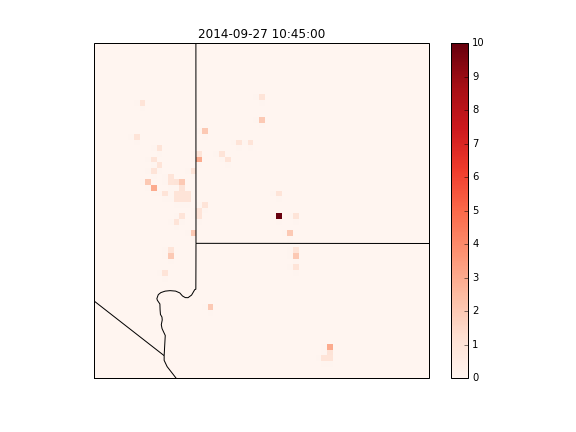
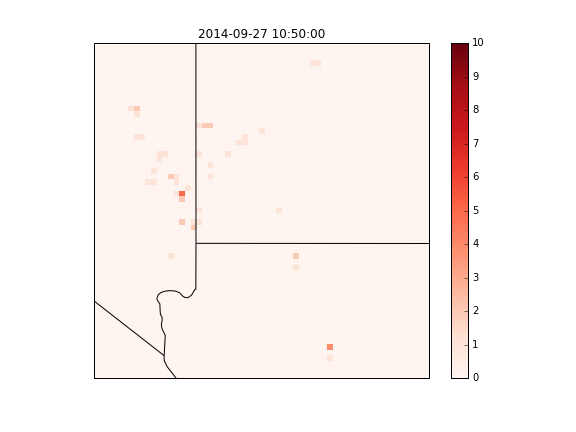
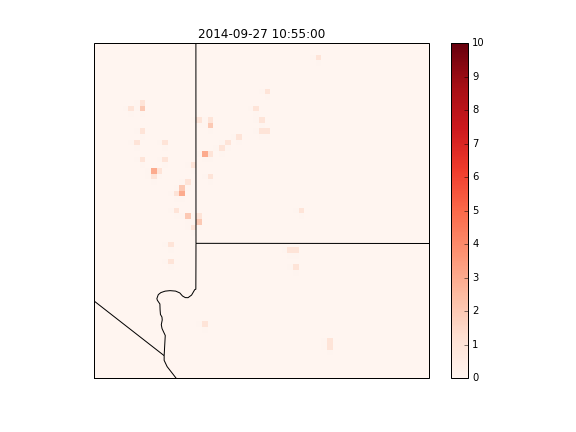
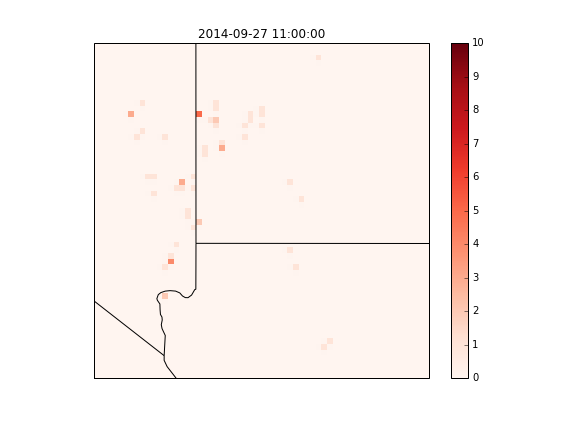
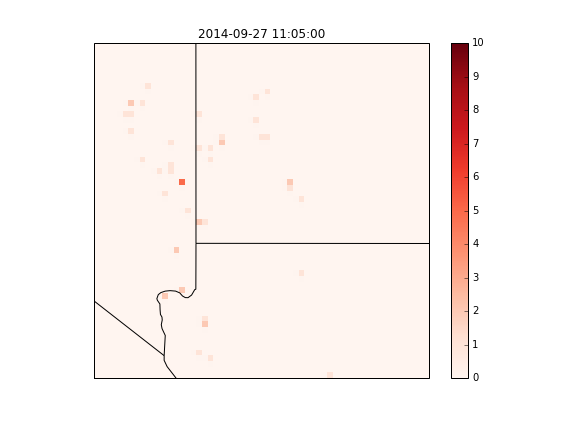
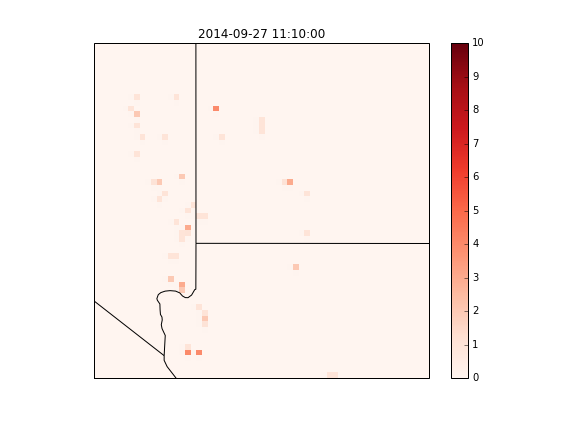
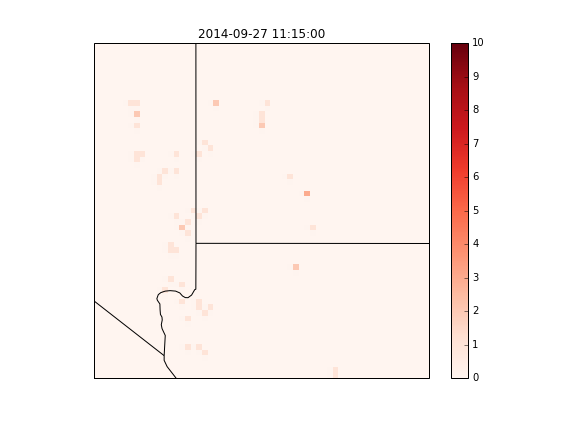
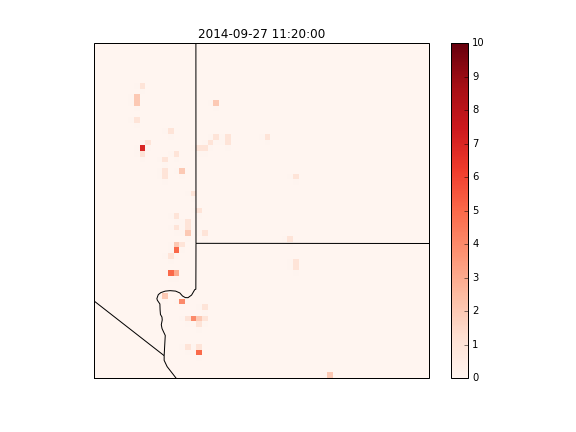
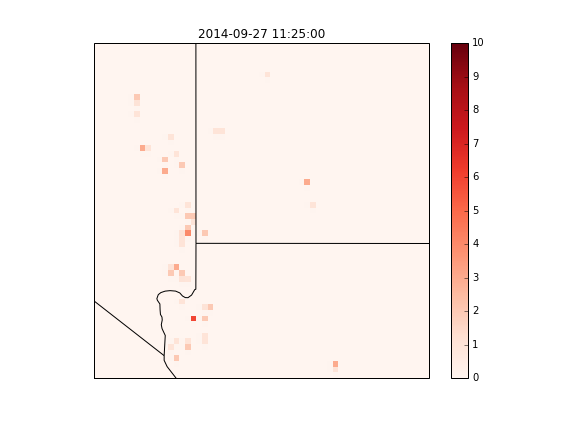
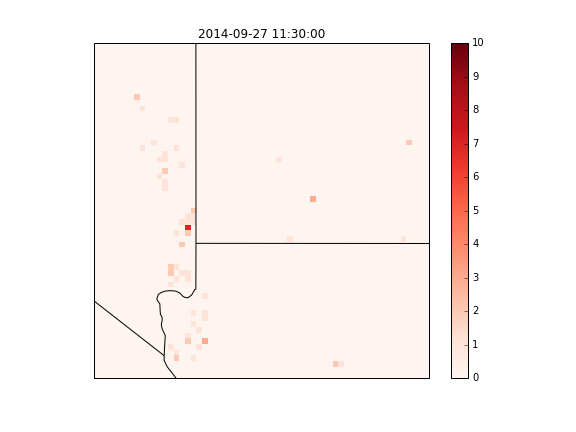
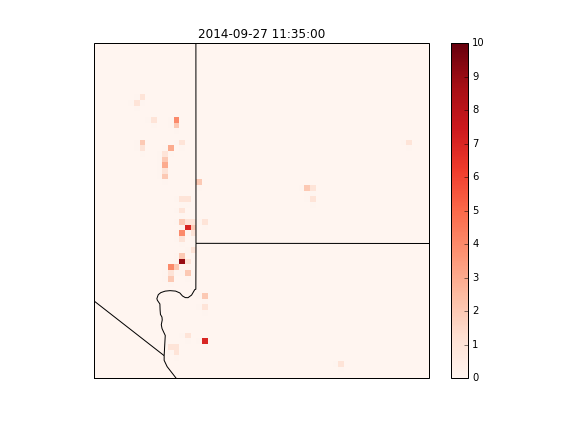
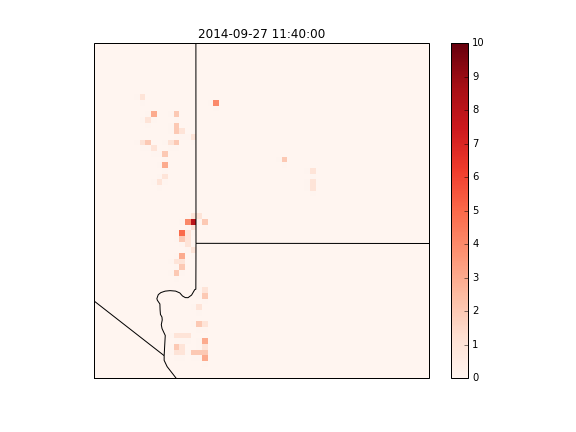
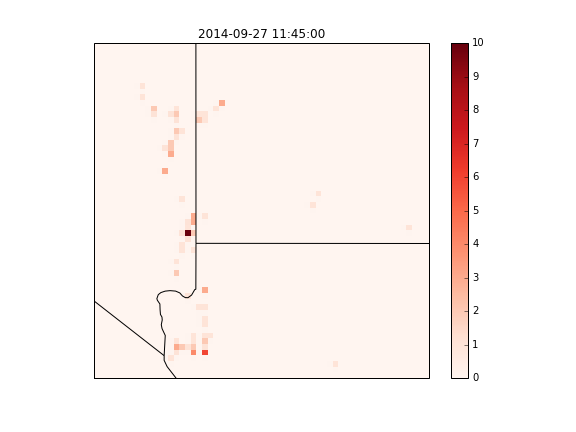
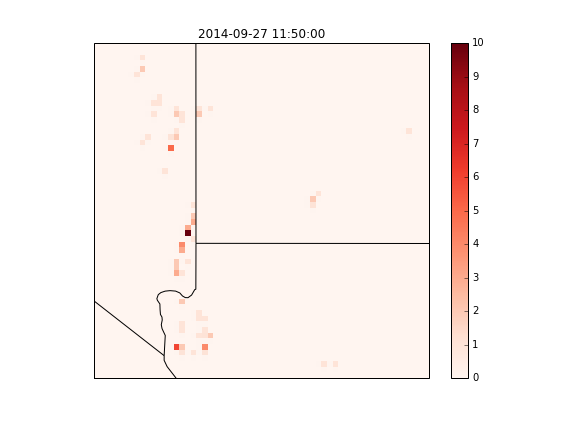
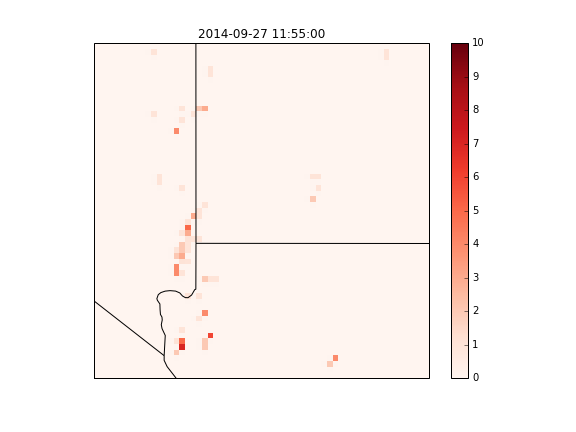

In [13]:
from matplotlib import animation
from JSAnimation import IPython_display

box, tr = c.get_grid_slices('2014-09-26', freq='5min')
fig = plt.figure(figsize=(8,6))
ax = background(plt.axes(projection=ccrs.PlateCarree()))
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
im = ax.imshow(box[0], cmap='Reds', interpolation='None', vmin=0, vmax=10,
               extent=[c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
plt.colorbar(im, ax=ax)

def init():
    im.set_data(box[0])
    return im,

def animate(i):
    im.set_data(box[i])
    ax.set_title(tr[i])
    return im,

animation.FuncAnimation(fig, animate, init_func=init, blit=False,
                        frames=24*12, interval=100)

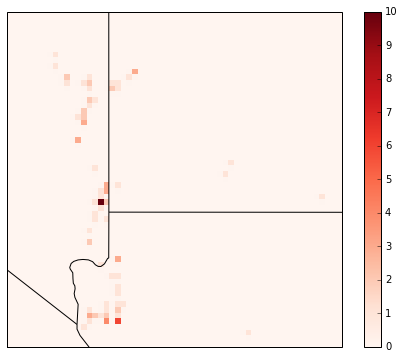

In [35]:
# %%timeit 33.8 ms for 600x600
# %%timeit 32.9 ms for 60x60

plt.figure(figsize=(8,6))
ax = background(plt.axes(projection=ccrs.PlateCarree()))
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
im = ax.imshow(box[110], cmap='Reds', interpolation='None',
               extent=[c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
plt.colorbar(im, ax=ax)

In [1]:
from rpy2 import robjects 
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
SpatialVx = importr('SpatialVx')
rsummary = robjects.r.summary

In [21]:
X, Y = np.meshgrid(c.gridx[0:-1], c.gridy[0:-1])

In [37]:
d = {}

ix0 = 0
ixn = 60
iy0 = 0
iyn = 60
ll = np.array([X[ix0:ixn,iy0:iyn].flatten('F'), Y[ix0:ixn,iy0:iyn].flatten('F')]).T
for i in range(box.shape[0]-1):
    hold = SpatialVx.make_SpatialVx(box[i,ix0:ixn,iy0:iyn], box[i+1,ix0:ixn,iy0:iyn], loc=ll)
    kwargs ={''}
    look = SpatialVx.FeatureFinder(hold, smoothpar=2, thresh=1, min_size=2)

    try:
        x = rsummary(look, silent=True)[0]
    except:
        continue
    px = pandas2ri.ri2py(x)
    df0 = pd.DataFrame(px, columns=['centroidX', 'centroidY', 'area', 'OrientationAngle', 
                                  'AspectRatio', 'Intensity0.25', 'Intensity0.9'])
    df0['Observed'] = list(df0.index+1)
    m = SpatialVx.centmatch(look, criteria=3, const=20)
    p = pandas2ri.ri2py(m[12])
    df1 = pd.DataFrame(p, columns=['Forecast', 'Observed'])
    l = SpatialVx.FeatureMatchAnalyzer(m)
    try:
        p = pandas2ri.ri2py(rsummary(l, silent=True))
    except:
        continue
    df2 = pd.DataFrame(p, columns=['Partial Hausdorff Distance','Mean Error Distance','Mean Square Error Distance',
                                  'Pratts Figure of Merit','Minimum Separation Distance', 'Centroid Distance',
                                  'Angle Difference','Area Ratio','Intersection Area','Bearing', 'Baddeleys Delta Metric',
                                  'Hausdorff Distance'])
    df3 = df1.join(df2)

    d.update({tr[i]: pd.merge(df0, df3, how='outer')})

    

[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"


In [39]:
pd.Panel(d)

<class 'pandas.core.panel.Panel'>
Dimensions: 74 (items) x 12 (major_axis) x 21 (minor_axis)
Items axis: 2014-09-26 12:30:00 to 2014-09-27 11:50:00
Major_axis axis: 0 to 11
Minor_axis axis: centroidX to Hausdorff Distance